In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import statsmodels.api as sma
import matplotlib.pyplot as plt
import seaborn as sns


from scipy.stats import shapiro, kstest, ttest_ind, mannwhitneyu, fisher_exact, chi2_contingency, kruskal, wilcoxon, ttest_rel
from statsmodels.stats.contingency_tables import mcnemar, cochrans_q
from pandas.api.types import CategoricalDtype

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)

### Импорт таблицы и удаление лишних переменных (открытых вопросов)

In [18]:
df = pd.read_excel('C:/Users/lizag/OneDrive/Рабочий стол/Управление талантами/Финальный проект/DBTC1.xlsx', sheet_name = 'Answers')

df = df.drop(columns = ['YouAnswer', 'IFoundOutPositiveOnlyAsEmployee', 'IFoundOutNegativeOnlyAsEmployee', 'WhyIchooseCompany', 'IllrecommendcompanyAsEmployer', 'WhyIrecommendCompany', 'WhatItellAboutComp', 'Keyword1', 'Keyword2', 'Keyword3'])

### Пропущенные значения

In [19]:
nulls = df.isna().sum().to_frame().reset_index()
nulls['Доля пропущенных, %'] = round(nulls.iloc[:,1] / df.shape[0]*100, 1)
nulls.columns = ['Фактор', 'Количество пропущенных, n', 'Доля пропущенных, %']
nulls.sort_values('Доля пропущенных, %', ascending = False).head()

Фактор  Количество пропущенных, n  \
0                                 City                          4   
48              ExistsWorkInUnitedTeam                          1   
64  ExistsJobImportanceBusiGoalConnect                          0   
74                    ExistsCSRCharity                          0   
73                 ImportantCSRCharity                          0   

    Доля пропущенных, %  
0                   0.7  
48                  0.2  
64                  0.0  
74                  0.0  
73                  0.0

### Графики распределения

Можно копировать одной большой таблицей и вырезать по несколкьо графиков, качество от этого не теряется

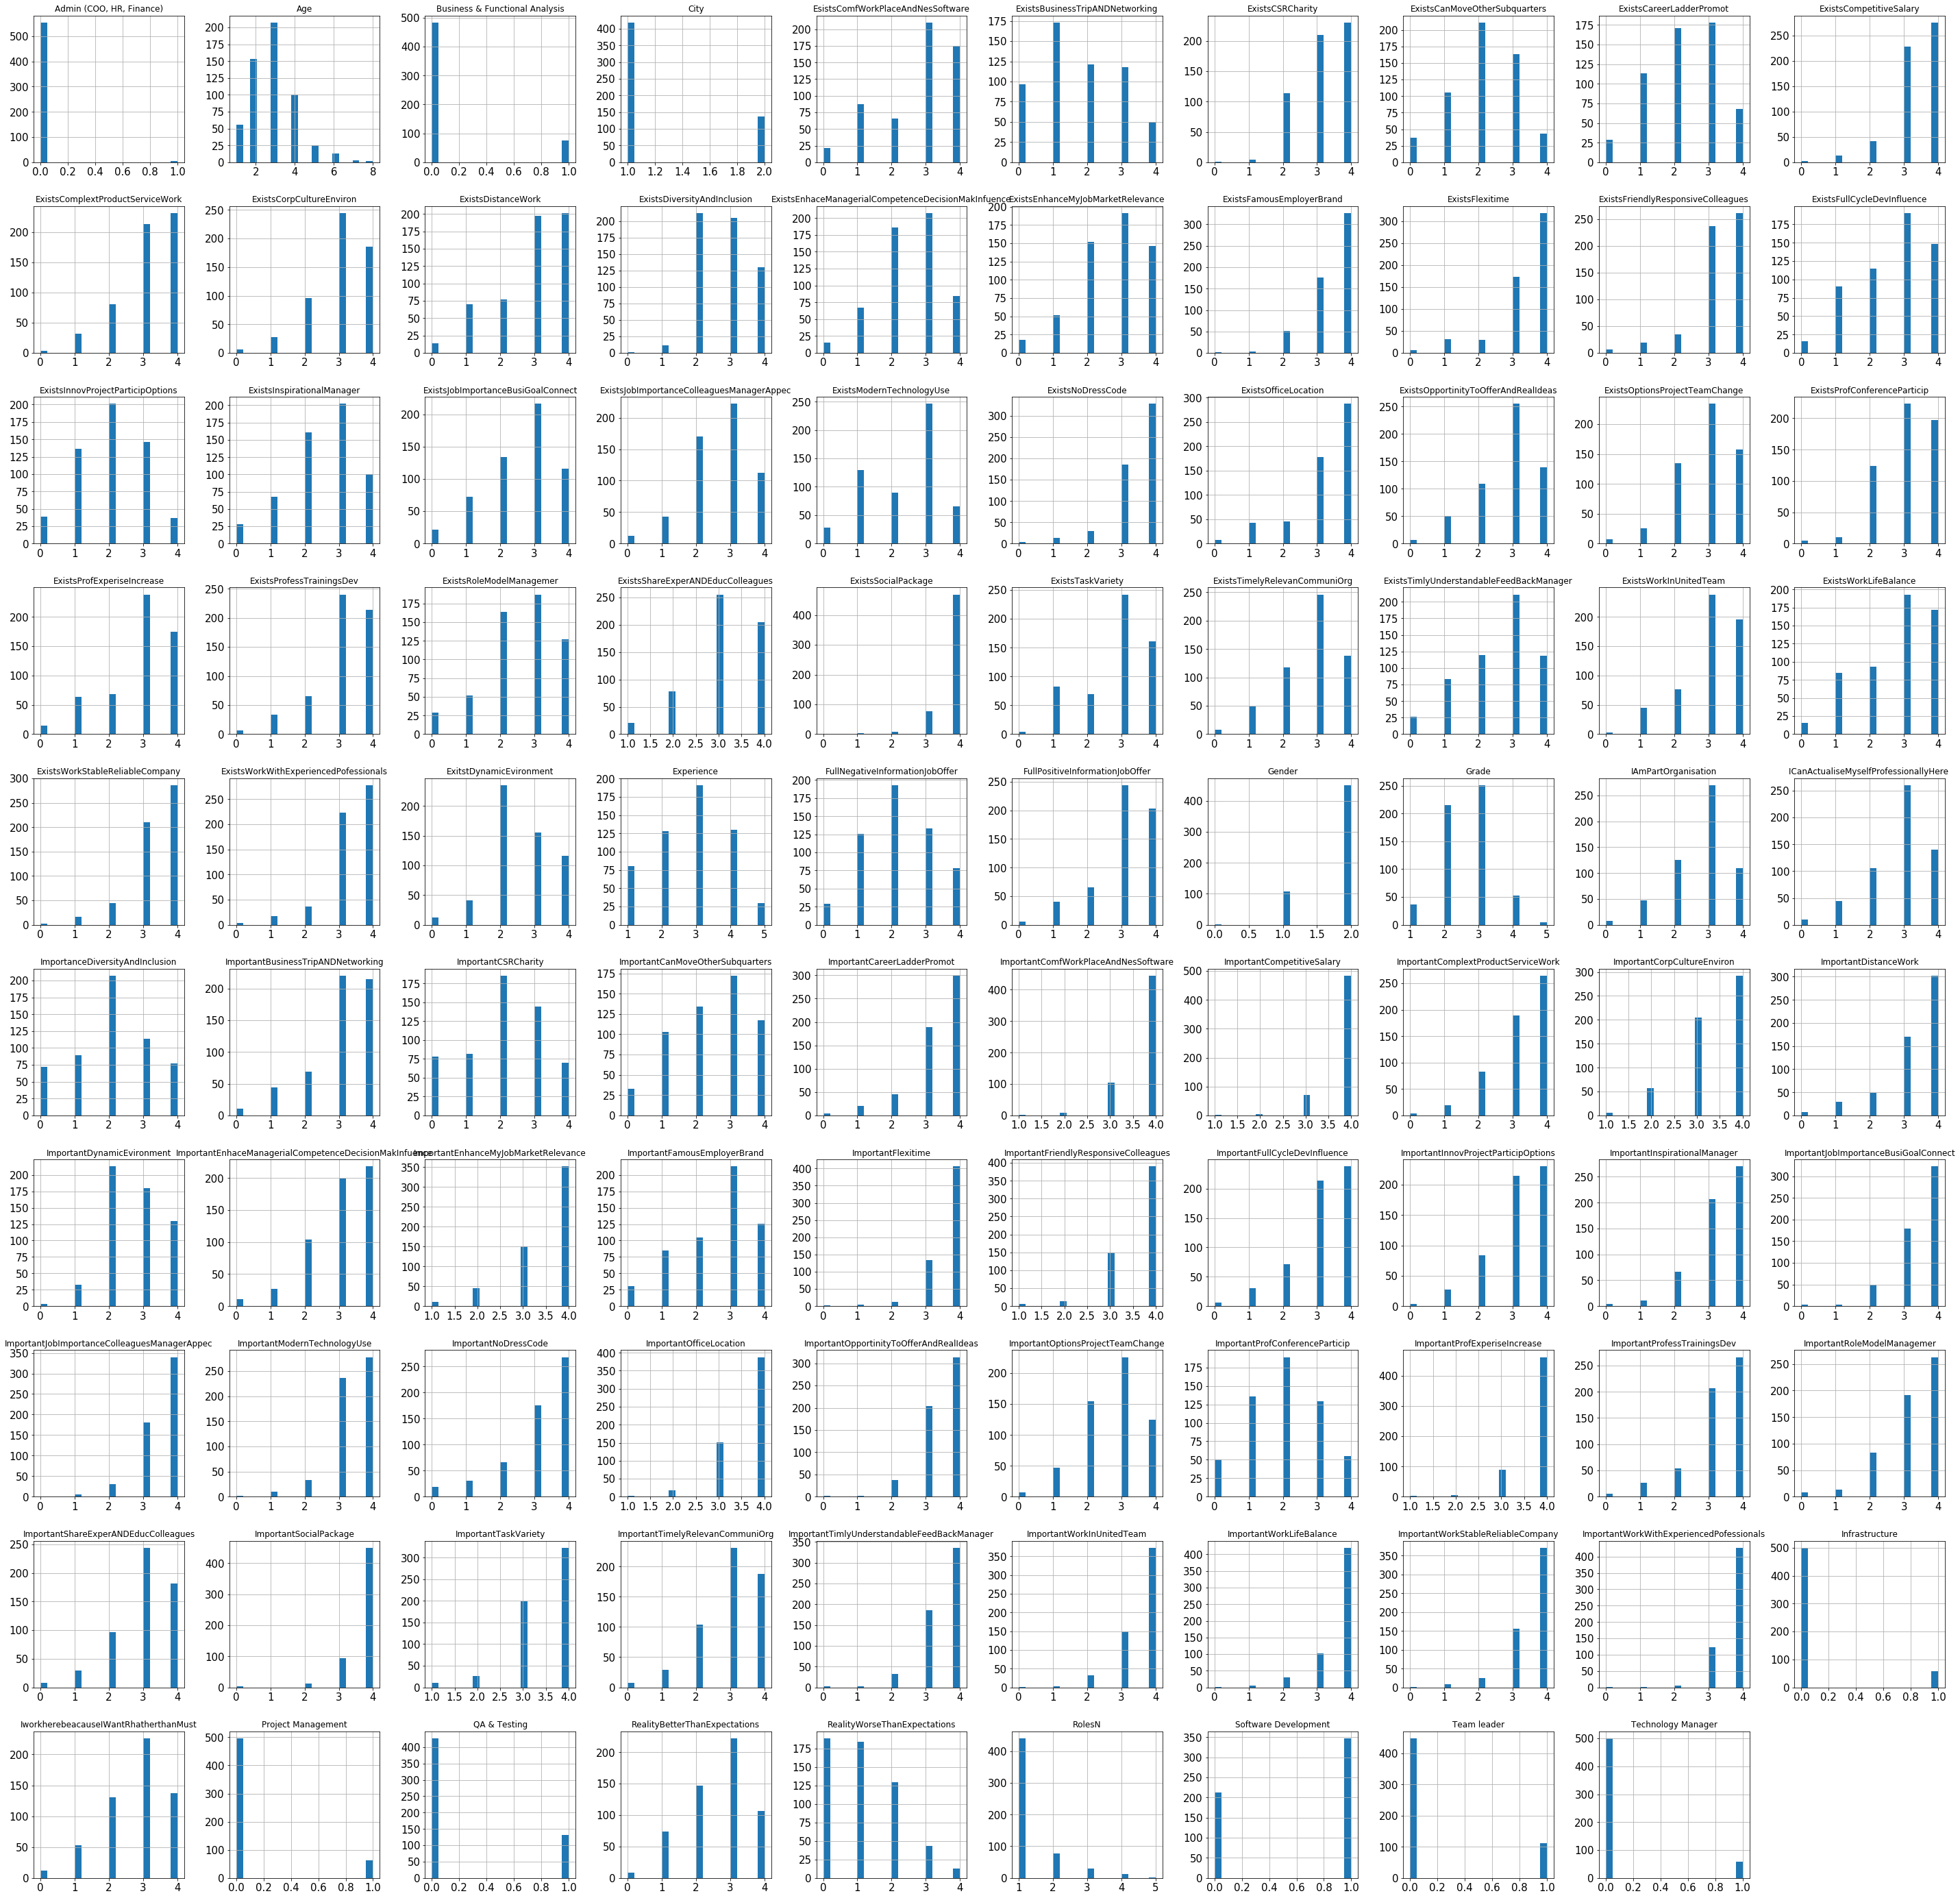

In [7]:
df.hist(figsize=(50, 50), bins=20, xlabelsize=15, ylabelsize=15);


In [113]:
df1 = pd.read_excel('C:/Users/lizag/OneDrive/Рабочий стол/Управление талантами/Финальный проект/DBTC1.xlsx', sheet_name = 'Answers')

## Описательный анализ

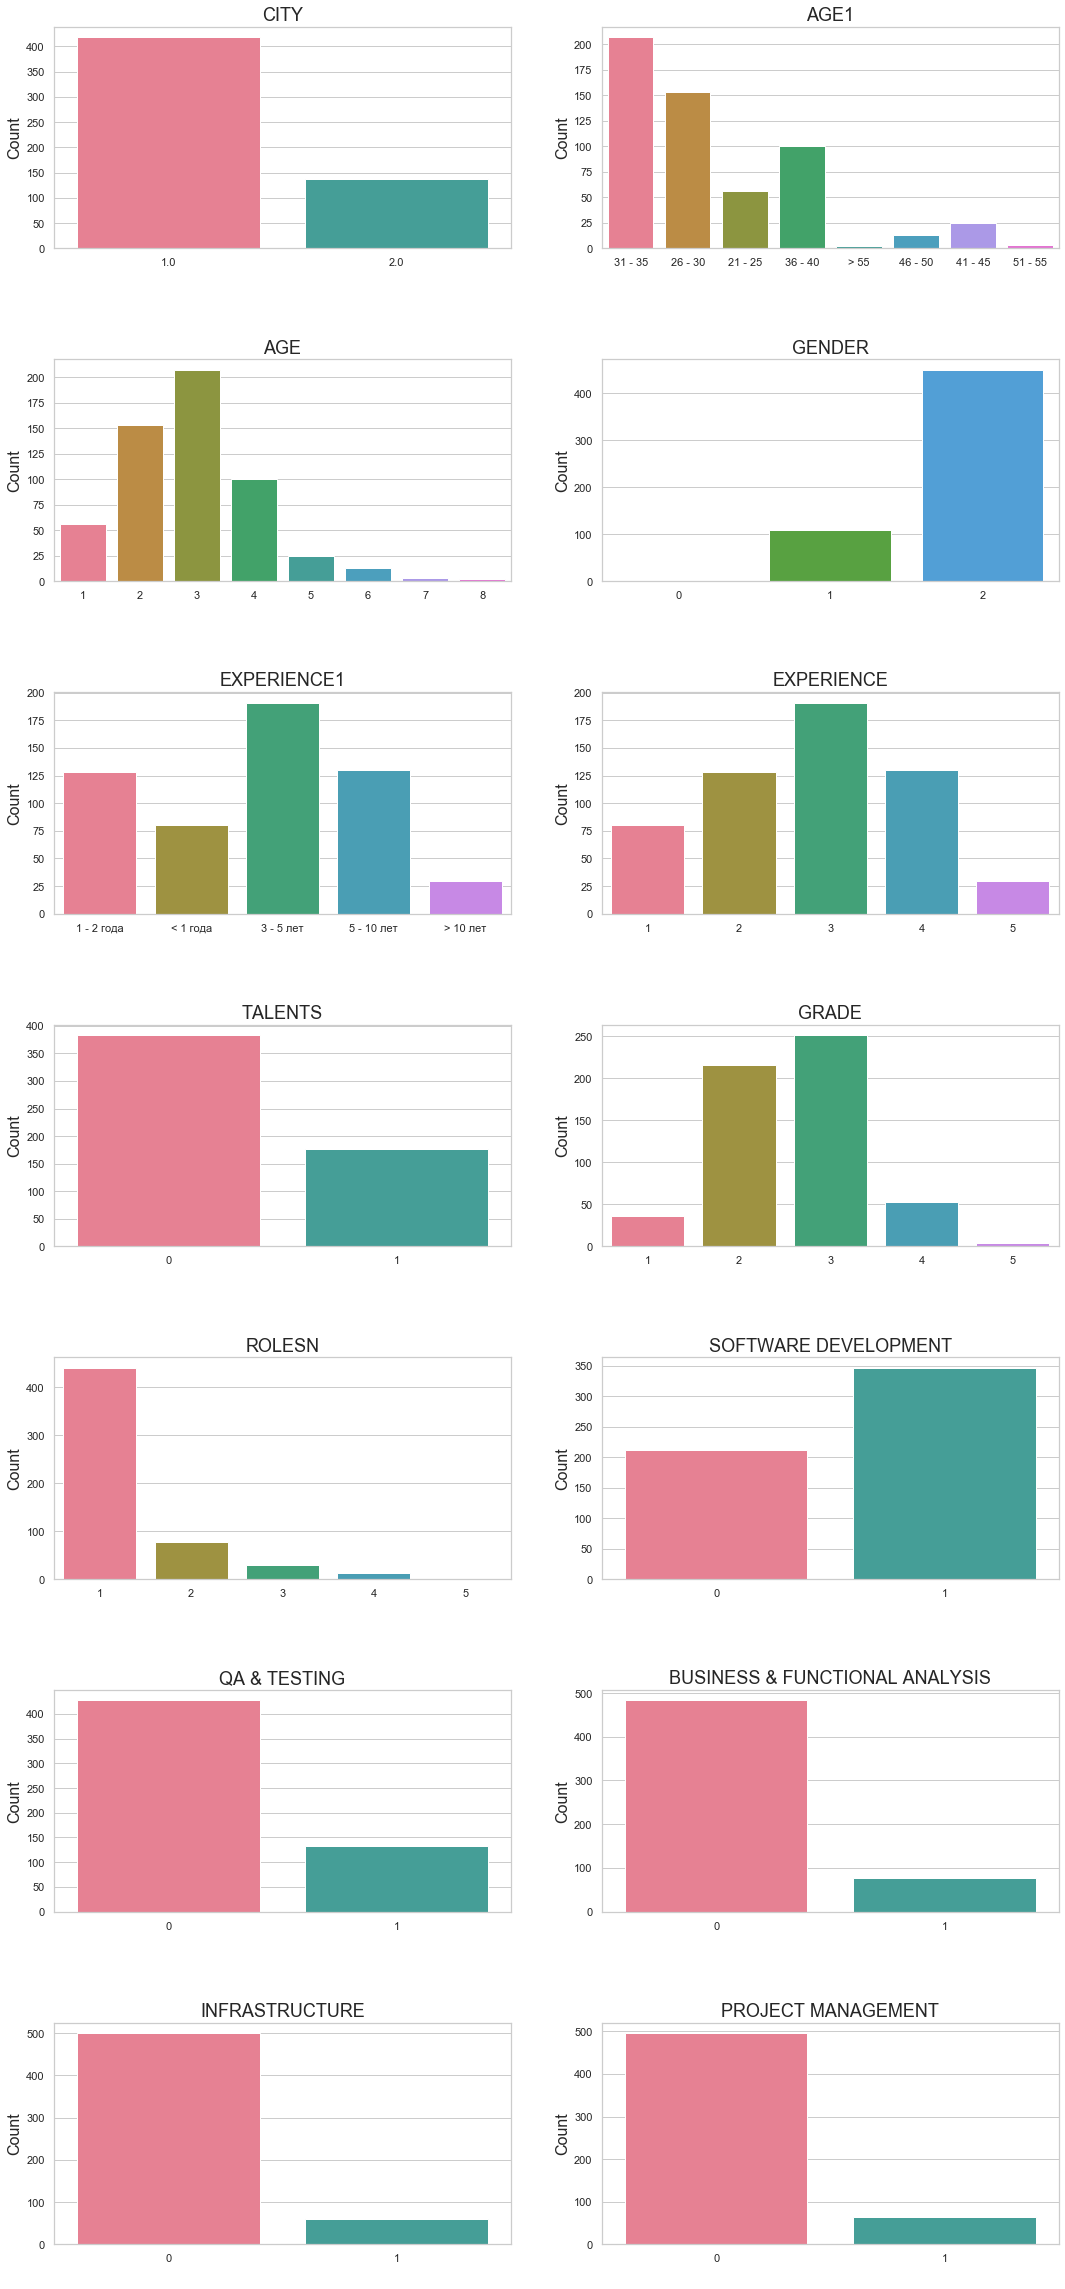

In [116]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(18,35))
fig.subplots_adjust(hspace=0.5, bottom=0)

for ax, catplot in zip(axes.flatten(), df1):
        sns.countplot(x=catplot, data=df1, ax=ax, palette='husl')
        ax.set_title(catplot.upper(), fontsize=18)
        ax.set_ylabel('Count', fontsize=16)
        ax.set_xlabel(' ', fontsize=15)

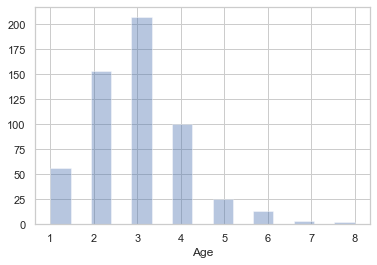

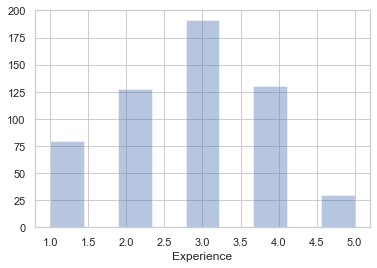

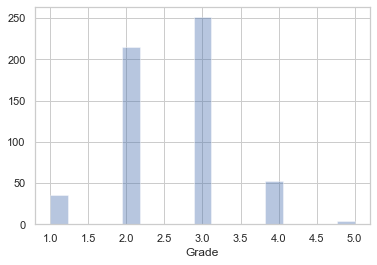

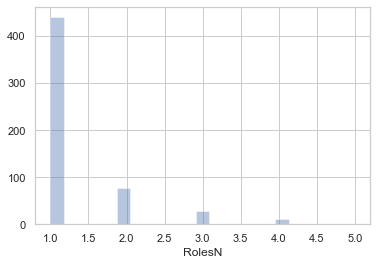

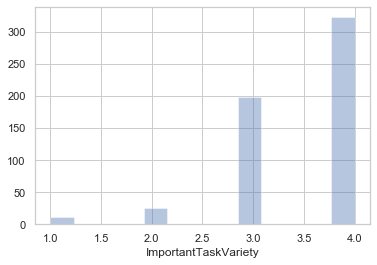

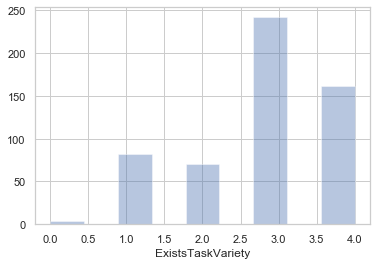

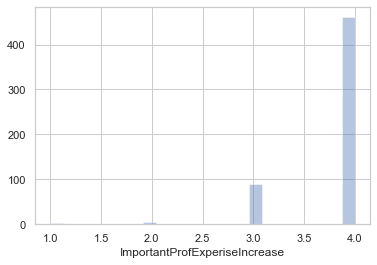

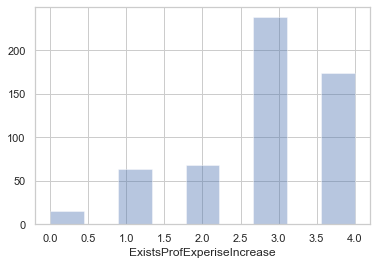

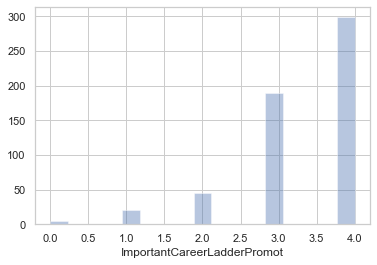

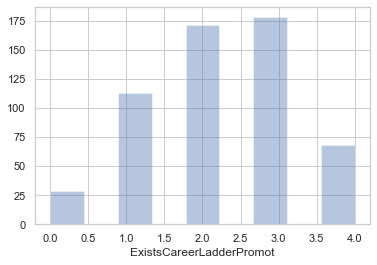

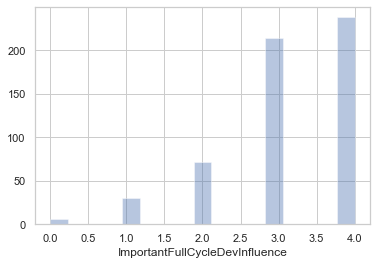

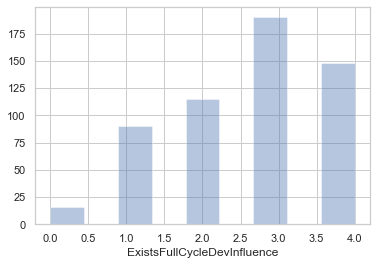

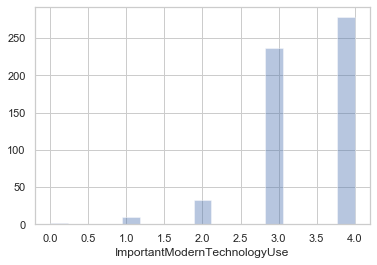

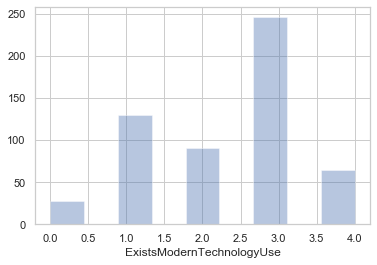

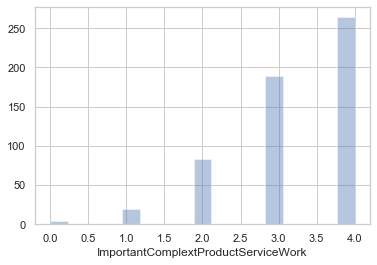

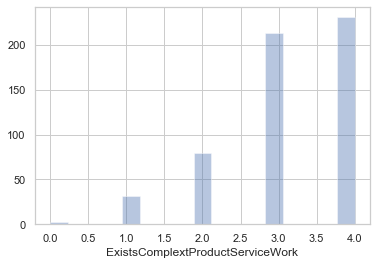

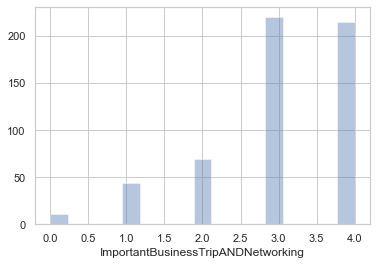

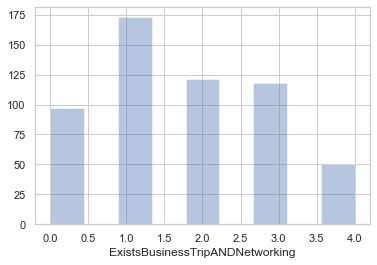

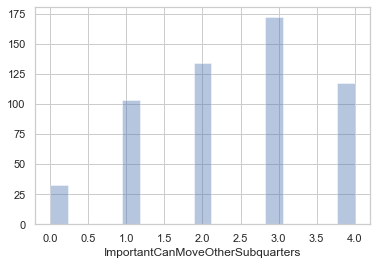

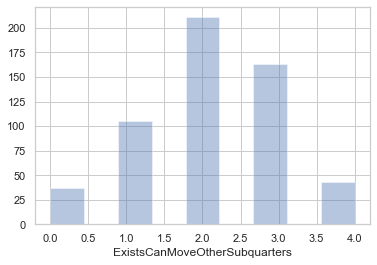

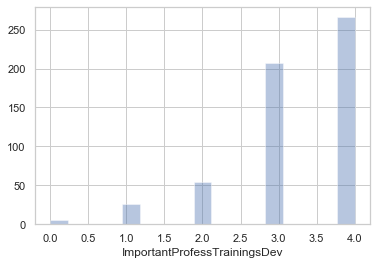

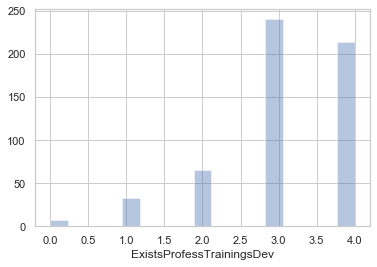

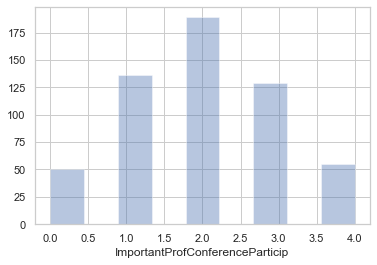

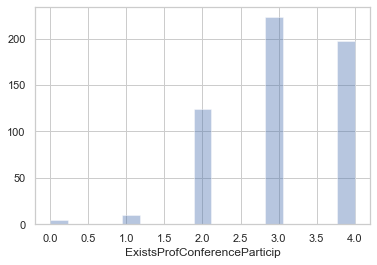

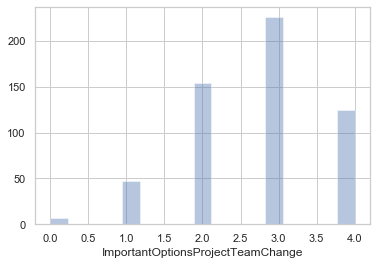

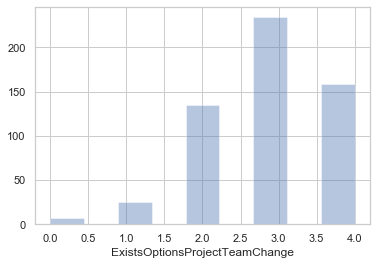

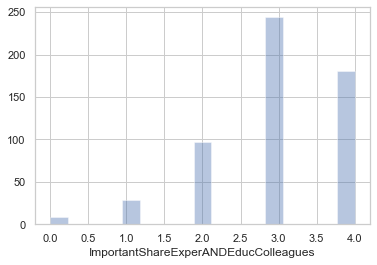

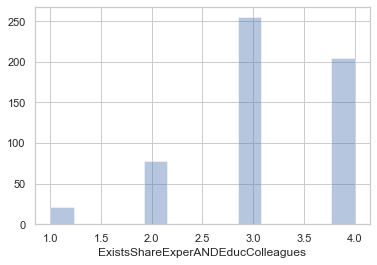

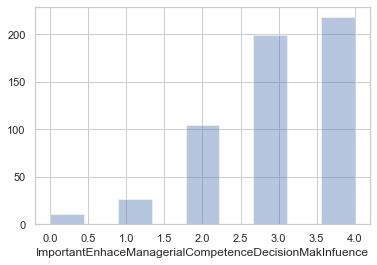

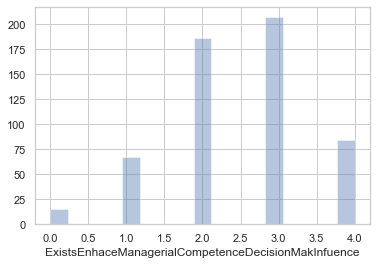

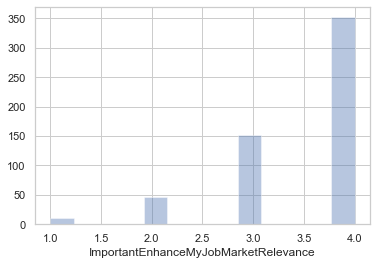

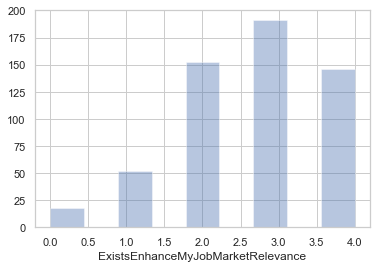

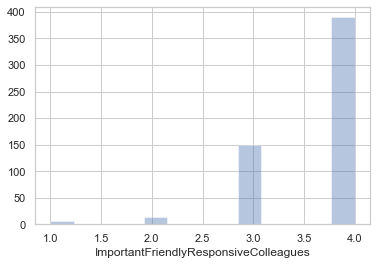

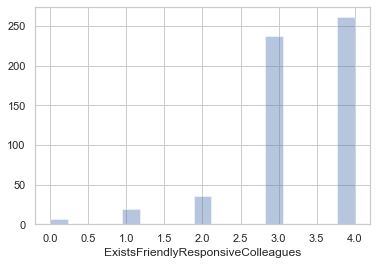

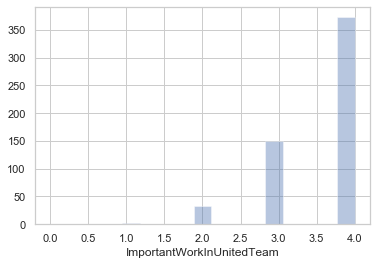

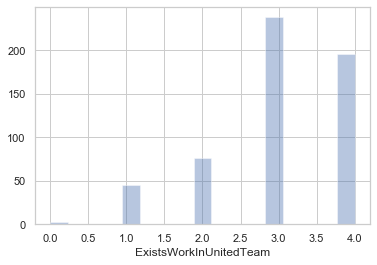

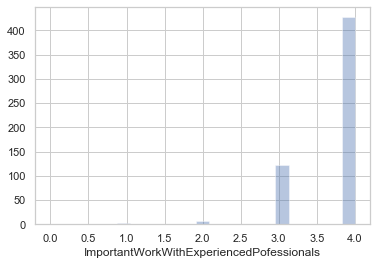

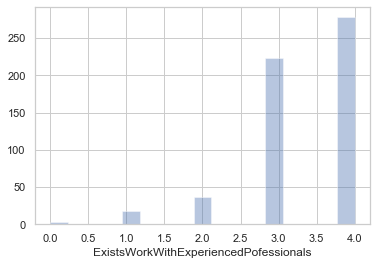

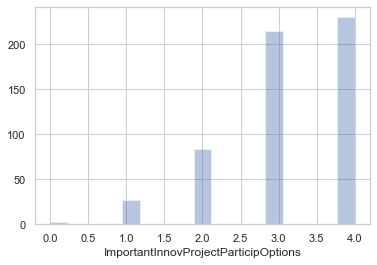

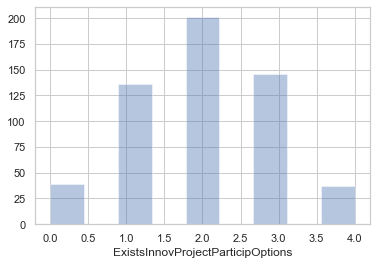

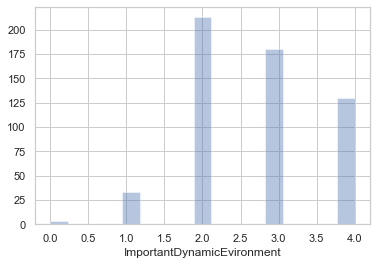

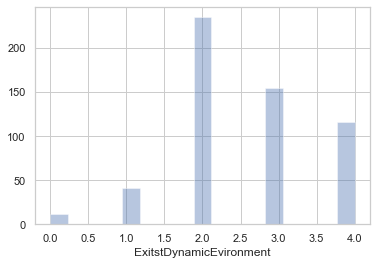

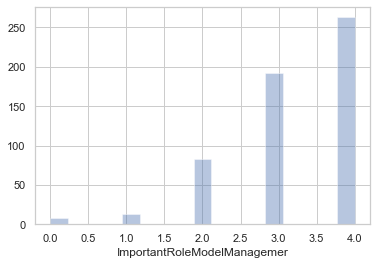

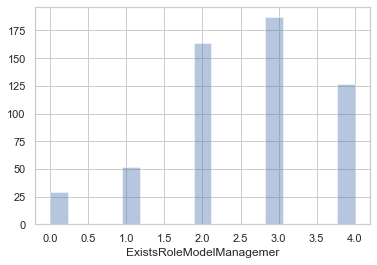

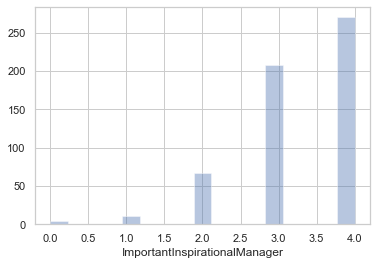

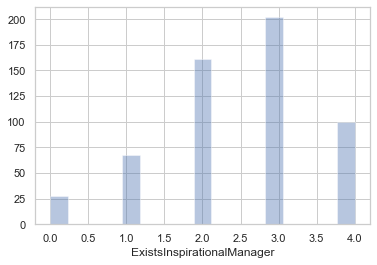

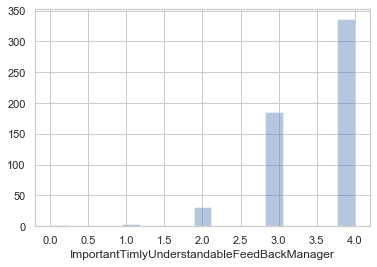

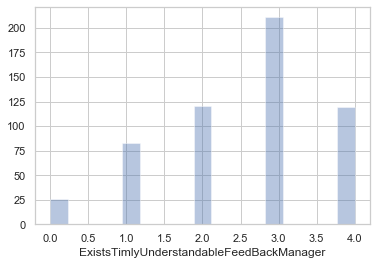

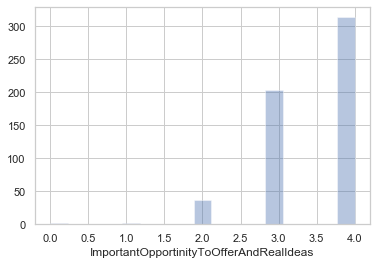

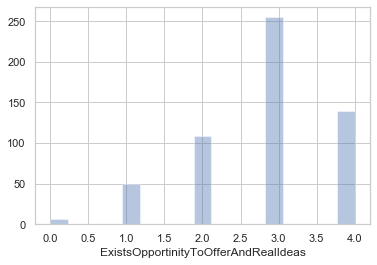

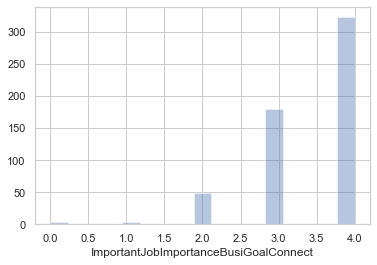

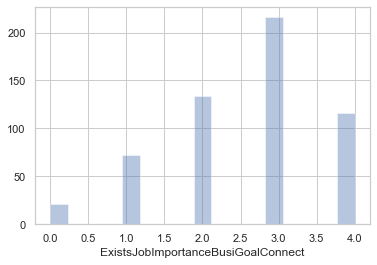

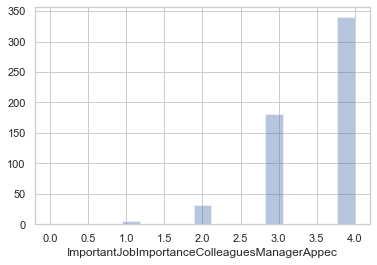

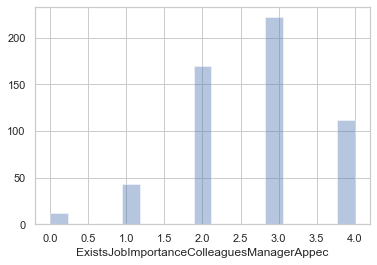

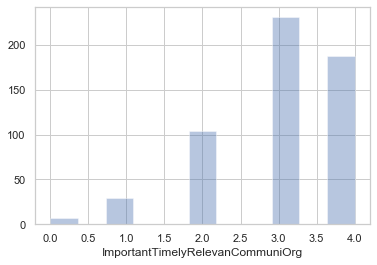

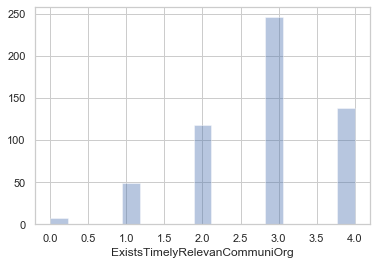

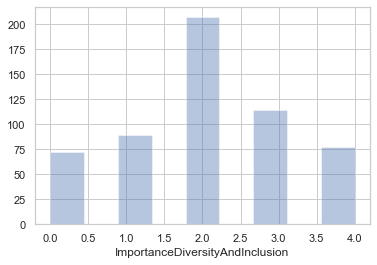

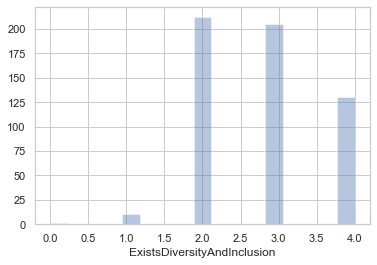

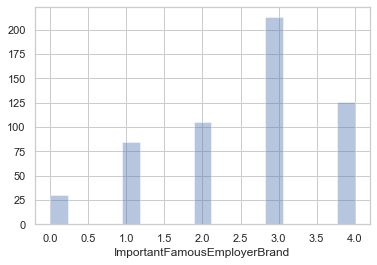

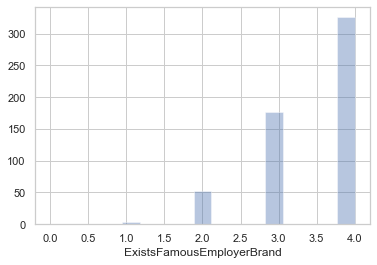

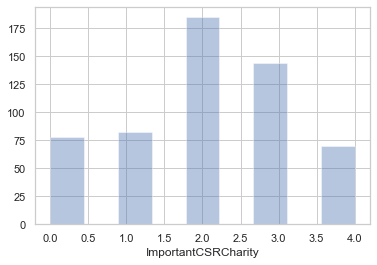

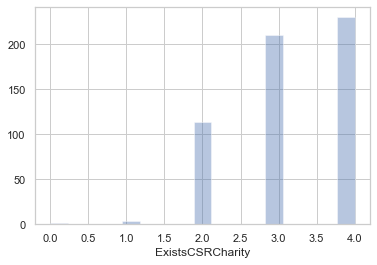

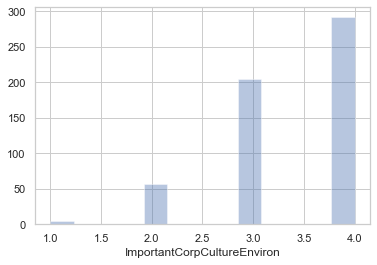

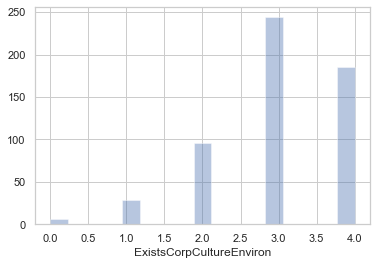

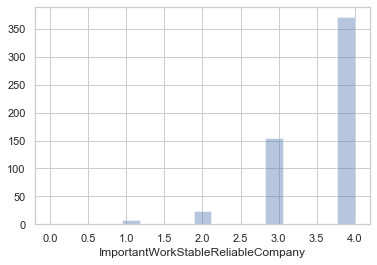

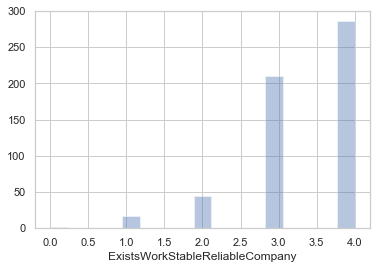

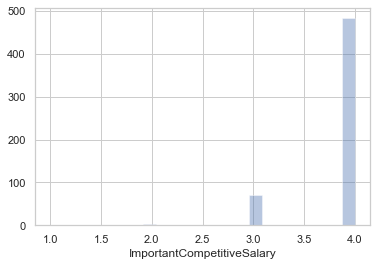

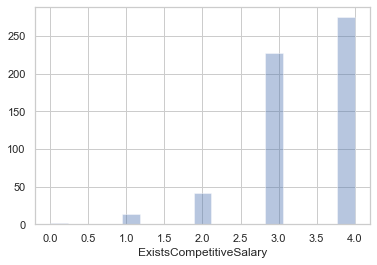

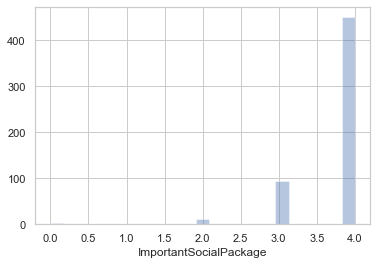

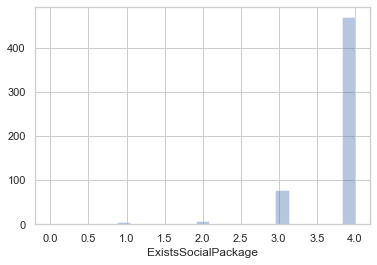

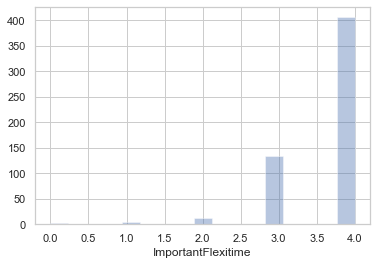

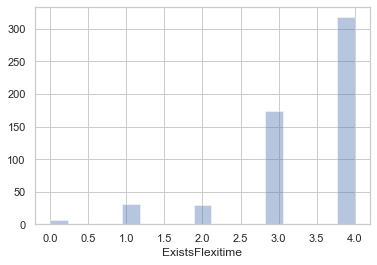

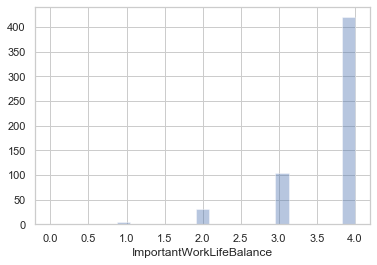

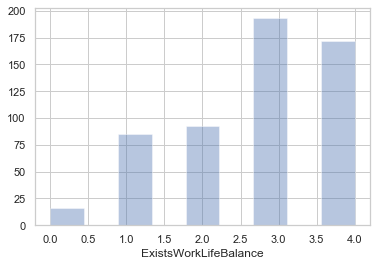

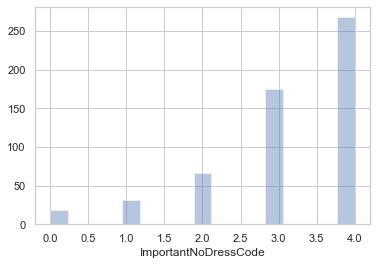

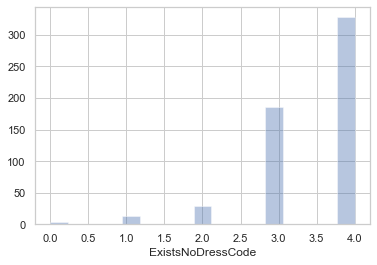

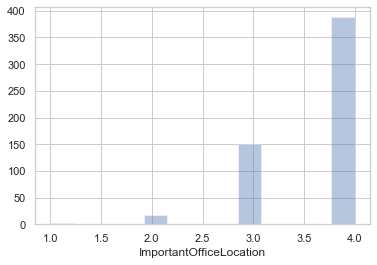

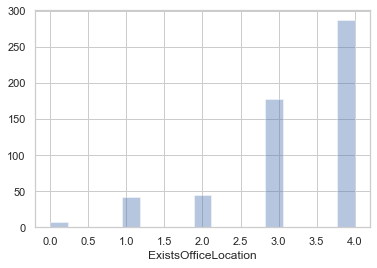

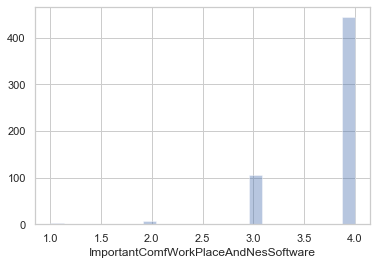

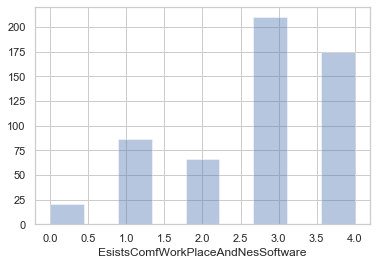

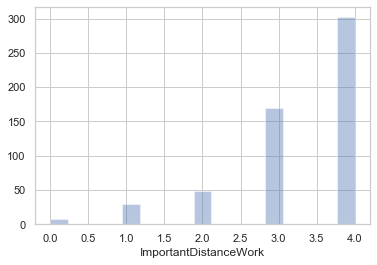

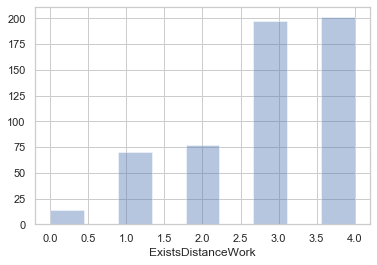

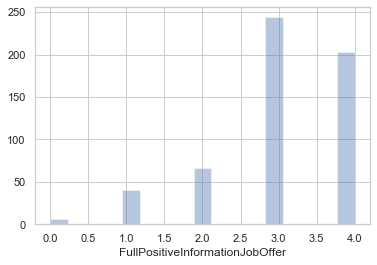

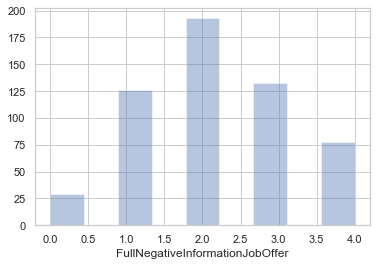

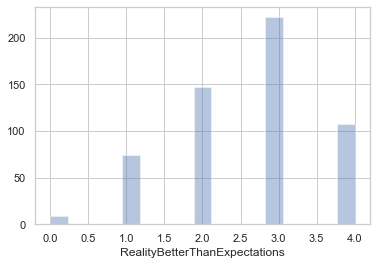

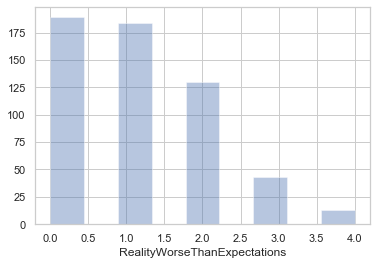

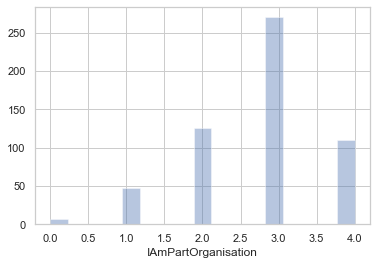

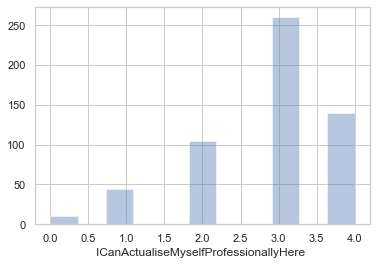

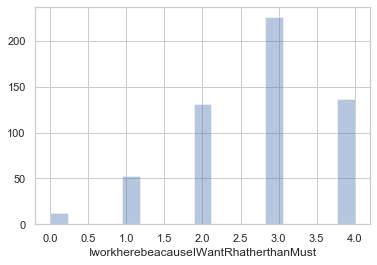

In [125]:
numerics = [x for x in df.columns if len(pd.unique(df[x].dropna())) > 2]

for col in df[numerics].columns:
    sns.distplot(df[col].dropna(), kde=False)
    plt.show()

###  Создание дамми-переменных

In [20]:
"""
Преобразование в dummy - переменные с сохранением NA, если они присутствуют. 
"""

def dummy_serie(df, col):
    tab = pd.get_dummies(df[col], prefix = col)
    tab.loc[df[col].isnull(), tab.columns.str.startswith(str(col))] = np.nan
    return(tab)

def dummification(df, cat_vars):
    data = df[cat_vars]
    tab = pd.DataFrame()
    for col in data:
        tab = pd.concat([dummy_serie(df, col), tab], axis = 1)
    
    tab = tab[tab.columns[::-1]]
    df =df.drop(columns = cat_vars)
    df = pd.concat([df, tab], axis = 1)
        
    return(df)

In [21]:
cat_vars = ['City', 'Age1', 'Gender', 'Experience1']
df = dummification(df, cat_vars)
df = df.drop(columns = 'Gender_2')


### Описательные статистики по всей группе

Распределение везде ненормальное

In [15]:
"""
summary
"""

def to_array(df, col):
    return df[[col]].dropna().to_numpy()[:,0]


def cat_perc(var):
    n = round(np.sum(var),0)
    percents = round(n / len(var)*100, 1)
    return n, percents


def summ_numer(var):
    avg = np.mean(var) 
    sd = np.std(var) 
    mn = np.min(var) 
    mx = round(np.max(var),1)
    md = round(np.median(var),1)
    c25 = np.percentile(var, 25)
    c75 = np.percentile(var, 75)
    c2_5 = np.percentile(var, 2.5)
    c975 = np.percentile(var, 97.5)
    return avg, sd, mn, mx, md, c25, c75, c2_5, c975    

def summary_all(df, save_tab = False):
    summarize = pd.DataFrame()
    for col in df:
        v = df[col].name
        var = to_array(df, col)
        if len(np.unique(var)) == 1:
            vartype = 'Уникальная'
            n = round(len(var),0)
            med = avg = minn = maxx = sh = c2_5 = c975 = np.unique(var)
            percents = '-'
            N = len(var)
        elif len(np.unique(var)) < 3:
            v = df[col].name
            vartype = 'Категориальная'
            n, percents = cat_perc(var)
            percents = str(percents).join(' %')
            med = avg = minn = maxx = sh = c2_5 = c975 = '-'
            N = len(var)
        else:
            v = df[col].name
            vartype = 'Числовая'
            n = round(len(var),0)
            percents = '-'
            avg, sd, minn, maxx, md, c25, c75, c2_5, c975 = summ_numer(var)
            avg = ''.join([str(round(avg, 1)), ' ± ', str(round(sd, 1))])
            med = ''.join([str(round(md,1)), ' [',str(round(c25,1)),'; ',str(round(c75, 1)),']'])
            sh = kstest(var, cdf='norm')[1]
            if sh >= 0.001:
                sh = '{0:.3f}'.format(sh)
            else:
                sh = '< 0.001'                
            N = len(var)
            
        summarize = summarize.append({'Фактор': v, 'Тип': vartype, 'N':'% 6.0f' % N, 'Количество': '% 6.0f' % n, \
            'Доля, %': percents,'Медиана и 25/75 перцентили': med, 'Среднее и ст. отклонение': avg , \
            'Мин': minn, 'Макс': maxx, 'Критерий КС, р': sh, '2,5%': c2_5, '97,5%':c975}, ignore_index=True)
    summarize = summarize.reindex(columns=['Фактор', 'Тип', 'N','Количество', 'Доля, %', 'Мин', '2,5%','Медиана и 25/75 перцентили', '97,5%','Макс', 'Среднее и ст. отклонение', 'Критерий КС, р'])

    if save_tab == True:
        return pd.DataFrame.to_excel(summarize, 'Описательные статистики.xlsx')
    else:
        return summarize
    
def summary_num(df, save_tab = False):
    summarize = pd.DataFrame()
    for col in df:
        v = df[col].name
        var = to_array(df, col)
        if len(np.unique(var)) == 1:
            vartype = 'Уникальная'
            n = round(len(var),0)
            med = avg = minn = maxx = sh = c2_5 = c975 = np.unique(var)
        else:
            v = df[col].name
            vartype = 'Числовая'
            n = round(len(var),0)
            percents = '-'
            avg, sd, minn, maxx, md, c25, c75, c2_5, c975 = summ_numer(var)
            avg = ''.join([str(round(avg, 1)), ' ± ', str(round(sd, 1))])
            med = ''.join([str(round(md,1)), ' [',str(round(c25,1)),'; ',str(round(c75, 1)),']'])
            sh = kstest(var, cdf='norm')[1]
            if sh >= 0.001:
                sh = '{0:.3f}'.format(sh)
            else:
                sh = '< 0.001'                
            N = len(var)
            
        summarize = summarize.append({'Фактор': v, 'Тип': vartype, 'N':'% 6.0f' % N, 'Количество': '% 6.0f' % n, \
            'Медиана и 25/75 перцентили': med, 'Среднее и ст. отклонение': avg , \
            'Мин': minn, 'Макс': maxx, 'Критерий КС, р': sh, '2,5%': c2_5, '97,5%':c975}, ignore_index=True)
    summarize = summarize.reindex(columns=['Фактор', 'Тип', 'N','Количество', 'Мин', '2,5%','Медиана и 25/75 перцентили', '97,5%','Макс', 'Среднее и ст. отклонение', 'Критерий КС, р'])

    if save_tab == True:
        return pd.DataFrame.to_excel(summarize, 'Описательные статистики.xlsx')
    else:
        return summarize    

def summary_cat(df, save_tab = False):
    summarize = pd.DataFrame()
    for col in df:
        v = df[col].name
        var = to_array(df, col)
        n, percents = cat_perc(var)
        percents = str(percents).join(' %')
        N = len(var)
            
        summarize = summarize.append({'Фактор': v, 'N':'% 6.0f' % N, 'Количество': '% 6.0f' % n, 'Доля, %': percents}, ignore_index=True)
    summarize = summarize.reindex(columns=['Фактор', 'N','Количество', 'Доля, %'])

    if save_tab == True:
        return pd.DataFrame.to_excel(summarize, 'Описательные статистики.xlsx')
    else:
        return summarize
    
def summary(df, save_tab = False, method = 'all'):
    df = df
    save_tab = save_tab
    
    if method == 'all':
        return(summary_all(df, save_tab = save_tab))
    elif method == 'num':
        return(summary_num(df, save_tab = save_tab))
    elif method == 'cat':
        return(summary_cat(df, save_tab = save_tab))
    else:
        return(print('ERROR: method is `all` or `num` or `cat`'))


"""
compare
"""


def compare_cat(x_var, y_var):
    gr1obs = np.sum(x_var)
    gr2obs = np.sum(y_var)
    gr1exp = len(x_var) - gr1obs
    gr2exp = len(y_var) - gr2obs
    return gr1obs, gr2obs, gr1exp, gr2exp


def compare_numer_unnorm(x_var, y_var):
    gr1obs = round(np.median(x_var),2)
    gr2obs = round(np.median(y_var),2)
    cent1 = np.percentile(x_var, [25,75])
    cent2 = np.percentile(y_var, [25,75])
    return gr1obs, gr2obs, cent1, cent2


def compare_numer_norm(x_var, y_var):
    gr1obs = round(np.median(x_var),2)
    gr2obs = round(np.median(y_var),2)
    sd1 = np.std(x_var)
    sd2 = np.std(y_var)
    return gr1obs, gr2obs, sd1, sd2


def compare_all(df, group, gr_id_1 = 0, gr_id_2 = 1, name_1 = 'Группа 0', name_2 = 'Группа 1', test = 'mw', save_tab = False):

    x = df.loc[df[group] == gr_id_1].drop(columns = group)
    y = df.loc[df[group] == gr_id_2].drop(columns = group)

    comparison = pd.DataFrame()

    for col in x:
        x_var = to_array(x, col)
        y_var = to_array(y, col)
        v = df[col].name
        if len(np.unique(df[col])) < 3:
                 
            gr1obs, gr2obs, gr1exp, gr2exp = compare_cat(x_var, y_var)
                # в таблицу идут:
            p_val = round(fisher_exact(np.array([[gr1obs, gr2obs], [gr1exp, gr2exp]]))[1], 3)
            p1 = ''.join([str('{0:.0f}'.format(gr1obs)), " ", " (", str(round(gr1obs/len(x_var)*100,1))," %)"])
            p2 = ''.join([str('{0:.0f}'.format(gr2obs)), " ", " (", str(round(gr2obs/len(y_var)*100,1))," %)"])
            Nx = len(x_var)
            Ny = len(y_var)
        else:
            v = df[col].name
            if test == 'mw':
                gr1obs, gr2obs, cent1, cent2 = compare_numer_unnorm(x_var, y_var)
                    # в таблицу идут:
                p_val = round(mannwhitneyu(x[col], y[col])[1], 3)
                p1 = ''.join([str(gr1obs), " [", str(round(cent1[0],2)), "; ", str(round(cent1[1],2)), "]"])
                p2 = ''.join([str(gr2obs), " [", str(round(cent2[0],2)), "; ", str(round(cent2[1],2)), "]"])
                Nx = len(x_var)
                Ny = len(y_var)
            elif test == 'tt':
                gr1obs, gr2obs, sd1, sd2 = compare_numer_norm(x_var, y_var)
                p_val = round(ttest_ind(x_var, y_var, equal_var = False)[1], 3)
                p1 = ''.join([str(gr1obs), " ± ", str(round(sd1, 1))])
                p2 = ''.join([str(gr2obs), " ± ", str(round(sd2, 1))])
                Nx = len(x_var)
                Ny = len(y_var)
            else:
                print('ERROR: test is mw or tt (Welch)')

        comparison = comparison.append({'Фактор': v, name_1: p1, name_2: p2,'p_val': p_val, 'N 0': '{0:.0f}'.format(Nx), 'N 1' : '{0:.0f}'.format(Ny)}, ignore_index=True) #
        
    comparison = comparison.reindex(columns=['Фактор', 'N 0','N 1',name_1, name_2, 'p_val'])# 

    if save_tab == True:
        return pd.DataFrame.to_excel(comparison, 'Сравнение по группам.xlsx')
    else:
        return comparison
    

def compare_num(df, group, gr_id_1 = 0, gr_id_2 = 1, name_1 = 'Группа 0', name_2 = 'Группа 1', test = 'mw', save_tab = False):

    x = df.loc[df[group] == gr_id_1].drop(columns = group)
    y = df.loc[df[group] == gr_id_2].drop(columns = group)

    comparison = pd.DataFrame()

    for col in x:
        J = len(list(x.columns))
        x_var = to_array(x, col)
        y_var = to_array(y, col)
        v = df[col].name
        if test == 'mw':
                
            gr1obs, gr2obs, cent1, cent2 = compare_numer_unnorm(x_var, y_var)
                # в таблицу идут:
            p_val = round(mannwhitneyu(x[col], y[col])[1], 3)
            p1 = ''.join([str(gr1obs), " [", str(round(cent1[0],2)), "; ", str(round(cent1[1],2)), "]"])
            p2 = ''.join([str(gr2obs), " [", str(round(cent2[0],2)), "; ", str(round(cent2[1],2)), "]"])
            Nx = len(x_var)
            Ny = len(y_var)
        elif test == 'tt':
            v = df[col].name
            gr1obs, gr2obs, sd1, sd2 = compare_numer_norm(x_var, y_var)
            p_val = round(ttest_ind(x_var, y_var, equal_var = False)[1], 3)
            p1 = ''.join([str(gr1obs), " ± ", str(round(sd1, 1))])
            p2 = ''.join([str(gr2obs), " ± ", str(round(sd2, 1))])
            Nx = len(x_var)
            Ny = len(y_var)
        else:
            print('ERROR: test is mw or tt (Welch)')

        comparison = comparison.append({'Фактор': v, name_1: p1, name_2: p2,'p_val': p_val, 'N 0': Nx, 'N 1' : Ny}, ignore_index=True)
        
    comparison = comparison.reindex(columns=['Фактор', 'N 0','N 1', name_1, name_2, 'p_val'])

    if save_tab == True:
        return pd.DataFrame.to_excel(comparison, 'Сравнение по группам.xlsx')
    else:
        return comparison

def compare_fac(df, group, gr_id_1 = 0, gr_id_2 = 1, name_1 = 'Группа 0', name_2 = 'Группа 1', save_tab = False):

    x = df.loc[df[group] == gr_id_1].drop(columns = group)
    y = df.loc[df[group] == gr_id_2].drop(columns = group)

    comparison = pd.DataFrame()

    for col in x:
        v = df[col].name
        x_var = to_array(x, col)
        y_var = to_array(y, col)
        gr1obs, gr2obs, gr1exp, gr2exp = compare_cat(x_var, y_var)
                # в таблицу идут:
        p_val = round(fisher_exact(np.array([[gr1obs, gr2obs], [gr1exp, gr2exp]]))[1], 3)
        p1 = ''.join([str('{0:.0f}'.format(gr1obs)), " ", " (", str(round(gr1obs/len(x_var)*100,1))," %)"])
        p2 = ''.join([str('{0:.0f}'.format(gr2obs)), " ", " (", str(round(gr2obs/len(y_var)*100,1))," %)"])
        Nx = len(x_var)
        Ny = len(y_var)

        comparison = comparison.append({'Фактор': v, name_1: p1, name_2: p2,'p_val': p_val, 'N 0': '{0:.0f}'.format(Nx), 'N 1' : '{0:.0f}'.format(Ny)}, ignore_index=True) #
        
    comparison = comparison.reindex(columns=['Фактор', 'N 0','N 1',name_1, name_2, 'p_val'])# 

    if save_tab == True:
        return pd.DataFrame.to_excel(comparison, 'Сравнение по группам.xlsx')
    else:
        return comparison
    
    
def compare(df, group, gr_id_1 = 0, gr_id_2 = 1, name_1 = 'Группа 0', name_2 = 'Группа 1', test = 'mw', save_tab = False, method = 'all'):
    
    df = df
    group = group
    gr_id_1 = gr_id_1
    gr_id_2 = gr_id_2
    name_1 = name_1
    name_2 = name_2
    test = test
    save_tab = save_tab
    method = method
    
    if method == 'all':
        return(compare_all(df, group, gr_id_1, gr_id_2, name_1, name_2, test, save_tab))
    elif method == 'num':
        return(compare_num(df, group, gr_id_1, gr_id_2, name_1, name_2, test, save_tab))
    elif method == 'fact':
        return(compare_fac(df, group, gr_id_1, gr_id_2, name_1, name_2, save_tab))
    else:
        return(print('ERROR: method is `all` or `num` or `fact`'))

In [22]:
summary(df)

Фактор             Тип  \
0                                                  Age        Числовая   
1                                           Experience        Числовая   
2                                              Talents  Категориальная   
3                                                Grade        Числовая   
4                                               RolesN        Числовая   
5                                 Software Development  Категориальная   
6                                         QA & Testing  Категориальная   
7                       Business & Functional Analysis  Категориальная   
8                                       Infrastructure  Категориальная   
9                                   Project Management  Категориальная   
10                                  Technology Manager  Категориальная   
11                            Admin (COO, HR, Finance)  Категориальная   
12                                         Team leader  Категориальная   
13                                ImportantTaskVariety        Числовая   
14                                   ExistsTaskVariety        Числовая   
15                       ImportantProfExperiseIncrease        Числовая   
16                          ExistsProfExperiseIncrease        Числовая   
17                         ImportantCareerLadderPromot        Числовая   
18                            ExistsCareerLadderPromot        Числовая   
19                      ImportantFullCycleDevInfluence        Числовая   
20                         ExistsFullCycleDevInfluence        Числовая   
21                        ImportantModernTechnologyUse        Числовая   
22                           ExistsModernTechnologyUse        Числовая   
23                 ImportantComplextProductServiceWork        Числовая   
24                    ExistsComplextProductServiceWork        Числовая   
25                  ImportantBusinessTripANDNetworking        Числовая   
26                     ExistsBusinessTripANDNetworking        Числовая   
27                    ImportantCanMoveOtherSubquarters        Числовая   
28                       ExistsCanMoveOtherSubquarters        Числовая   
29                        ImportantProfessTrainingsDev        Числовая   
30                           ExistsProfessTrainingsDev        Числовая   
31                     ImportantProfConferenceParticip        Числовая   
32                        ExistsProfConferenceParticip        Числовая   
33                   ImportantOptionsProjectTeamChange        Числовая   
34                      ExistsOptionsProjectTeamChange        Числовая   
35                ImportantShareExperANDEducColleagues        Числовая   
36                   ExistsShareExperANDEducColleagues        Числовая   
37   ImportantEnhaceManagerialCompetenceDecisionMak...        Числовая   
38   ExistsEnhaceManagerialCompetenceDecisionMakInf...        Числовая   
39                ImportantEnhanceMyJobMarketRelevance        Числовая   
40                   ExistsEnhanceMyJobMarketRelevance        Числовая   
41               ImportantFriendlyResponsiveColleagues        Числовая   
42                  ExistsFriendlyResponsiveColleagues        Числовая   
43                           ImportantWorkInUnitedTeam        Числовая   
44                              ExistsWorkInUnitedTeam        Числовая   
45            ImportantWorkWithExperiencedPofessionals        Числовая   
46               ExistsWorkWithExperiencedPofessionals        Числовая   
47                ImportantInnovProjectParticipOptions        Числовая   
48                   ExistsInnovProjectParticipOptions        Числовая   
49                          ImportantDynamicEvironment        Числовая   
50                             ExitstDynamicEvironment        Числовая   
51                         ImportantRoleModelManagemer        Числовая   
52                            ExistsRoleModelManagemer        Числовая   
53                       ImportantInspirationalManag

In [23]:
## для не талантов

summary(df[df['Talents'] == 0])



Фактор             Тип  \
0                                                  Age        Числовая   
1                                           Experience        Числовая   
2                                              Talents      Уникальная   
3                                                Grade        Числовая   
4                                               RolesN        Числовая   
5                                 Software Development  Категориальная   
6                                         QA & Testing  Категориальная   
7                       Business & Functional Analysis  Категориальная   
8                                       Infrastructure  Категориальная   
9                                   Project Management  Категориальная   
10                                  Technology Manager  Категориальная   
11                            Admin (COO, HR, Finance)  Категориальная   
12                                         Team leader  Категориальная   
13                                ImportantTaskVariety        Числовая   
14                                   ExistsTaskVariety        Числовая   
15                       ImportantProfExperiseIncrease        Числовая   
16                          ExistsProfExperiseIncrease        Числовая   
17                         ImportantCareerLadderPromot        Числовая   
18                            ExistsCareerLadderPromot        Числовая   
19                      ImportantFullCycleDevInfluence        Числовая   
20                         ExistsFullCycleDevInfluence        Числовая   
21                        ImportantModernTechnologyUse        Числовая   
22                           ExistsModernTechnologyUse        Числовая   
23                 ImportantComplextProductServiceWork        Числовая   
24                    ExistsComplextProductServiceWork        Числовая   
25                  ImportantBusinessTripANDNetworking        Числовая   
26                     ExistsBusinessTripANDNetworking        Числовая   
27                    ImportantCanMoveOtherSubquarters        Числовая   
28                       ExistsCanMoveOtherSubquarters        Числовая   
29                        ImportantProfessTrainingsDev        Числовая   
30                           ExistsProfessTrainingsDev        Числовая   
31                     ImportantProfConferenceParticip        Числовая   
32                        ExistsProfConferenceParticip        Числовая   
33                   ImportantOptionsProjectTeamChange        Числовая   
34                      ExistsOptionsProjectTeamChange        Числовая   
35                ImportantShareExperANDEducColleagues        Числовая   
36                   ExistsShareExperANDEducColleagues        Числовая   
37   ImportantEnhaceManagerialCompetenceDecisionMak...        Числовая   
38   ExistsEnhaceManagerialCompetenceDecisionMakInf...        Числовая   
39                ImportantEnhanceMyJobMarketRelevance        Числовая   
40                   ExistsEnhanceMyJobMarketRelevance        Числовая   
41               ImportantFriendlyResponsiveColleagues        Числовая   
42                  ExistsFriendlyResponsiveColleagues        Числовая   
43                           ImportantWorkInUnitedTeam        Числовая   
44                              ExistsWorkInUnitedTeam        Числовая   
45            ImportantWorkWithExperiencedPofessionals        Числовая   
46               ExistsWorkWithExperiencedPofessionals        Числовая   
47                ImportantInnovProjectParticipOptions        Числовая   
48                   ExistsInnovProjectParticipOptions        Числовая   
49                          ImportantDynamicEvironment        Числовая   
50                             ExitstDynamicEvironment        Числовая   
51                         ImportantRoleModelManagemer        Числовая   
52                            ExistsRoleModelManagemer        Числовая   
53                       ImportantInspirationalManag

In [25]:
## для талантов

summary(df[df['Talents'] == 1])#.to_excel('kissmyass.xlsx')

### Сравненительный анализ

#### Баллы - по U-критерию Манна-Уитни, категории - по точному тесту Фишера

In [26]:
tab = compare(df, group = 'Talents', name_1 = 'Не таланты', name_2 = 'Таланты')
tab

Фактор  N 0  N 1  \
0                                                  Age  383  176   
1                                           Experience  383  176   
2                                                Grade  383  176   
3                                               RolesN  383  176   
4                                 Software Development  383  176   
5                                         QA & Testing  383  176   
6                       Business & Functional Analysis  383  176   
7                                       Infrastructure  383  176   
8                                   Project Management  383  176   
9                                   Technology Manager  383  176   
10                            Admin (COO, HR, Finance)  383  176   
11                                         Team leader  383  176   
12                                ImportantTaskVariety  383  176   
13                                   ExistsTaskVariety  383  176   
14                       ImportantProfExperiseIncrease  383  176   
15                          ExistsProfExperiseIncrease  383  176   
16                         ImportantCareerLadderPromot  383  176   
17                            ExistsCareerLadderPromot  383  176   
18                      ImportantFullCycleDevInfluence  383  176   
19                         ExistsFullCycleDevInfluence  383  176   
20                        ImportantModernTechnologyUse  383  176   
21                           ExistsModernTechnologyUse  383  176   
22                 ImportantComplextProductServiceWork  383  176   
23                    ExistsComplextProductServiceWork  383  176   
24                  ImportantBusinessTripANDNetworking  383  176   
25                     ExistsBusinessTripANDNetworking  383  176   
26                    ImportantCanMoveOtherSubquarters  383  176   
27                       ExistsCanMoveOtherSubquarters  383  176   
28                        ImportantProfessTrainingsDev  383  176   
29                           ExistsProfessTrainingsDev  383  176   
30                     ImportantProfConferenceParticip  383  176   
31                        ExistsProfConferenceParticip  383  176   
32                   ImportantOptionsProjectTeamChange  383  176   
33                      ExistsOptionsProjectTeamChange  383  176   
34                ImportantShareExperANDEducColleagues  383  176   
35                   ExistsShareExperANDEducColleagues  383  176   
36   ImportantEnhaceManagerialCompetenceDecisionMak...  383  176   
37   ExistsEnhaceManagerialCompetenceDecisionMakInf...  383  176   
38                ImportantEnhanceMyJobMarketRelevance  383  176   
39                   ExistsEnhanceMyJobMarketRelevance  383  176   
40               ImportantFriendlyResponsiveColleagues  383  176   
41                  ExistsFriendlyResponsiveColleagues  383  176   
42                           ImportantWorkInUnitedTeam  383  176   
43                              ExistsWorkInUnitedTeam  382  176   
44            ImportantWorkWithExperiencedPofessionals  383  176   
45               ExistsWorkWithExperiencedPofessionals  383  176   
46                ImportantInnovProjectParticipOptions  383  176   
47                   ExistsInnovProjectParticipOptions  383  176   
48                          ImportantDynamicEvironment  383  176   
49                             ExitstDynamicEvironment  383  176   
50                         ImportantRoleModelManagemer  383  176   
51                            ExistsRoleModelManagemer  383  176   
52                       ImportantInspirationalManager  383  176   
53                          ExistsInspirationalManager  383  176   
54         ImportantTimlyUnderstandableFeedBackManager  383  176   
55            ExistsTimlyUnderstandableFeedBackManager  383  176   
56             ImportantOpportinityToOfferAndRealIdeas  383  176   
57                ExistsOpportinityToOfferAndRealIdeas  383  176   
58               ImportantJobImporta

In [28]:
## Вывод только значимых различий:

tab[tab['p_val'] < 0.05].sort_values('p_val')

Фактор  N 0  N 1      Не таланты  \
0                                         Age  383  176  3.0 [3.0; 4.0]   
111                    Experience1_5 - 10 лет  383  176   130  (33.9 %)   
110                      Experience1_< 1 года  383  176     17  (4.4 %)   
109                      Experience1_> 10 лет  383  176     30  (7.8 %)   
106                              Age1_21 - 25  383  176      7  (1.8 %)   
105                              Age1_26 - 30  383  176    86  (22.5 %)   
103                              Age1_36 - 40  383  176   100  (26.1 %)   
102                              Age1_41 - 45  383  176     25  (6.5 %)   
98                                   City_1.0  379  176  1.0 [1.0; 1.0]   
97                                   City_2.0  379  176  0.0 [0.0; 0.0]   
91            FullNegativeInformationJobOffer  383  176  2.0 [1.0; 3.0]   
112                     Experience1_3 - 5 лет  383  176   191  (49.9 %)   
33             ExistsOptionsProjectTeamChange  383  176  3.0 [3.0; 4.0]   
113                    Experience1_1 - 2 года  383  176     15  (3.9 %)   
1                                  Experience  383  176  3.0 [3.0; 4.0]   
2                                       Grade  383  176  3.0 [2.0; 3.0]   
3                                      RolesN  383  176  1.0 [1.0; 2.0]   
8                          Project Management  383  176    55  (14.4 %)   
9                          Technology Manager  383  176    54  (14.1 %)   
11                                Team leader  383  176   100  (26.1 %)   
30            ImportantProfConferenceParticip  383  176  2.0 [1.0; 3.0]   
90            FullPositiveInformationJobOffer  383  176  3.0 [3.0; 4.0]   
14              ImportantProfExperiseIncrease  383  176  4.0 [4.0; 4.0]   
25            ExistsBusinessTripANDNetworking  383  176  1.0 [1.0; 3.0]   
55   ExistsTimlyUnderstandableFeedBackManager  383  176  3.0 [2.0; 3.0]   
19                ExistsFullCycleDevInfluence  383  176  3.0 [2.0; 4.0]   
32          ImportantOptionsProjectTeamChange  383  176  3.0 [2.0; 3.5]   
5                                QA & Testing  383  176    78  (20.4 %)   
101                              Age1_46 - 50  383  176     13  (3.4 %)   
65                ExistsDiversityAndInclusion  383  176  3.0 [2.0; 4.0]   
44   ImportantWorkWithExperiencedPofessionals  383  176  4.0 [3.0; 4.0]   
53                 ExistsInspirationalManager  383  176  3.0 [2.0; 3.0]   
13                          ExistsTaskVariety  383  176  3.0 [3.0; 4.0]   
6              Business & Functional Analysis  383  176    61  (15.9 %)   
63              ExistsTimelyRelevanCommuniOrg  383  176  3.0 [2.0; 3.0]   
67                  ExistsFamousEmployerBrand  383  176  4.0 [3.0; 4.0]   
35          ExistsShareExperANDEducColleagues  383  176  3.0 [3.0; 4.0]   
96      IworkherebeacauseIWantRhatherthanMust  383  176  3.0 [2.0; 3.0]   
52              ImportantInspirationalManager  383  176  3.0 [3.0; 4.0]   
75                    ExistsCompetitiveSalary  383  176  3.0 [3.0; 4.0]   

             Таланты  p_val  
0     2.0 [1.0; 3.0]  0.000  
111       0  (0.0 %)  0.000  
110     63  (35.8 %)  0.000  
109       0  (0.0 %)  0.000  
106     49  (27.8 %)  0.000  
105     67  (38.1 %)  0.000  
103       0  (0.0 %)  0.000  
102       0  (0.0 %)  0.000  
98    1.0 [0.0; 1.0]  0.000  
97    0.0 [0.0; 1.0]  0.000  
91    2.0 [2.0; 3.0]  0.000  
112       0  (0.0 %)  0.000  
33    3.0 [2.0; 3.0]  0.000  
113    113  (64.2 %)  0.000  
1     2.0 [1.0; 2.0]  0.000  
2     2.0 [2.0; 2.0]  0.000  
3     1.0 [1.0; 1.0]  0.000  
8         8  (4.5 %)  0.000  
9         5  (2.8 %)  0.000  
11       11  (6.2 %)  0.000  
30    2.0 [1.0; 3.0]  0.001  
90    3.0 [3.0; 4.0]  0.002  
14    4.0 [4.0; 4.0]  0.003  
25    2.0 [1.0; 3.0]  0.004  
55    3.0 [2.0; 3.0]  0.004  
19    3.0 [2.0; 3.0]  0.005  
32    3.0 [2.0; 3.0]  0.008  
5       54  (30.7 %)  0.010  
101       0  (0.0 %)  0.012  
65    3.0 [2.0; 3.0]  0.012  
44    4.0 [4.0; 4.0]  0.013  
53 

### Выводы, которые подтверждаются графиками ниже 

Возраст и опыт не интерпретируем, тк мы по ним делили на талантов и не талантов

Смотреть по количественным переменным на боксплоты! 
По качественным - барплоты, но они менее информативны

* Таланты представляют собой сотрудников первого грейда, которые выполняют одну роль
* Таланты работают в основном в Москве (113 чел, в Спб- 63), также в Мск не талантов больше

Группы талантов и не талантво разные! 
У талантов баллы больше сгрупированы вокруг высоких оценок, тогда как не таланты имеют более широкий разброс (но в этой группе и человек больше)

Можно выделить следующие значимые различия:


* `FullNegativeInformationJobOffer` - 
* ExistsOptionsProjectTeamChange
* ImportantProfConferenceParticip - 
* `FullPositiveInformationJobOffer` - 
* ImportantProfExperiseIncrease - 
* ExistsBusinessTripANDNetworking - 

далее продолжить описание значимых факторов
``
``
``
``
``

### Берем только числовые значимые переменные из таблицы выше

In [29]:
signif_list = tab[tab['p_val'] < 0.05]['Фактор']

num_sign_list = [x for x in df[signif_list].columns if len(pd.unique(df[signif_list][x].dropna())) > 2]
num_sign_list


['Age',
 'Experience',
 'Grade',
 'RolesN',
 'ExistsTaskVariety',
 'ImportantProfExperiseIncrease',
 'ExistsFullCycleDevInfluence',
 'ExistsBusinessTripANDNetworking',
 'ImportantProfConferenceParticip',
 'ImportantOptionsProjectTeamChange',
 'ExistsOptionsProjectTeamChange',
 'ExistsShareExperANDEducColleagues',
 'ImportantWorkWithExperiencedPofessionals',
 'ImportantInspirationalManager',
 'ExistsInspirationalManager',
 'ExistsTimlyUnderstandableFeedBackManager',
 'ExistsTimelyRelevanCommuniOrg',
 'ExistsDiversityAndInclusion',
 'ExistsFamousEmployerBrand',
 'ExistsCompetitiveSalary',
 'FullPositiveInformationJobOffer',
 'FullNegativeInformationJobOffer',
 'IworkherebeacauseIWantRhatherthanMust']

### Отрисовка боксплотов по значимым числовым переменным

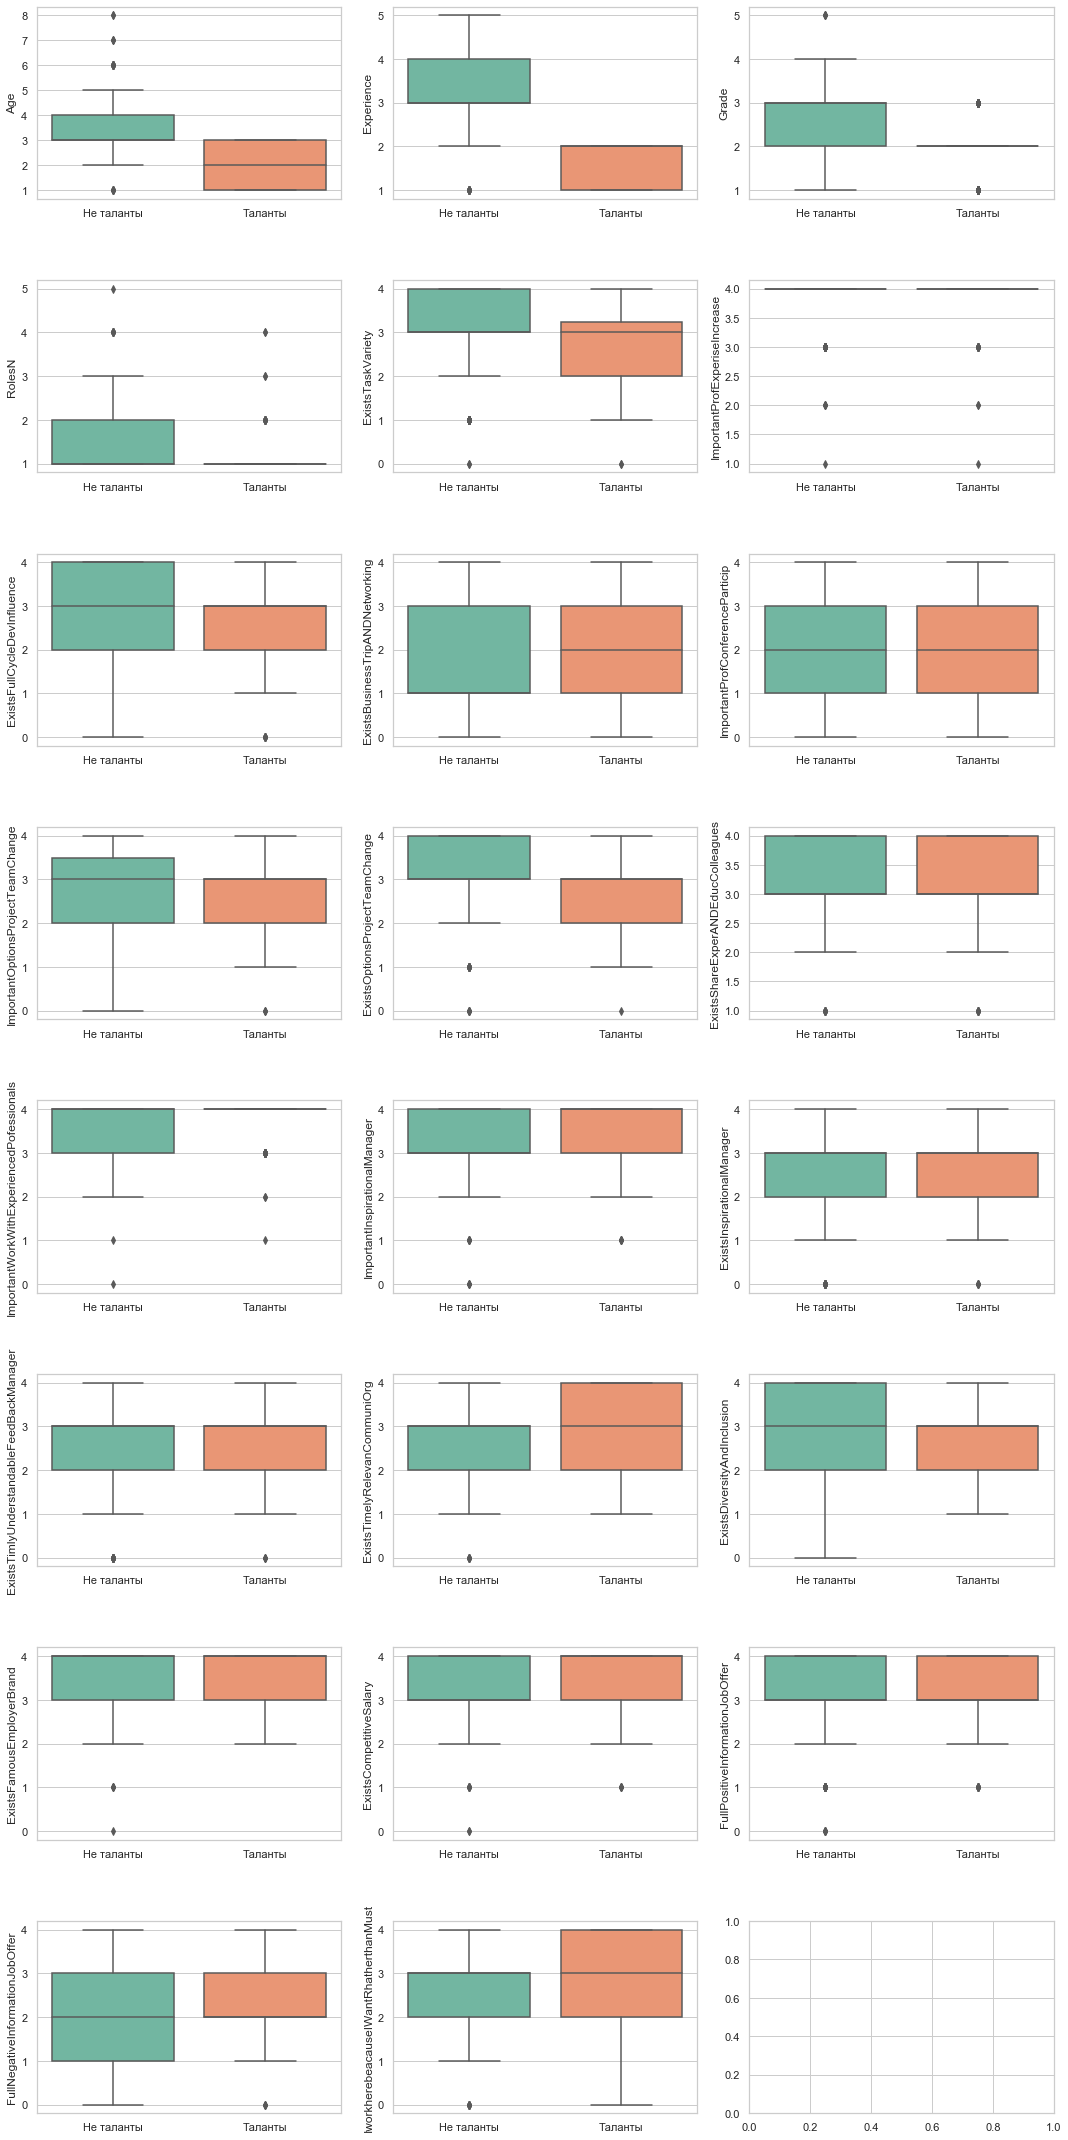

In [30]:
sns.set(style = 'whitegrid')
fig, axes = plt.subplots(round(len(df[num_sign_list].columns) / 3), 3, figsize=(15, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df[num_sign_list].columns):
        sns.boxplot(x=df['Talents'], y=df[num_sign_list].iloc[:, i], ax = ax, palette='Set2')
        ax.set_xlabel('')
        ax.set_xticklabels(labels = ['Не таланты', 'Talents'])

fig.tight_layout()

### Отрисовка барплотов по категориям

они не особо информативны здесь

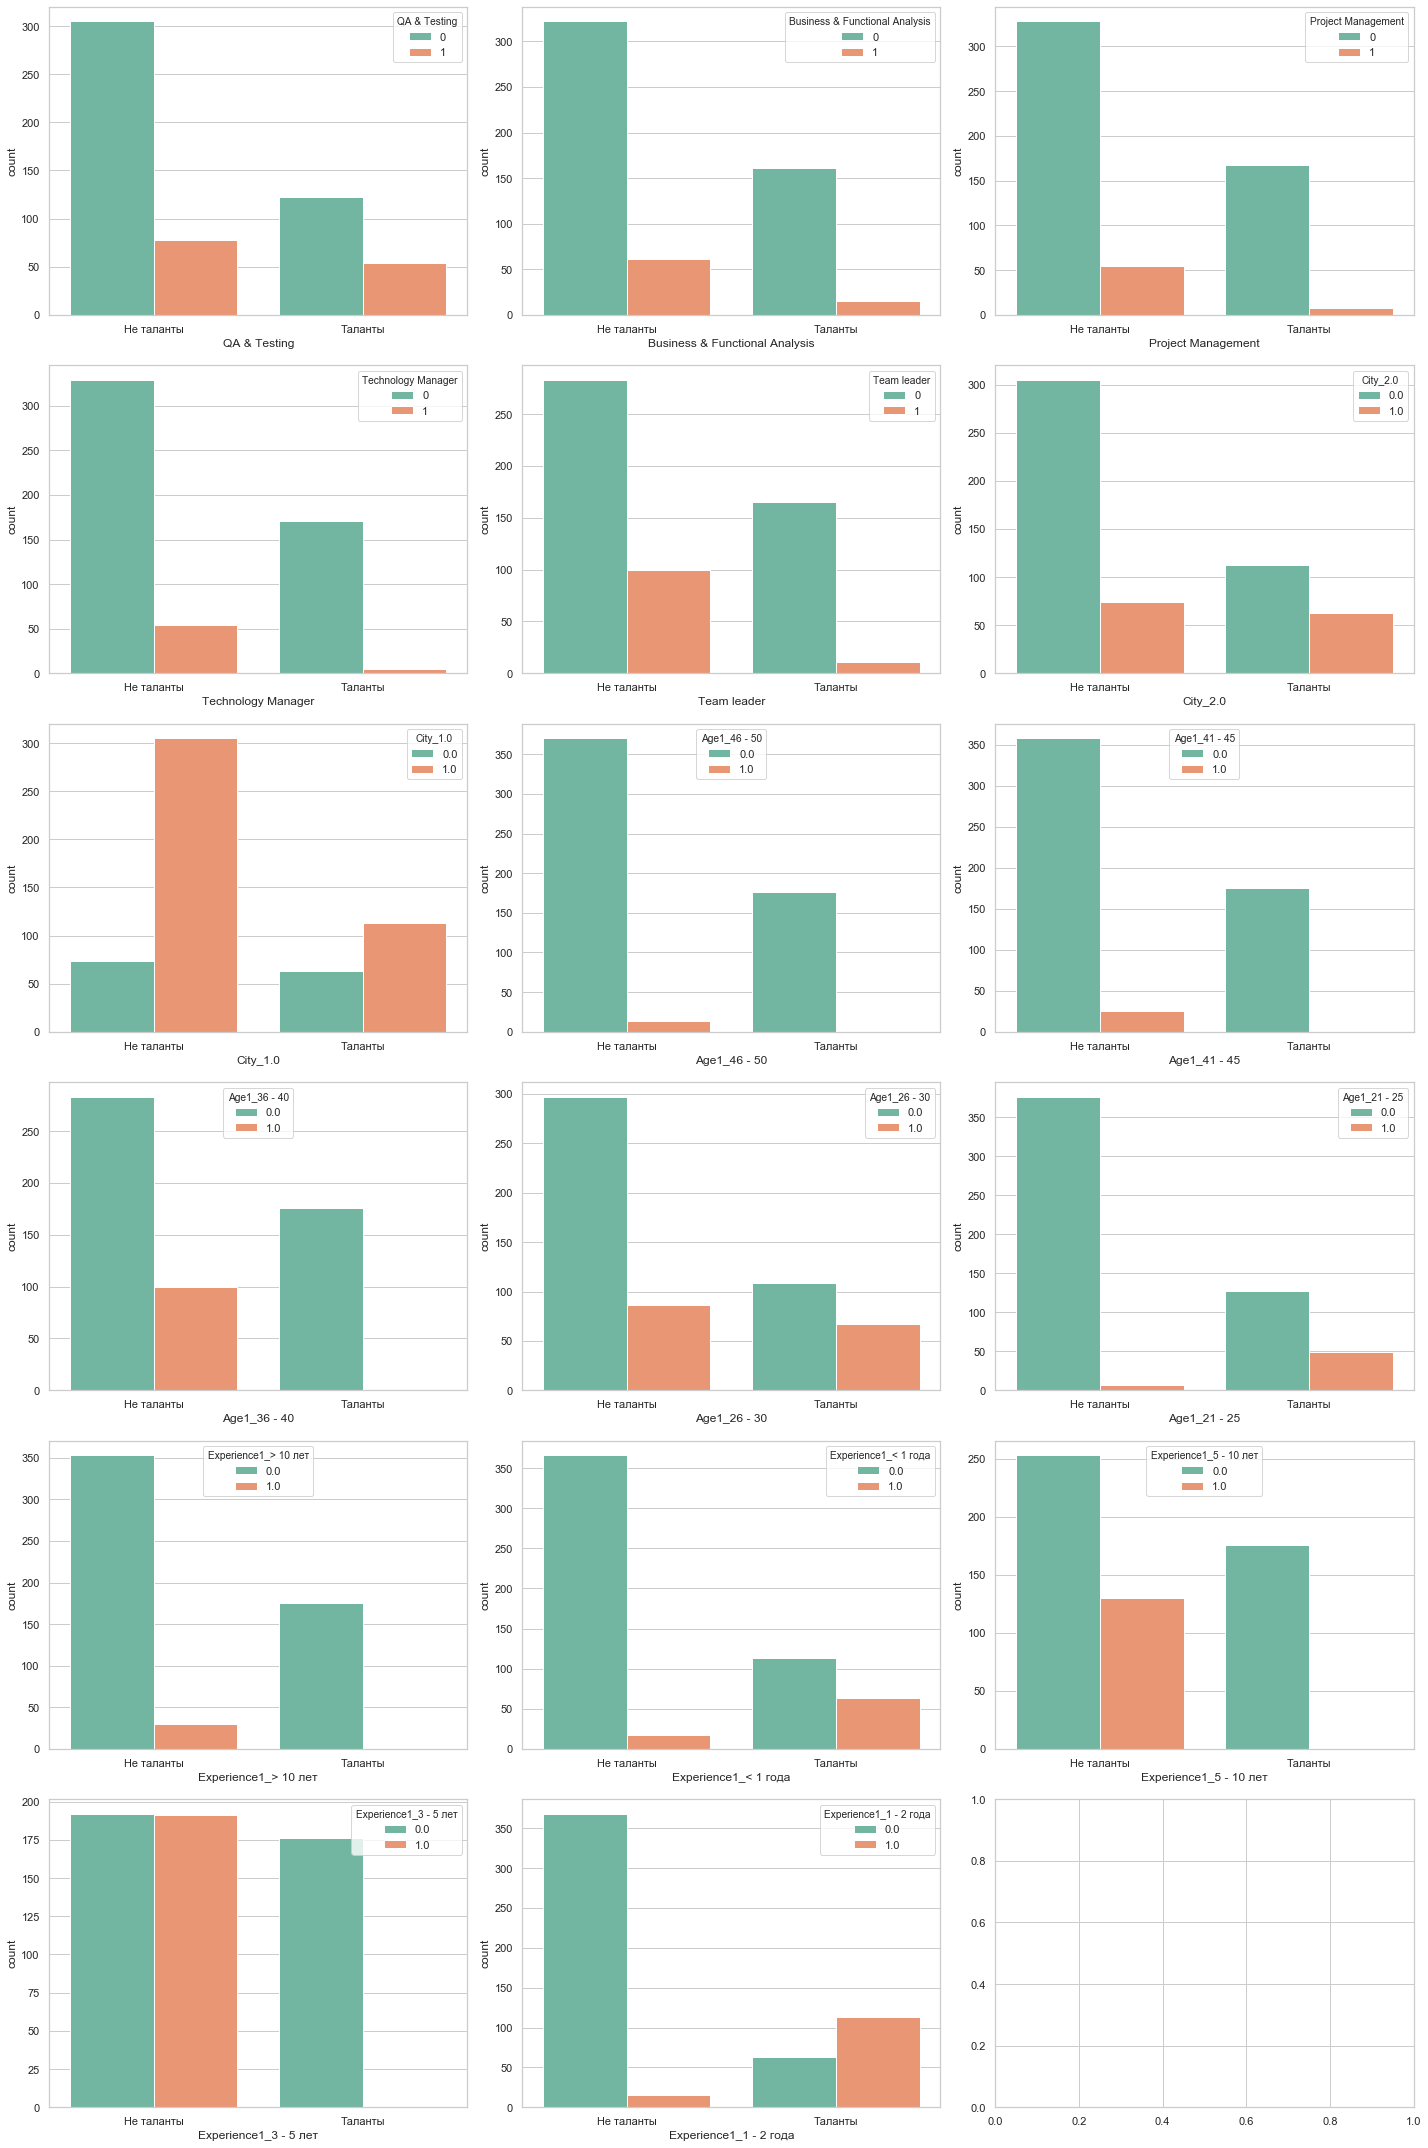

In [31]:
# создаем список категориальных значимых переменных из таблицы выше
cat_list = [x for x in df[signif_list].columns if len(pd.unique(df[signif_list][x].dropna())) < 3]

fig, axes = plt.subplots(round(len(df[cat_list].columns) / 3), 3, figsize=(20, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df[cat_list].columns):
        sns.countplot(x = 'Talents', hue = df[cat_list].iloc[:, i].name, data = df, ax = ax, palette= 'Set2')
        ax.set_xlabel(df[cat_list].iloc[:, i].name)
        ax.set_xticklabels(labels = ['Не таланты', 'Talents'])

fig.tight_layout()

### Корреляции по Спирману

только по числовым переменным

In [34]:
num_list = [x for x in df[df['Talents'] == 1].columns if len(pd.unique(df[df['Talents'] == 1][x].dropna())) > 2]

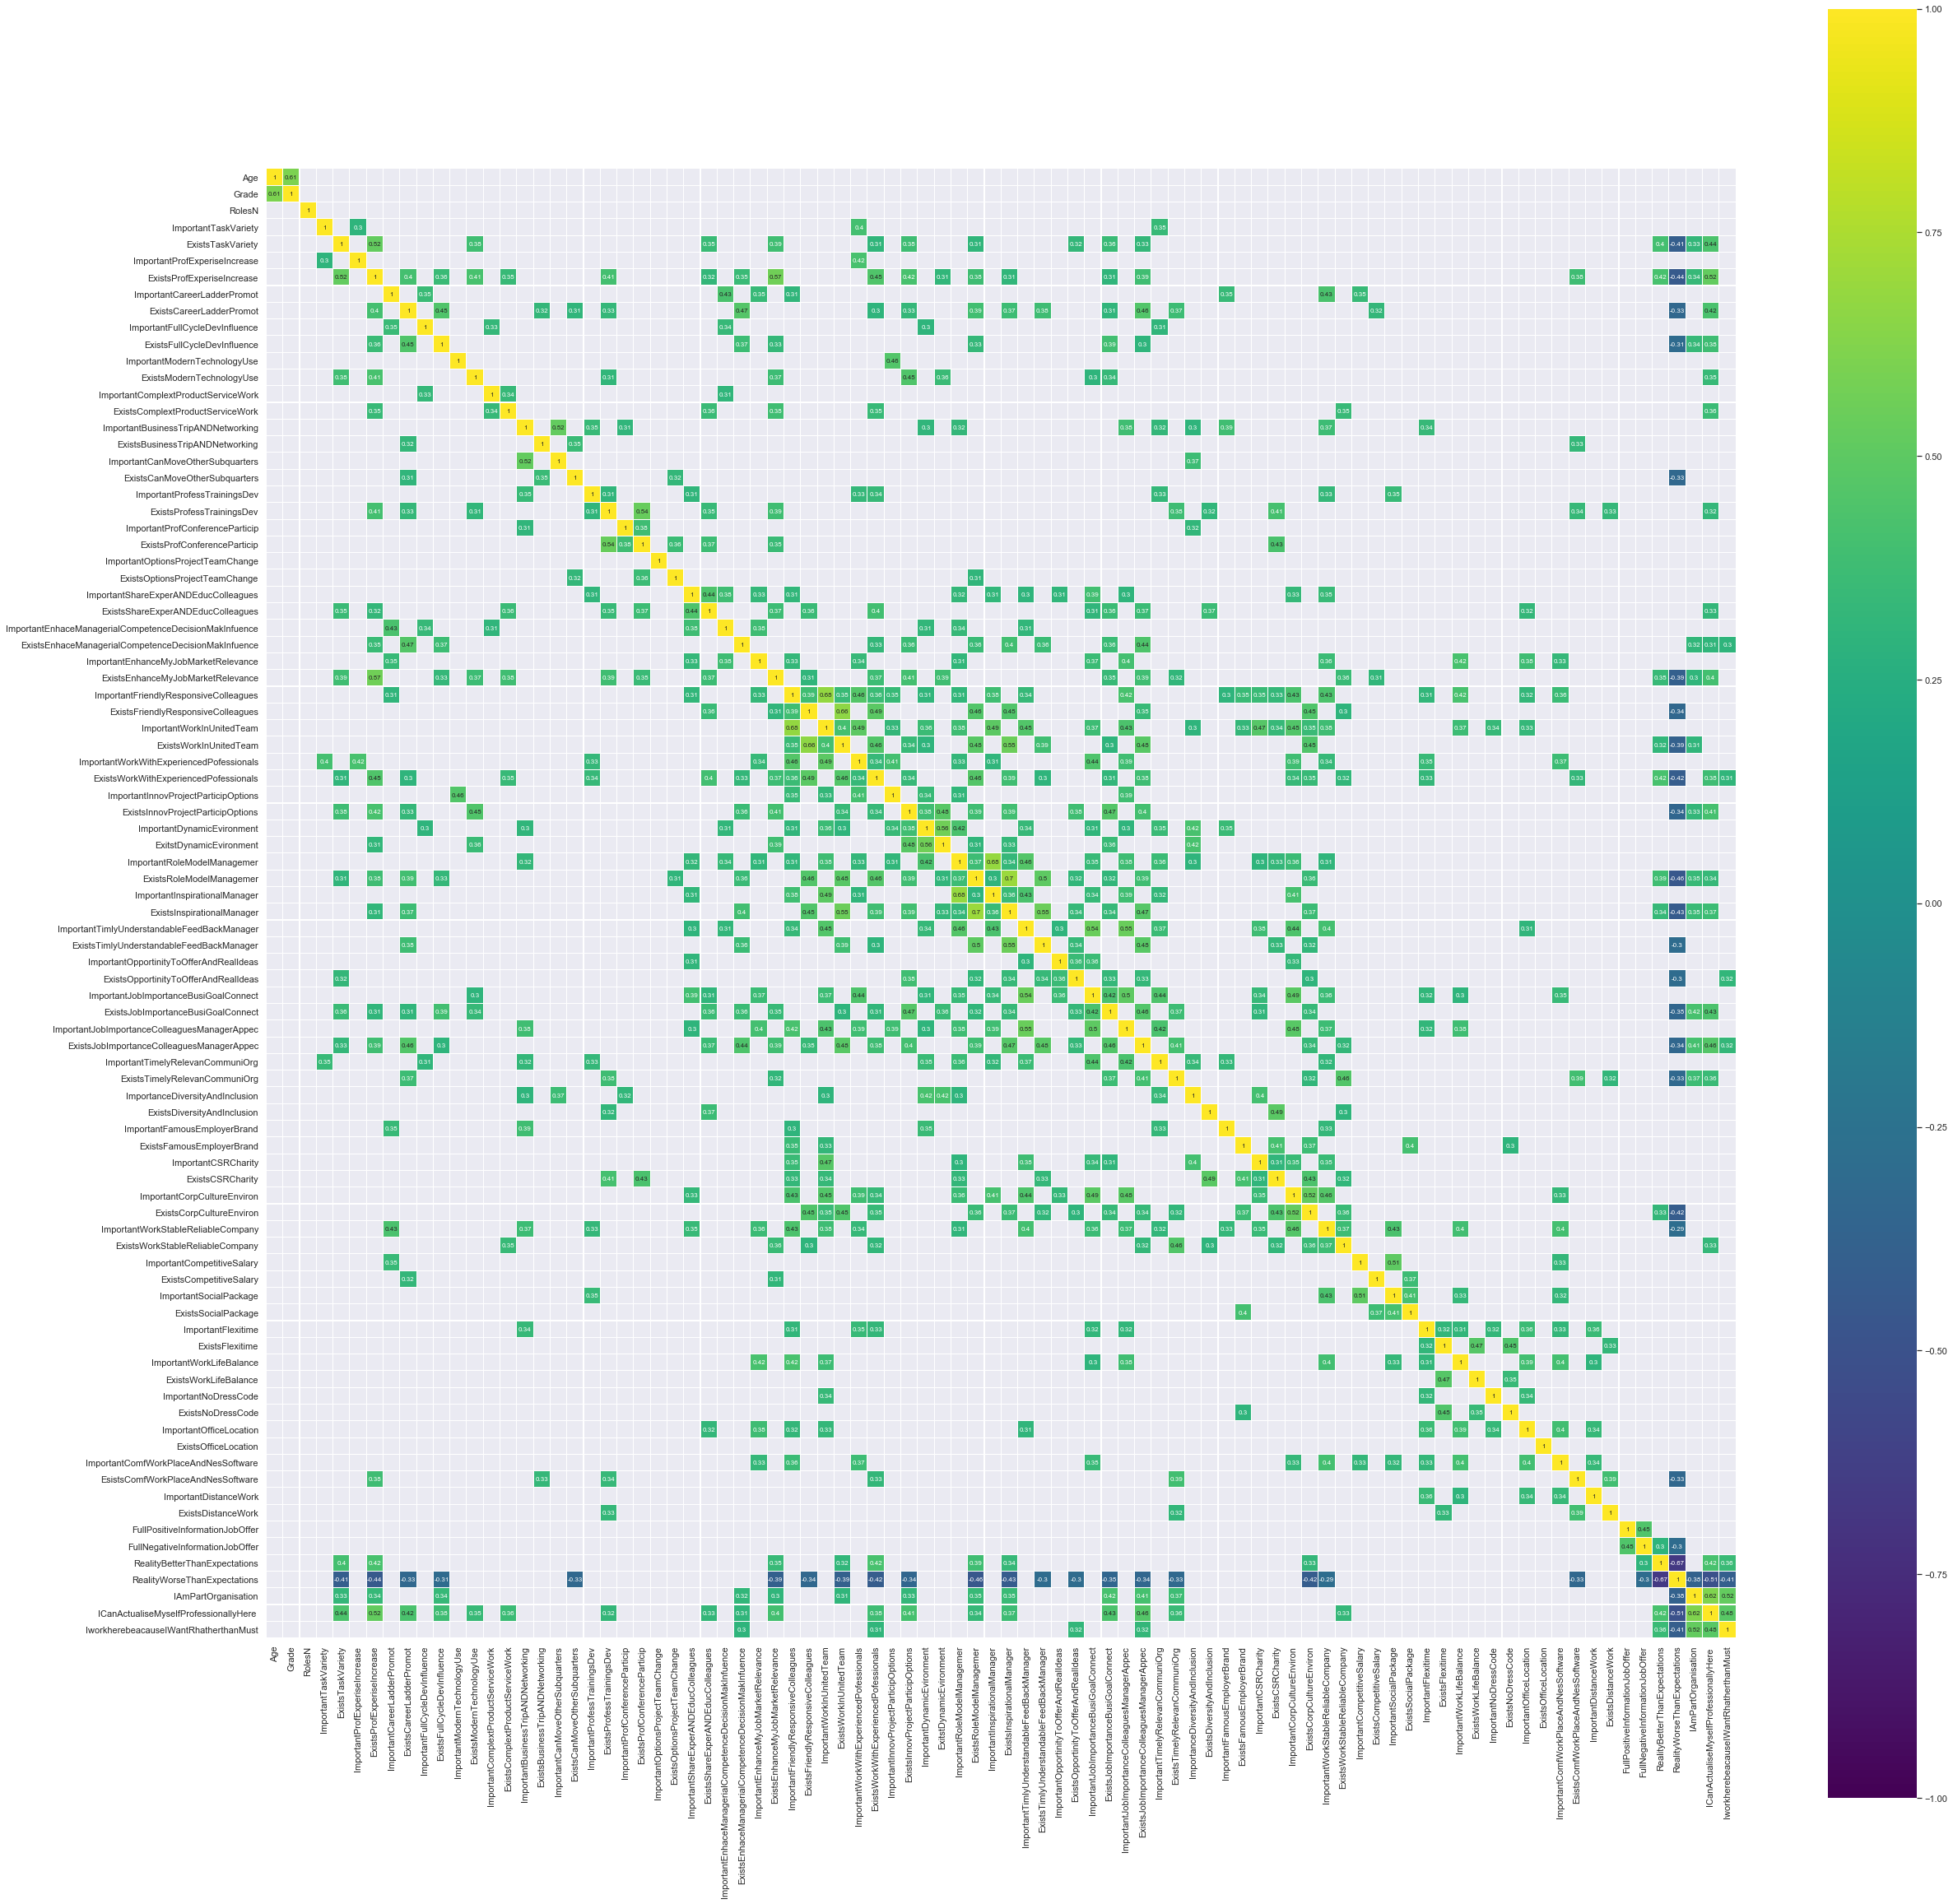

In [36]:
corr = df[num_list][df['Talents'] == 1].corr(method='spearman')

sns.set(style = 'darkgrid')

plt.figure(figsize=(40, 40))

sns.heatmap(corr[(corr >= 0.3) | (corr <= -0.29)], cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True)
plt.show()

In [37]:
corr[(corr >= 0.3) | (corr <= -0.29)]

Age     Grade  \
Age                                                 1.000000  0.607252   
Grade                                               0.607252  1.000000   
RolesN                                                   NaN       NaN   
ImportantTaskVariety                                     NaN       NaN   
ExistsTaskVariety                                        NaN       NaN   
ImportantProfExperiseIncrease                            NaN       NaN   
ExistsProfExperiseIncrease                               NaN       NaN   
ImportantCareerLadderPromot                              NaN       NaN   
ExistsCareerLadderPromot                                 NaN       NaN   
ImportantFullCycleDevInfluence                           NaN       NaN   
ExistsFullCycleDevInfluence                              NaN       NaN   
ImportantModernTechnologyUse                             NaN       NaN   
ExistsModernTechnologyUse                                NaN       NaN   
ImportantComplextProductServiceWork                      NaN       NaN   
ExistsComplextProductServiceWork                         NaN       NaN   
ImportantBusinessTripANDNetworking                       NaN       NaN   
ExistsBusinessTripANDNetworking                          NaN       NaN   
ImportantCanMoveOtherSubquarters                         NaN       NaN   
ExistsCanMoveOtherSubquarters                            NaN       NaN   
ImportantProfessTrainingsDev                             NaN       NaN   
ExistsProfessTrainingsDev                                NaN       NaN   
ImportantProfConferenceParticip                          NaN       NaN   
ExistsProfConferenceParticip                             NaN       NaN   
ImportantOptionsProjectTeamChange                        NaN       NaN   
ExistsOptionsProjectTeamChange                           NaN       NaN   
ImportantShareExperANDEducColleagues                     NaN       NaN   
ExistsShareExperANDEducColleagues                        NaN       NaN   
ImportantEnhaceManagerialCompetenceDecisionMakI...       NaN       NaN   
ExistsEnhaceManagerialCompetenceDecisionMakInfu...       NaN       NaN   
ImportantEnhanceMyJobMarketRelevance                     NaN       NaN   
ExistsEnhanceMyJobMarketRelevance                        NaN       NaN   
ImportantFriendlyResponsiveColleagues                    NaN       NaN   
ExistsFriendlyResponsiveColleagues                       NaN       NaN   
ImportantWorkInUnitedTeam                                NaN       NaN   
ExistsWorkInUnitedTeam                                   NaN       NaN   
ImportantWorkWithExperiencedPofessionals                 NaN       NaN   
ExistsWorkWithExperiencedPofessionals                    NaN       NaN   
ImportantInnovProjectParticipOptions                     NaN       NaN   
ExistsInnovProjectParticipOptions                        NaN       NaN   
ImportantDynamicEvironment                               NaN       NaN   
ExitstDynamicEvironment                                  NaN       NaN   
ImportantRoleModelManagemer                              NaN       NaN   
ExistsRoleModelManagemer                                 NaN       NaN   
ImportantInspirationalManager                            NaN       NaN   
ExistsInspirationalManager                               NaN       NaN   
ImportantTimlyUnderstandableFeedBackManager              NaN       NaN   
ExistsTimlyUnderstandableFeedBackManager                 NaN       NaN   
ImportantOpportinityToOfferAndRealIdeas                  NaN       NaN   
ExistsOpportinityToOfferAndRealIdeas                     NaN       NaN   
ImportantJobImportanceBusiGoalConnect                    NaN       NaN   
ExistsJobImportanceBusiGoalConnect                       NaN       NaN   
ImportantJobImportanceColleaguesManagerAppec             NaN       NaN   
ExistsJobImportanceColleaguesManagerAppec                NaN       NaN   
ImportantTimelyRelevanCommuniOrg                         NaN 

## Выводы по корреляциям

отметить несколько выше 0,5

## Создание таргетных переменных

Создание таргетных переменных с порогом по медиане

In [40]:
cat_list = ['RealityBetterThanExpectations', 'RealityWorseThanExpectations', 'IAmPartOrganisation', 'ICanActualiseMyselfProfessionallyHere ', 'IworkherebeacauseIWantRhatherthanMust']

df['RealityBetterThanExpectations_targ'] = (df['RealityBetterThanExpectations'] >= np.median(df['RealityBetterThanExpectations'])).astype(int)
df['RealityWorseThanExpectations_targ'] = (df['RealityWorseThanExpectations'] >= np.median(df['RealityWorseThanExpectations'])).astype(int)
df['IAmPartOrganisation_targ'] = (df['IAmPartOrganisation'] >= np.median(df['IAmPartOrganisation'])).astype(int)
df['ICanActualiseMyselfProfessionallyHere_targ'] = (df['ICanActualiseMyselfProfessionallyHere '] >= np.median(df['ICanActualiseMyselfProfessionallyHere '])).astype(int)
df['IworkherebeacauseIWantRhatherthanMust_targ'] = (df['IworkherebeacauseIWantRhatherthanMust'] >= np.median(df['IworkherebeacauseIWantRhatherthanMust'])).astype(int)


## Регрессионный анализ по всей таблице

In [38]:
def regr_onedim(df, group, adjusted = False, signif_only = False, age_col = 1, sex_col = 1, save_tab = False):

    reg_data = df.drop(columns=group)
    y = df[[group]]
    logregr = pd.DataFrame()

    if adjusted == False:
        for col in reg_data.columns:
            v = reg_data[col].name
            logit_model=sma.GLM(y,sma.add_constant(reg_data[[col]]), family = sma.families.Binomial())
            result=logit_model.fit()
            params = np.exp(result.params)[1]
            conf0 = np.exp(result.conf_int())[0][1]
            conf1 = np.exp(result.conf_int())[1][1]
            p = result.pvalues[1]
            logregr = logregr.append({'Names': v, 'OR': '{0:.2f}'.format(params), 'lower': '{0:.2f}'.format(conf0), 'upper': '{0:.2f}'.format(conf1),'p_val': p}, ignore_index=True)
            
        logregr = logregr.reindex(columns=['Names', 'OR', 'lower', 'upper', 'p_val']) 

    else:
        for col in reg_data.columns:
            v = reg_data[col].name
            logit_model=sma.GLM(y,sma.add_constant(reg_data[[col, age_col, sex_col]]), family = sma.families.Binomial())
            result=logit_model.fit()
            params = round(np.exp(result.params)[1], 2)
            conf0 = round(np.exp(result.conf_int())[0][1],2)
            conf1 = round(np.exp(result.conf_int())[1][1],2)
            p = round(result.pvalues[1], 3)
            logregr = logregr.append({'Names': v, 'OR': '{0:.2f}'.format(params), 'lower': '{0:.2f}'.format(conf0), 'upper': '{0:.2f}'.format(conf1),'p_val': p}, ignore_index=True)
        
        logregr = logregr.reindex(columns=['Names', 'OR', 'lower', 'upper', 'p_val'])[(logregr['Names'] != age_col) & (logregr['Names'] != sex_col)]


    if signif_only == True:
        logregr = logregr[logregr['p_val'] < 0.05]
    else:
        pass

    if save_tab == True:
        return pd.DataFrame.to_excel(logregr, 'Одномерный регрессионный анализ.xlsx')
    else:
        return logregr

"""
regr_multi
"""
def regr_multi(df, group, lst, save_tab = False):
    logit_model=sma.GLM(df[group],sma.add_constant(df[lst]), family = sma.families.Binomial())
    result=logit_model.fit()
    params = round(np.exp(result.params)[1:],2)
    names = params.index
    conf0 = round(np.exp(result.conf_int())[1:][0],2)
    conf1 = round(np.exp(result.conf_int())[1:][1],2)
    p = round(result.pvalues[1:],3)
    multivar = pd.DataFrame({'Names': v, 'OR': params, 'lower': conf0, 'upper': conf1,'p_val': p})
    multivar.reset_index().iloc[:, 1:]

    if save_tab == True:
        return pd.DataFrame.to_excel(multivar, 'Многомерный регрессионный анализ.xlsx')
    else:
        return multivar

### 'RealityBetterThanExpectations'

In [41]:
reg_data = df.drop(columns=['RealityBetterThanExpectations_targ', 'RealityBetterThanExpectations']).dropna()
y = df.drop(columns=[]).dropna()[['RealityBetterThanExpectations_targ']]
logregr = pd.DataFrame()

for col in reg_data.columns:
    v = reg_data[col].name
    logit_model=sma.GLM(y, sma.add_constant(reg_data[[col]]), family = sma.families.Binomial())
    result=logit_model.fit()
    params = np.exp(result.params)[1]
    conf0 = np.exp(result.conf_int())[0][1]
    conf1 = np.exp(result.conf_int())[1][1]
    p = result.pvalues[1]
    logregr = logregr.append({'Names': v, 'OR': '{0:.2f}'.format(params), 'lower': '{0:.2f}'.format(conf0), 'upper': '{0:.2f}'.format(conf1),'p_val': p}, ignore_index=True)
            
logregr = logregr.reindex(columns=['Names', 'OR', 'lower', 'upper', 'p_val']) 
logregr = logregr[logregr['p_val'] < 0.05]
logregr

C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


Names    OR lower upper  \
5                                 Software Development  0.58  0.40  0.82   
13                                ImportantTaskVariety  1.42  1.11  1.83   
14                                   ExistsTaskVariety  1.85  1.55  2.22   
15                       ImportantProfExperiseIncrease  1.66  1.13  2.44   
16                          ExistsProfExperiseIncrease  1.80  1.51  2.15   
17                         ImportantCareerLadderPromot  1.26  1.03  1.54   
18                            ExistsCareerLadderPromot  1.62  1.37  1.91   
19                      ImportantFullCycleDevInfluence  1.33  1.11  1.60   
20                         ExistsFullCycleDevInfluence  1.71  1.45  2.01   
22                           ExistsModernTechnologyUse  1.41  1.20  1.64   
23                 ImportantComplextProductServiceWork  1.45  1.19  1.76   
24                    ExistsComplextProductServiceWork  1.72  1.41  2.10   
25                  ImportantBusinessTripANDNetworking  1.23  1.03  1.45   
26                     ExistsBusinessTripANDNetworking  1.21  1.05  1.40   
28                       ExistsCanMoveOtherSubquarters  1.42  1.20  1.69   
29                        ImportantProfessTrainingsDev  1.30  1.07  1.57   
30                           ExistsProfessTrainingsDev  1.41  1.16  1.70   
32                        ExistsProfConferenceParticip  1.42  1.16  1.74   
34                      ExistsOptionsProjectTeamChange  1.50  1.23  1.82   
36                   ExistsShareExperANDEducColleagues  1.59  1.28  1.97   
37   ImportantEnhaceManagerialCompetenceDecisionMak...  1.24  1.04  1.47   
38   ExistsEnhaceManagerialCompetenceDecisionMakInf...  1.47  1.23  1.76   
39                ImportantEnhanceMyJobMarketRelevance  1.33  1.06  1.68   
40                   ExistsEnhanceMyJobMarketRelevance  1.84  1.54  2.19   
41               ImportantFriendlyResponsiveColleagues  1.41  1.06  1.89   
42                  ExistsFriendlyResponsiveColleagues  2.00  1.59  2.52   
43                           ImportantWorkInUnitedTeam  1.63  1.25  2.14   
44                              ExistsWorkInUnitedTeam  2.08  1.70  2.56   
45            ImportantWorkWithExperiencedPofessionals  1.59  1.13  2.23   
46               ExistsWorkWithExperiencedPofessionals  2.55  1.97  3.31   
48                   ExistsInnovProjectParticipOptions  1.47  1.23  1.74   
49                          ImportantDynamicEvironment  1.53  1.26  1.86   
50                             ExitstDynamicEvironment  1.82  1.50  2.21   
51                         ImportantRoleModelManagemer  1.39  1.14  1.68   
52                            ExistsRoleModelManagemer  1.97  1.65  2.35   
53                       ImportantInspirationalManager  1.45  1.18  1.80   
54                          ExistsInspirationalManager  1.94  1.62  2.32   
55         ImportantTimlyUnderstandableFeedBackManager  1.58  1.22  2.05   
56            ExistsTimlyUnderstandableFeedBackManager  1.46  1.24  1.70   
57             ImportantOpportinityToOfferAndRealIdeas  1.61  1.24  2.09   
58                ExistsOpportinityToOfferAndRealIdeas  1.69  1.40  2.05   
59               ImportantJobImportanceBusiGoalConnect  1.35  1.07  1.71   
60                  ExistsJobImportanceBusiGoalConnect  1.54  1.30  1.82   
61        ImportantJobImportanceColleaguesManagerAppec  1.42  1.10  1.83   
62           ExistsJobImportanceColleaguesManagerAppec  1.73  1.42  2.09   
64                       ExistsTimelyRelevanCommuniOrg  1.32  1.10  1.58   
66                         ExistsDiversityAndInclusion  1.40  1.13  1.73   
67                        ImportantFamousEmployerBrand  1.41  1.21  1.64   
68                           ExistsFamousEmployerBrand  1.63  1.28  2.08   
69                                 ImportantCSRCharity  1.16  1.01  1.34   
70                                    ExistsCSRCharity  1.56  1.25  1.94   
72                            ExistsCorpCultureEnviron  1.84  1.50  2.26   
73                  I

In [42]:
multi = regr_multi(df.dropna(), group = 'RealityBetterThanExpectations_targ', lst = list(logregr['Names']), save_tab = False)
multi[multi['p_val'] < 0.05].drop(columns = 'Names').sort_values('OR', ascending = False)

OR  lower  upper  p_val
RealityWorseThanExpectations_targ   4.21   1.52  11.69  0.006
Age1_21 - 25                        3.00   1.09   8.29  0.034
ImportantSocialPackage              2.05   1.20   3.52  0.009
ExitstDynamicEvironment             1.59   1.09   2.32  0.017
ExistsFullCycleDevInfluence         1.53   1.13   2.08  0.006
ImportantFamousEmployerBrand        1.46   1.09   1.97  0.011
ExistsInnovProjectParticipOptions   0.67   0.47   0.96  0.030
ImportantWorkStableReliableCompany  0.55   0.33   0.92  0.022
RealityWorseThanExpectations        0.11   0.06   0.19  0.000

## 'RealityWorseThanExpectations_targ'

In [43]:
reg_data = df.drop(columns=['RealityWorseThanExpectations_targ', 'RealityWorseThanExpectations']).dropna()
y = df.drop(columns=[]).dropna()[['RealityWorseThanExpectations_targ']]
logregr = pd.DataFrame()

for col in reg_data.columns:
    v = reg_data[col].name
    logit_model=sma.GLM(y, sma.add_constant(reg_data[[col]]), family = sma.families.Binomial())
    result=logit_model.fit()
    params = np.exp(result.params)[1]
    conf0 = np.exp(result.conf_int())[0][1]
    conf1 = np.exp(result.conf_int())[1][1]
    p = result.pvalues[1]
    logregr = logregr.append({'Names': v, 'OR': '{0:.2f}'.format(params), 'lower': '{0:.2f}'.format(conf0), 'upper': '{0:.2f}'.format(conf1),'p_val': p}, ignore_index=True)
            
logregr = logregr.reindex(columns=['Names', 'OR', 'lower', 'upper', 'p_val']) 
logregr = logregr[logregr['p_val'] < 0.05]
logregr

C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


Names    OR lower upper  \
5                                 Software Development  1.68  1.17  2.40   
6                                         QA & Testing  0.64  0.43  0.96   
12                                         Team leader  0.62  0.40  0.95   
13                                ImportantTaskVariety  0.64  0.48  0.85   
14                                   ExistsTaskVariety  0.48  0.38  0.59   
15                       ImportantProfExperiseIncrease  0.49  0.31  0.79   
16                          ExistsProfExperiseIncrease  0.55  0.44  0.67   
17                         ImportantCareerLadderPromot  0.71  0.57  0.90   
18                            ExistsCareerLadderPromot  0.59  0.50  0.71   
19                      ImportantFullCycleDevInfluence  0.81  0.67  1.00   
20                         ExistsFullCycleDevInfluence  0.58  0.49  0.69   
22                           ExistsModernTechnologyUse  0.70  0.59  0.82   
24                    ExistsComplextProductServiceWork  0.65  0.52  0.81   
25                  ImportantBusinessTripANDNetworking  0.75  0.62  0.91   
26                     ExistsBusinessTripANDNetworking  0.80  0.69  0.93   
28                       ExistsCanMoveOtherSubquarters  0.69  0.57  0.83   
29                        ImportantProfessTrainingsDev  0.69  0.55  0.86   
30                           ExistsProfessTrainingsDev  0.64  0.51  0.80   
32                        ExistsProfConferenceParticip  0.69  0.55  0.86   
34                      ExistsOptionsProjectTeamChange  0.64  0.52  0.79   
36                   ExistsShareExperANDEducColleagues  0.64  0.51  0.82   
37   ImportantEnhaceManagerialCompetenceDecisionMak...  0.77  0.63  0.93   
38   ExistsEnhaceManagerialCompetenceDecisionMakInf...  0.66  0.54  0.80   
39                ImportantEnhanceMyJobMarketRelevance  0.69  0.53  0.90   
40                   ExistsEnhanceMyJobMarketRelevance  0.52  0.43  0.64   
41               ImportantFriendlyResponsiveColleagues  0.50  0.35  0.72   
42                  ExistsFriendlyResponsiveColleagues  0.51  0.39  0.67   
43                           ImportantWorkInUnitedTeam  0.51  0.37  0.71   
44                              ExistsWorkInUnitedTeam  0.45  0.36  0.58   
45            ImportantWorkWithExperiencedPofessionals  0.34  0.21  0.54   
46               ExistsWorkWithExperiencedPofessionals  0.42  0.32  0.57   
48                   ExistsInnovProjectParticipOptions  0.63  0.53  0.76   
49                          ImportantDynamicEvironment  0.60  0.49  0.73   
50                             ExitstDynamicEvironment  0.50  0.41  0.61   
51                         ImportantRoleModelManagemer  0.62  0.49  0.78   
52                            ExistsRoleModelManagemer  0.53  0.44  0.64   
53                       ImportantInspirationalManager  0.59  0.46  0.76   
54                          ExistsInspirationalManager  0.54  0.45  0.66   
55         ImportantTimlyUnderstandableFeedBackManager  0.58  0.43  0.78   
56            ExistsTimlyUnderstandableFeedBackManager  0.60  0.51  0.72   
57             ImportantOpportinityToOfferAndRealIdeas  0.63  0.47  0.84   
58                ExistsOpportinityToOfferAndRealIdeas  0.53  0.42  0.66   
59               ImportantJobImportanceBusiGoalConnect  0.65  0.50  0.85   
60                  ExistsJobImportanceBusiGoalConnect  0.58  0.48  0.70   
61        ImportantJobImportanceColleaguesManagerAppec  0.60  0.44  0.80   
62           ExistsJobImportanceColleaguesManagerAppec  0.49  0.39  0.61   
63                    ImportantTimelyRelevanCommuniOrg  0.70  0.57  0.86   
64                       ExistsTimelyRelevanCommuniOrg  0.59  0.48  0.73   
66                         ExistsDiversityAndInclusion  0.65  0.52  0.81   
67                        ImportantFamousEmployerBrand  0.77  0.65  0.90   
68                           ExistsFamousEmployerBrand  0.41  0.30  0.56   
70                                    ExistsCSRCharity  0.59  0.47  0.75   
71                   

In [44]:
multi = regr_multi(df.dropna(), group = 'RealityWorseThanExpectations_targ', lst = list(logregr['Names']), save_tab = False)
multi[multi['p_val'] < 0.05].drop(columns = 'Names').sort_values('OR', ascending = False)

OR  lower  upper  p_val
RealityBetterThanExpectations_targ                  8.63   2.50  29.77  0.001
ExistsComplextProductServiceWork                    1.63   1.07   2.48  0.022
ExistsEnhaceManagerialCompetenceDecisionMakInfu...  1.63   1.09   2.45  0.018
ImportantFullCycleDevInfluence                      1.54   1.04   2.28  0.030
ImportantFamousEmployerBrand                        1.50   1.08   2.07  0.014
ExistsTaskVariety                                   0.67   0.45   0.98  0.039
ExistsFullCycleDevInfluence                         0.56   0.40   0.79  0.001
Age1_31 - 35                                        0.53   0.29   0.98  0.041
ExistsCorpCultureEnviron                            0.52   0.31   0.89  0.016
ExistsFamousEmployerBrand                           0.48   0.29   0.79  0.004
ImportantWorkWithExperiencedPofessionals            0.32   0.15   0.71  0.005
RealityBetterThanExpectations                       0.07   0.03   0.16  0.000

### 'IAmPartOrganisation_targ'

In [45]:
reg_data = df.drop(columns=['IAmPartOrganisation_targ', 'IAmPartOrganisation']).dropna()
y = df.drop(columns=[]).dropna()[['IAmPartOrganisation_targ']]
logregr = pd.DataFrame()

for col in reg_data.columns:
    v = reg_data[col].name
    logit_model=sma.GLM(y, sma.add_constant(reg_data[[col]]), family = sma.families.Binomial())
    result=logit_model.fit()
    params = np.exp(result.params)[1]
    conf0 = np.exp(result.conf_int())[0][1]
    conf1 = np.exp(result.conf_int())[1][1]
    p = result.pvalues[1]
    logregr = logregr.append({'Names': v, 'OR': '{0:.2f}'.format(params), 'lower': '{0:.2f}'.format(conf0), 'upper': '{0:.2f}'.format(conf1),'p_val': p}, ignore_index=True)
            
logregr = logregr.reindex(columns=['Names', 'OR', 'lower', 'upper', 'p_val']) 
logregr = logregr[logregr['p_val'] < 0.05]
logregr

C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


Names    OR lower upper  \
12                                         Team leader  2.31  1.38  3.86   
14                                   ExistsTaskVariety  1.68  1.41  2.01   
15                       ImportantProfExperiseIncrease  2.02  1.37  2.98   
16                          ExistsProfExperiseIncrease  1.66  1.40  1.97   
17                         ImportantCareerLadderPromot  1.65  1.34  2.04   
18                            ExistsCareerLadderPromot  1.54  1.30  1.84   
19                      ImportantFullCycleDevInfluence  1.34  1.11  1.62   
20                         ExistsFullCycleDevInfluence  1.40  1.19  1.64   
22                           ExistsModernTechnologyUse  1.40  1.19  1.65   
23                 ImportantComplextProductServiceWork  1.24  1.02  1.52   
24                    ExistsComplextProductServiceWork  1.36  1.12  1.66   
25                  ImportantBusinessTripANDNetworking  1.19  1.00  1.42   
26                     ExistsBusinessTripANDNetworking  1.43  1.23  1.67   
28                       ExistsCanMoveOtherSubquarters  1.44  1.20  1.72   
29                        ImportantProfessTrainingsDev  1.30  1.07  1.58   
30                           ExistsProfessTrainingsDev  1.24  1.03  1.50   
31                     ImportantProfConferenceParticip  1.23  1.04  1.44   
32                        ExistsProfConferenceParticip  1.38  1.12  1.71   
34                      ExistsOptionsProjectTeamChange  1.49  1.22  1.82   
35                ImportantShareExperANDEducColleagues  1.33  1.09  1.61   
36                   ExistsShareExperANDEducColleagues  1.69  1.35  2.12   
37   ImportantEnhaceManagerialCompetenceDecisionMak...  1.49  1.24  1.79   
38   ExistsEnhaceManagerialCompetenceDecisionMakInf...  1.78  1.47  2.17   
39                ImportantEnhanceMyJobMarketRelevance  1.29  1.02  1.64   
40                   ExistsEnhanceMyJobMarketRelevance  1.48  1.25  1.76   
42                  ExistsFriendlyResponsiveColleagues  1.73  1.39  2.15   
43                           ImportantWorkInUnitedTeam  1.49  1.14  1.95   
44                              ExistsWorkInUnitedTeam  1.81  1.48  2.20   
46               ExistsWorkWithExperiencedPofessionals  1.83  1.45  2.30   
48                   ExistsInnovProjectParticipOptions  1.63  1.36  1.97   
49                          ImportantDynamicEvironment  1.56  1.27  1.92   
50                             ExitstDynamicEvironment  1.68  1.38  2.04   
51                         ImportantRoleModelManagemer  1.34  1.10  1.63   
52                            ExistsRoleModelManagemer  1.72  1.44  2.04   
53                       ImportantInspirationalManager  1.31  1.06  1.63   
54                          ExistsInspirationalManager  1.99  1.65  2.39   
55         ImportantTimlyUnderstandableFeedBackManager  1.46  1.12  1.90   
56            ExistsTimlyUnderstandableFeedBackManager  1.59  1.35  1.88   
57             ImportantOpportinityToOfferAndRealIdeas  1.35  1.04  1.75   
58                ExistsOpportinityToOfferAndRealIdeas  1.60  1.32  1.94   
59               ImportantJobImportanceBusiGoalConnect  1.47  1.16  1.87   
60                  ExistsJobImportanceBusiGoalConnect  2.02  1.68  2.43   
61        ImportantJobImportanceColleaguesManagerAppec  1.50  1.16  1.95   
62           ExistsJobImportanceColleaguesManagerAppec  2.18  1.76  2.69   
63                    ImportantTimelyRelevanCommuniOrg  1.37  1.13  1.67   
64                       ExistsTimelyRelevanCommuniOrg  2.15  1.75  2.65   
65                     ImportanceDiversityAndInclusion  1.20  1.03  1.40   
66                         ExistsDiversityAndInclusion  1.67  1.33  2.10   
67                        ImportantFamousEmployerBrand  1.41  1.21  1.65   
68                           ExistsFamousEmployerBrand  1.65  1.29  2.11   
69                                 ImportantCSRCharity  1.23  1.06  1.42   
70                                    ExistsCSRCharity  1.52  1.21  1.90   
72                   

In [46]:
multi = regr_multi(df.dropna(), group = 'IAmPartOrganisation_targ', lst = list(logregr['Names']), save_tab = False)
multi[multi['p_val'] < 0.05].drop(columns = 'Names').sort_values('OR', ascending = False)

OR  lower  upper  p_val
ICanActualiseMyselfProfessionallyHere    3.73   1.87   7.44  0.000
Team leader                              2.59   1.09   6.19  0.032
ImportantCareerLadderPromot              1.82   1.21   2.74  0.004
ExistsTimelyRelevanCommuniOrg            1.74   1.23   2.48  0.002
ExistsInspirationalManager               1.73   1.08   2.76  0.023
ExistsDiversityAndInclusion              1.49   1.01   2.22  0.047
ExistsDistanceWork                       1.35   1.03   1.78  0.031
ExistsModernTechnologyUse                0.68   0.49   0.94  0.021
ExistsEnhanceMyJobMarketRelevance        0.67   0.48   0.93  0.016
ExistsComplextProductServiceWork         0.66   0.46   0.95  0.025
ExistsProfessTrainingsDev                0.55   0.37   0.81  0.002
ImportantOpportinityToOfferAndRealIdeas  0.54   0.32   0.91  0.021

### 'ICanActualiseMyselfProfessionallyHere_targ'

In [48]:
reg_data = df.drop(columns=['ICanActualiseMyselfProfessionallyHere_targ', 'ICanActualiseMyselfProfessionallyHere ']).dropna()
y = df.drop(columns=[]).dropna()[['ICanActualiseMyselfProfessionallyHere_targ']]
logregr = pd.DataFrame()

for col in reg_data.columns:
    v = reg_data[col].name
    logit_model=sma.GLM(y, sma.add_constant(reg_data[[col]]), family = sma.families.Binomial())
    result=logit_model.fit()
    params = np.exp(result.params)[1]
    conf0 = np.exp(result.conf_int())[0][1]
    conf1 = np.exp(result.conf_int())[1][1]
    p = result.pvalues[1]
    logregr = logregr.append({'Names': v, 'OR': '{0:.2f}'.format(params), 'lower': '{0:.2f}'.format(conf0), 'upper': '{0:.2f}'.format(conf1),'p_val': p}, ignore_index=True)
            
logregr = logregr.reindex(columns=['Names', 'OR', 'lower', 'upper', 'p_val']) 
logregr = logregr[logregr['p_val'] < 0.05]
logregr

C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


Names    OR lower upper  \
3                                                Grade  1.27  1.00  1.62   
12                                         Team leader  2.15  1.26  3.67   
14                                   ExistsTaskVariety  2.55  2.08  3.12   
15                       ImportantProfExperiseIncrease  1.71  1.16  2.52   
16                          ExistsProfExperiseIncrease  3.00  2.41  3.72   
18                            ExistsCareerLadderPromot  2.13  1.75  2.60   
19                      ImportantFullCycleDevInfluence  1.24  1.02  1.51   
20                         ExistsFullCycleDevInfluence  1.61  1.36  1.91   
22                           ExistsModernTechnologyUse  1.88  1.58  2.25   
23                 ImportantComplextProductServiceWork  1.25  1.02  1.53   
24                    ExistsComplextProductServiceWork  2.10  1.70  2.60   
26                     ExistsBusinessTripANDNetworking  1.28  1.10  1.50   
28                       ExistsCanMoveOtherSubquarters  1.42  1.18  1.71   
29                        ImportantProfessTrainingsDev  1.31  1.08  1.60   
30                           ExistsProfessTrainingsDev  1.67  1.36  2.04   
31                     ImportantProfConferenceParticip  1.20  1.01  1.42   
32                        ExistsProfConferenceParticip  1.49  1.20  1.85   
34                      ExistsOptionsProjectTeamChange  1.49  1.21  1.83   
36                   ExistsShareExperANDEducColleagues  1.92  1.52  2.43   
37   ImportantEnhaceManagerialCompetenceDecisionMak...  1.23  1.02  1.48   
38   ExistsEnhaceManagerialCompetenceDecisionMakInf...  1.93  1.57  2.37   
40                   ExistsEnhanceMyJobMarketRelevance  2.26  1.85  2.76   
42                  ExistsFriendlyResponsiveColleagues  1.38  1.12  1.71   
44                              ExistsWorkInUnitedTeam  1.48  1.22  1.80   
46               ExistsWorkWithExperiencedPofessionals  2.52  1.95  3.25   
48                   ExistsInnovProjectParticipOptions  2.04  1.66  2.50   
49                          ImportantDynamicEvironment  1.41  1.14  1.73   
50                             ExitstDynamicEvironment  1.74  1.42  2.14   
52                            ExistsRoleModelManagemer  2.09  1.73  2.53   
54                          ExistsInspirationalManager  2.13  1.76  2.58   
56            ExistsTimlyUnderstandableFeedBackManager  1.83  1.54  2.18   
57             ImportantOpportinityToOfferAndRealIdeas  1.37  1.05  1.80   
58                ExistsOpportinityToOfferAndRealIdeas  1.92  1.56  2.35   
60                  ExistsJobImportanceBusiGoalConnect  2.28  1.87  2.77   
61        ImportantJobImportanceColleaguesManagerAppec  1.60  1.22  2.08   
62           ExistsJobImportanceColleaguesManagerAppec  2.58  2.05  3.25   
63                    ImportantTimelyRelevanCommuniOrg  1.32  1.08  1.61   
64                       ExistsTimelyRelevanCommuniOrg  1.74  1.43  2.13   
65                     ImportanceDiversityAndInclusion  1.18  1.01  1.38   
66                         ExistsDiversityAndInclusion  1.42  1.13  1.79   
67                        ImportantFamousEmployerBrand  1.39  1.19  1.64   
68                           ExistsFamousEmployerBrand  1.49  1.16  1.91   
69                                 ImportantCSRCharity  1.19  1.02  1.39   
70                                    ExistsCSRCharity  1.48  1.17  1.86   
71                         ImportantCorpCultureEnviron  1.43  1.11  1.85   
72                            ExistsCorpCultureEnviron  1.85  1.50  2.28   
73                  ImportantWorkStableReliableCompany  2.03  1.54  2.68   
74                     ExistsWorkStableReliableCompany  2.18  1.71  2.79   
75                          ImportantCompetitiveSalary  1.89  1.21  2.96   
76                             ExistsCompetitiveSalary  1.52  1.20  1.93   
78                                 ExistsSocialPackage  1.75  1.23  2.49   
82                               ExistsWorkLifeBalance  1.26  1.07  1.48   
86                   

In [50]:
multi = regr_multi(df.dropna(), group = 'ICanActualiseMyselfProfessionallyHere_targ', lst = list(logregr['Names']), save_tab = False)
multi[multi['p_val'] < 0.05].drop(columns = 'Names').sort_values('OR', ascending = False)

OR  lower  upper  p_val
Team leader                         3.44   1.19   9.93  0.022
ExistsProfExperiseIncrease          1.92   1.29   2.86  0.001
ExistsTaskVariety                   1.54   1.08   2.18  0.017
ExistsDistanceWork                  0.67   0.49   0.92  0.014
ExistsFriendlyResponsiveColleagues  0.61   0.38   0.97  0.038
ExistsWorkInUnitedTeam              0.61   0.38   0.97  0.038

### 'IworkherebeacauseIWantRhatherthanMust_targ'

In [51]:
reg_data = df.drop(columns=['IworkherebeacauseIWantRhatherthanMust_targ', 'IworkherebeacauseIWantRhatherthanMust']).dropna()
y = df.drop(columns=[]).dropna()[['IworkherebeacauseIWantRhatherthanMust_targ']]
logregr = pd.DataFrame()

for col in reg_data.columns:
    v = reg_data[col].name
    logit_model=sma.GLM(y, sma.add_constant(reg_data[[col]]), family = sma.families.Binomial())
    result=logit_model.fit()
    params = np.exp(result.params)[1]
    conf0 = np.exp(result.conf_int())[0][1]
    conf1 = np.exp(result.conf_int())[1][1]
    p = result.pvalues[1]
    logregr = logregr.append({'Names': v, 'OR': '{0:.2f}'.format(params), 'lower': '{0:.2f}'.format(conf0), 'upper': '{0:.2f}'.format(conf1),'p_val': p}, ignore_index=True)
            
logregr = logregr.reindex(columns=['Names', 'OR', 'lower', 'upper', 'p_val']) 
logregr = logregr[logregr['p_val'] < 0.05]
logregr

C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


Names    OR lower upper  \
13                                ImportantTaskVariety  1.38  1.07  1.78   
14                                   ExistsTaskVariety  1.86  1.55  2.23   
15                       ImportantProfExperiseIncrease  1.84  1.25  2.70   
16                          ExistsProfExperiseIncrease  1.85  1.55  2.21   
18                            ExistsCareerLadderPromot  1.58  1.33  1.87   
19                      ImportantFullCycleDevInfluence  1.25  1.04  1.51   
20                         ExistsFullCycleDevInfluence  1.53  1.30  1.80   
22                           ExistsModernTechnologyUse  1.54  1.31  1.81   
23                 ImportantComplextProductServiceWork  1.39  1.14  1.69   
24                    ExistsComplextProductServiceWork  1.77  1.45  2.16   
26                     ExistsBusinessTripANDNetworking  1.29  1.11  1.49   
28                       ExistsCanMoveOtherSubquarters  1.28  1.08  1.52   
29                        ImportantProfessTrainingsDev  1.27  1.05  1.54   
30                           ExistsProfessTrainingsDev  1.39  1.15  1.68   
31                     ImportantProfConferenceParticip  1.19  1.01  1.39   
34                      ExistsOptionsProjectTeamChange  1.39  1.14  1.69   
36                   ExistsShareExperANDEducColleagues  1.71  1.37  2.14   
37   ImportantEnhaceManagerialCompetenceDecisionMak...  1.28  1.07  1.52   
38   ExistsEnhaceManagerialCompetenceDecisionMakInf...  1.63  1.35  1.97   
40                   ExistsEnhanceMyJobMarketRelevance  1.79  1.50  2.14   
42                  ExistsFriendlyResponsiveColleagues  1.74  1.40  2.17   
43                           ImportantWorkInUnitedTeam  1.43  1.09  1.87   
44                              ExistsWorkInUnitedTeam  1.91  1.57  2.34   
46               ExistsWorkWithExperiencedPofessionals  2.06  1.63  2.62   
48                   ExistsInnovProjectParticipOptions  1.73  1.44  2.09   
49                          ImportantDynamicEvironment  1.57  1.29  1.92   
50                             ExitstDynamicEvironment  1.63  1.34  1.97   
52                            ExistsRoleModelManagemer  1.85  1.56  2.21   
54                          ExistsInspirationalManager  1.90  1.59  2.28   
55         ImportantTimlyUnderstandableFeedBackManager  1.48  1.14  1.92   
56            ExistsTimlyUnderstandableFeedBackManager  1.47  1.26  1.73   
57             ImportantOpportinityToOfferAndRealIdeas  1.63  1.26  2.12   
58                ExistsOpportinityToOfferAndRealIdeas  1.86  1.53  2.27   
59               ImportantJobImportanceBusiGoalConnect  1.38  1.09  1.74   
60                  ExistsJobImportanceBusiGoalConnect  1.84  1.54  2.19   
62           ExistsJobImportanceColleaguesManagerAppec  1.82  1.49  2.21   
63                    ImportantTimelyRelevanCommuniOrg  1.22  1.01  1.47   
64                       ExistsTimelyRelevanCommuniOrg  1.56  1.29  1.88   
65                     ImportanceDiversityAndInclusion  1.26  1.09  1.47   
67                        ImportantFamousEmployerBrand  1.48  1.27  1.73   
68                           ExistsFamousEmployerBrand  1.47  1.15  1.87   
69                                 ImportantCSRCharity  1.31  1.13  1.52   
70                                    ExistsCSRCharity  1.40  1.13  1.75   
71                         ImportantCorpCultureEnviron  1.52  1.19  1.94   
72                            ExistsCorpCultureEnviron  1.77  1.44  2.17   
73                  ImportantWorkStableReliableCompany  1.52  1.17  1.98   
74                     ExistsWorkStableReliableCompany  1.58  1.26  1.97   
78                                 ExistsSocialPackage  1.70  1.20  2.41   
82                               ExistsWorkLifeBalance  1.26  1.08  1.47   
84                                   ExistsNoDressCode  1.48  1.17  1.87   
86                                ExistsOfficeLocation  1.37  1.15  1.64   
88                   EsistsComfWorkPlaceAndNesSoftware  1.38  1.19  1.60   
90                   

In [52]:
multi = regr_multi(df.dropna(), group = 'IworkherebeacauseIWantRhatherthanMust_targ', lst = list(logregr['Names']), save_tab = False)
multi[multi['p_val'] < 0.05].drop(columns = 'Names').sort_values('OR', ascending = False)

OR  lower  upper  p_val
IAmPartOrganisation                      2.11   1.15   3.89  0.016
ImportantOpportinityToOfferAndRealIdeas  1.54   1.02   2.34  0.040
Experience1_3 - 5 лет                    0.58   0.35   0.98  0.043

## Регрессии только по талантам

In [53]:
Talents = df[df['Talents'] == 1].drop(columns = 'Talents')

## 'RealityBetterThanExpectations_targ'

In [54]:
reg_data = Talents.drop(columns=['RealityBetterThanExpectations_targ', 'RealityBetterThanExpectations']).dropna()
y = Talents.dropna()[['RealityBetterThanExpectations_targ']]
logregr = pd.DataFrame()

for col in reg_data.columns:
    v = reg_data[col].name
    logit_model=sma.GLM(y, sma.add_constant(reg_data[[col]]), family = sma.families.Binomial())
    result=logit_model.fit()
    params = np.exp(result.params)[1]
    conf0 = np.exp(result.conf_int())[0][1]
    conf1 = np.exp(result.conf_int())[1][1]
    p = result.pvalues[1]
    logregr = logregr.append({'Names': v, 'OR': '{0:.2f}'.format(params), 'lower': '{0:.2f}'.format(conf0), 'upper': '{0:.2f}'.format(conf1),'p_val': p}, ignore_index=True)
            
logregr = logregr.reindex(columns=['Names', 'OR', 'lower', 'upper', 'p_val']) 
logregr = logregr[logregr['p_val'] < 0.05]
logregr

C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
C:\Users\lizag\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\lizag\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\lizag\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\lizag\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Names    OR lower  upper  \
13                                   ExistsTaskVariety  2.30  1.64   3.23   
15                          ExistsProfExperiseIncrease  2.23  1.57   3.17   
17                            ExistsCareerLadderPromot  1.50  1.08   2.10   
19                         ExistsFullCycleDevInfluence  1.63  1.23   2.16   
22                 ImportantComplextProductServiceWork  1.47  1.03   2.11   
23                    ExistsComplextProductServiceWork  1.69  1.19   2.42   
24                  ImportantBusinessTripANDNetworking  1.41  1.03   1.91   
26                    ImportantCanMoveOtherSubquarters  1.37  1.05   1.77   
27                       ExistsCanMoveOtherSubquarters  1.59  1.13   2.26   
28                        ImportantProfessTrainingsDev  1.97  1.35   2.88   
29                           ExistsProfessTrainingsDev  1.54  1.10   2.14   
33                      ExistsOptionsProjectTeamChange  1.53  1.06   2.22   
34                ImportantShareExperANDEducColleagues  1.42  1.01   2.00   
35                   ExistsShareExperANDEducColleagues  1.67  1.16   2.40   
37   ExistsEnhaceManagerialCompetenceDecisionMakInf...  1.47  1.06   2.03   
39                   ExistsEnhanceMyJobMarketRelevance  1.91  1.41   2.59   
41                  ExistsFriendlyResponsiveColleagues  1.83  1.26   2.65   
43                              ExistsWorkInUnitedTeam  1.86  1.33   2.59   
45               ExistsWorkWithExperiencedPofessionals  3.29  1.99   5.44   
47                   ExistsInnovProjectParticipOptions  1.38  1.02   1.87   
48                          ImportantDynamicEvironment  1.71  1.20   2.44   
49                             ExitstDynamicEvironment  1.71  1.20   2.45   
50                         ImportantRoleModelManagemer  1.45  1.04   2.02   
51                            ExistsRoleModelManagemer  2.15  1.53   3.04   
52                       ImportantInspirationalManager  1.52  1.04   2.23   
53                          ExistsInspirationalManager  1.91  1.38   2.64   
54         ImportantTimlyUnderstandableFeedBackManager  2.07  1.24   3.46   
55            ExistsTimlyUnderstandableFeedBackManager  1.58  1.16   2.15   
56             ImportantOpportinityToOfferAndRealIdeas  1.77  1.13   2.77   
57                ExistsOpportinityToOfferAndRealIdeas  1.93  1.32   2.82   
59                  ExistsJobImportanceBusiGoalConnect  1.37  1.02   1.84   
61           ExistsJobImportanceColleaguesManagerAppec  1.68  1.19   2.37   
63                       ExistsTimelyRelevanCommuniOrg  1.60  1.10   2.31   
66                        ImportantFamousEmployerBrand  1.56  1.19   2.05   
67                           ExistsFamousEmployerBrand  1.72  1.06   2.77   
68                                 ImportantCSRCharity  1.33  1.04   1.71   
71                            ExistsCorpCultureEnviron  2.22  1.49   3.30   
72                  ImportantWorkStableReliableCompany  2.10  1.23   3.60   
73                     ExistsWorkStableReliableCompany  1.64  1.10   2.44   
75                             ExistsCompetitiveSalary  1.81  1.15   2.83   
76                              ImportantSocialPackage  3.07  1.49   6.33   
77                                 ExistsSocialPackage  2.56  1.19   5.49   
85                                ExistsOfficeLocation  1.58  1.12   2.21   
87                   EsistsComfWorkPlaceAndNesSoftware  1.74  1.33   2.29   
91                     FullNegativeInformationJobOffer  1.80  1.31   2.47   
92                        RealityWorseThanExpectations  0.15  0.09   0.26   
93                                 IAmPartOrganisation  1.89  1.30   2.74   
94              ICanActualiseMyselfProfessionallyHere   2.58  1.74   3.82   
95               IworkherebeacauseIWantRhatherthanMust  2.33  1.59   3.40   
104                                       Age1_26 - 30  0.34  0.18   0.64   
105                                       Age1_21 - 25  2.62  1.29   5.34   
106                                          

In [55]:
lst = list(logregr['Names'])
lst.remove('RealityWorseThanExpectations_targ')
lst.remove('RealityWorseThanExpectations')

In [56]:
multi = regr_multi(Talents.dropna(), group = 'RealityBetterThanExpectations_targ', lst = lst, save_tab = False)
multi = multi[multi['p_val'] < 0.05].drop(columns = 'Names').sort_values('OR', ascending = False)
multi

OR  lower    upper  p_val
ICanActualiseMyselfProfessionallyHere_targ  105.55   1.15  9711.76  0.043
Gender_1                                     28.51   1.18   687.36  0.039
IworkherebeacauseIWantRhatherthanMust        22.54   1.61   315.01  0.021
ExistsCorpCultureEnviron                     13.74   2.10    89.84  0.006
ExistsWorkWithExperiencedPofessionals         9.03   1.59    51.34  0.013
ExistsCanMoveOtherSubquarters                 8.89   1.52    51.89  0.015
ImportantProfessTrainingsDev                  8.58   1.61    45.77  0.012
ImportantCanMoveOtherSubquarters              6.90   1.61    29.64  0.009
ExistsTimlyUnderstandableFeedBackManager      6.62   1.32    33.36  0.022
ExistsEnhanceMyJobMarketRelevance             5.78   1.32    25.37  0.020
ImportantFamousEmployerBrand                  5.12   1.49    17.62  0.010
FullNegativeInformationJobOffer               3.96   1.13    13.82  0.031
ExistsInnovProjectParticipOptions             0.25   0.06     0.97  0.044
ExistsTimelyRelevanCommuniOrg                 0.17   0.04     0.73  0.017
ExistsComplextProductServiceWork              0.08   0.01     0.54  0.010
ExistsFamousEmployerBrand                     0.06   0.01     0.45  0.007
Age1_26 - 30                                  0.01   0.00     0.14  0.001
IworkherebeacauseIWantRhatherthanMust_targ    0.01   0.00     0.80  0.039

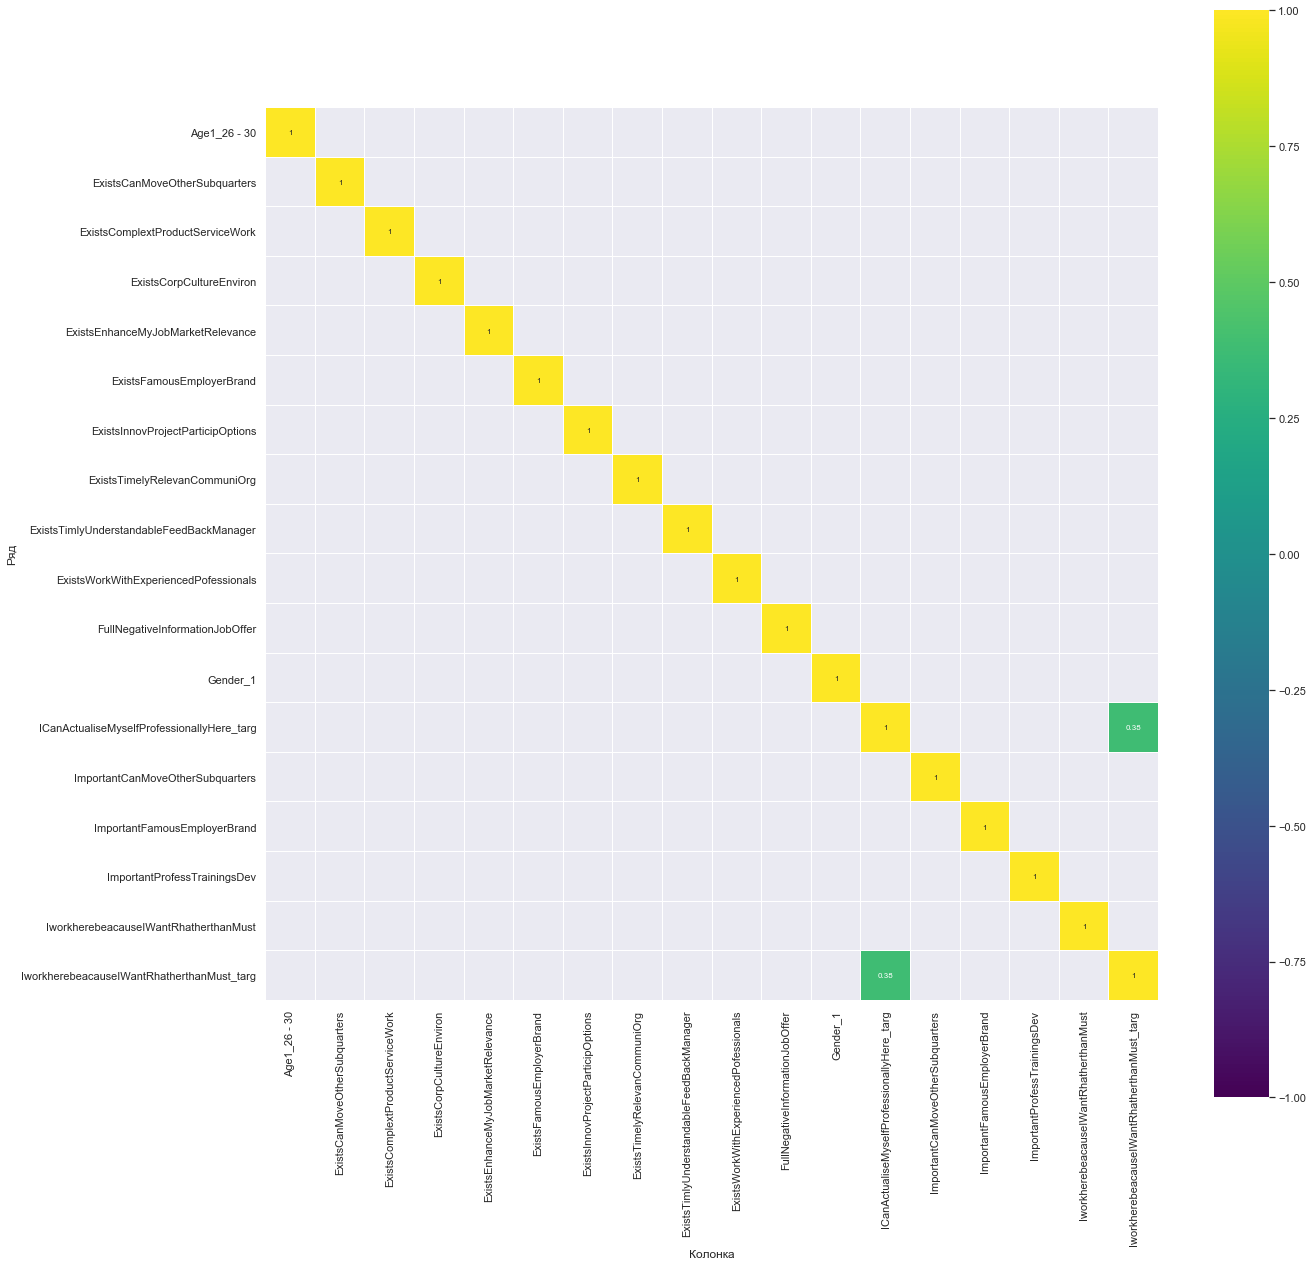

In [57]:
from sklearn.metrics import matthews_corrcoef

tab = pd.DataFrame()

for i in Talents[list(multi.index)]:
    for j in Talents[list(multi.index)]:
        tabb = Talents[[i,j]].dropna()
        N = matthews_corrcoef(tabb.iloc[:,0], tabb.iloc[:,1])
        Se_new = i
        Sp_new = j
        tab = tab.append({'Ряд': Se_new, 'Колонка': Sp_new, 'Коэфф. Мэтью' : N}, ignore_index=True)

tab = tab.pivot(index='Ряд', columns='Колонка', values='Коэфф. Мэтью')

sns.set(style = 'darkgrid')
plt.figure(figsize=(20, 20))
sns.heatmap(tab[(tab >= 0.3) | (tab <= -0.29)].round(2), cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True)
plt.show()

## RealityWorseThanExpectations_targ

In [58]:
reg_data = Talents.drop(columns=['RealityWorseThanExpectations_targ', 'RealityWorseThanExpectations']).dropna()
y = Talents.drop(columns=[]).dropna()[['RealityWorseThanExpectations_targ']]
logregr = pd.DataFrame()

for col in reg_data.columns:
    v = reg_data[col].name
    logit_model=sma.GLM(y, sma.add_constant(reg_data[[col]]), family = sma.families.Binomial())
    result=logit_model.fit()
    params = np.exp(result.params)[1]
    conf0 = np.exp(result.conf_int())[0][1]
    conf1 = np.exp(result.conf_int())[1][1]
    p = result.pvalues[1]
    logregr = logregr.append({'Names': v, 'OR': '{0:.2f}'.format(params), 'lower': '{0:.2f}'.format(conf0), 'upper': '{0:.2f}'.format(conf1),'p_val': p}, ignore_index=True)
            
logregr = logregr.reindex(columns=['Names', 'OR', 'lower', 'upper', 'p_val']) 
logregr = logregr[logregr['p_val'] < 0.05]
logregr

C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
C:\Users\lizag\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\lizag\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\lizag\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\lizag\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Names    OR lower upper  \
4                                 Software Development  2.48  1.31  4.70   
5                                         QA & Testing  0.49  0.25  0.94   
6                       Business & Functional Analysis  0.32  0.11  0.94   
12                                ImportantTaskVariety  0.49  0.28  0.87   
13                                   ExistsTaskVariety  0.42  0.28  0.61   
15                          ExistsProfExperiseIncrease  0.40  0.26  0.62   
17                            ExistsCareerLadderPromot  0.49  0.34  0.71   
19                         ExistsFullCycleDevInfluence  0.61  0.45  0.83   
21                           ExistsModernTechnologyUse  0.64  0.46  0.88   
23                    ExistsComplextProductServiceWork  0.67  0.46  0.98   
24                  ImportantBusinessTripANDNetworking  0.69  0.49  0.98   
27                       ExistsCanMoveOtherSubquarters  0.51  0.35  0.75   
28                        ImportantProfessTrainingsDev  0.62  0.41  0.92   
33                      ExistsOptionsProjectTeamChange  0.58  0.39  0.86   
37   ExistsEnhaceManagerialCompetenceDecisionMakInf...  0.63  0.44  0.89   
39                   ExistsEnhanceMyJobMarketRelevance  0.50  0.35  0.71   
40               ImportantFriendlyResponsiveColleagues  0.43  0.21  0.88   
41                  ExistsFriendlyResponsiveColleagues  0.56  0.36  0.86   
42                           ImportantWorkInUnitedTeam  0.45  0.23  0.85   
43                              ExistsWorkInUnitedTeam  0.49  0.33  0.72   
44            ImportantWorkWithExperiencedPofessionals  0.24  0.08  0.71   
45               ExistsWorkWithExperiencedPofessionals  0.37  0.21  0.63   
47                   ExistsInnovProjectParticipOptions  0.56  0.40  0.78   
49                             ExitstDynamicEvironment  0.51  0.35  0.74   
50                         ImportantRoleModelManagemer  0.55  0.37  0.82   
51                            ExistsRoleModelManagemer  0.38  0.26  0.57   
52                       ImportantInspirationalManager  0.45  0.27  0.73   
53                          ExistsInspirationalManager  0.41  0.28  0.60   
54         ImportantTimlyUnderstandableFeedBackManager  0.50  0.28  0.88   
55            ExistsTimlyUnderstandableFeedBackManager  0.47  0.32  0.69   
57                ExistsOpportinityToOfferAndRealIdeas  0.50  0.33  0.76   
58               ImportantJobImportanceBusiGoalConnect  0.54  0.32  0.90   
59                  ExistsJobImportanceBusiGoalConnect  0.53  0.37  0.76   
61           ExistsJobImportanceColleaguesManagerAppec  0.43  0.29  0.65   
63                       ExistsTimelyRelevanCommuniOrg  0.45  0.29  0.70   
66                        ImportantFamousEmployerBrand  0.68  0.50  0.91   
67                           ExistsFamousEmployerBrand  0.51  0.29  0.89   
70                         ImportantCorpCultureEnviron  0.56  0.35  0.92   
71                            ExistsCorpCultureEnviron  0.34  0.21  0.55   
72                  ImportantWorkStableReliableCompany  0.29  0.14  0.61   
73                     ExistsWorkStableReliableCompany  0.54  0.34  0.87   
83                                   ExistsNoDressCode  0.58  0.35  0.97   
85                                ExistsOfficeLocation  0.62  0.42  0.92   
87                   EsistsComfWorkPlaceAndNesSoftware  0.65  0.49  0.87   
91                     FullNegativeInformationJobOffer  0.64  0.46  0.88   
92                       RealityBetterThanExpectations  0.21  0.12  0.35   
93                                 IAmPartOrganisation  0.42  0.27  0.65   
94              ICanActualiseMyselfProfessionallyHere   0.31  0.19  0.50   
95               IworkherebeacauseIWantRhatherthanMust  0.41  0.27  0.63   
104                                       Age1_26 - 30  1.99  1.02  3.89   
106                                           Gender_1  0.35  0.17  0.73   
113                 RealityBetterThanExpectations_targ  0.09  0.04  0.22   
114                  

In [60]:
lst = list(logregr['Names'])
lst.remove('RealityBetterThanExpectations_targ')
lst.remove('RealityBetterThanExpectations')

In [61]:
multi = regr_multi(Talents.dropna(), group = 'RealityWorseThanExpectations_targ', lst = lst, save_tab = False)
multi = multi[multi['p_val'] < 0.05].drop(columns = 'Names').sort_values('OR', ascending = False)
multi

OR  lower  upper  p_val
ImportantCorpCultureEnviron                         6.37   1.08  37.59  0.041
Age1_26 - 30                                        5.56   1.03  29.98  0.046
ExistsComplextProductServiceWork                    4.04   1.44  11.30  0.008
ExistsEnhaceManagerialCompetenceDecisionMakInfu...  2.84   1.01   8.00  0.048
ExistsCanMoveOtherSubquarters                       0.22   0.07   0.65  0.006
ExistsCorpCultureEnviron                            0.22   0.05   0.93  0.040
ImportantWorkStableReliableCompany                  0.14   0.02   0.84  0.031
QA & Testing                                        0.03   0.00   0.33  0.003

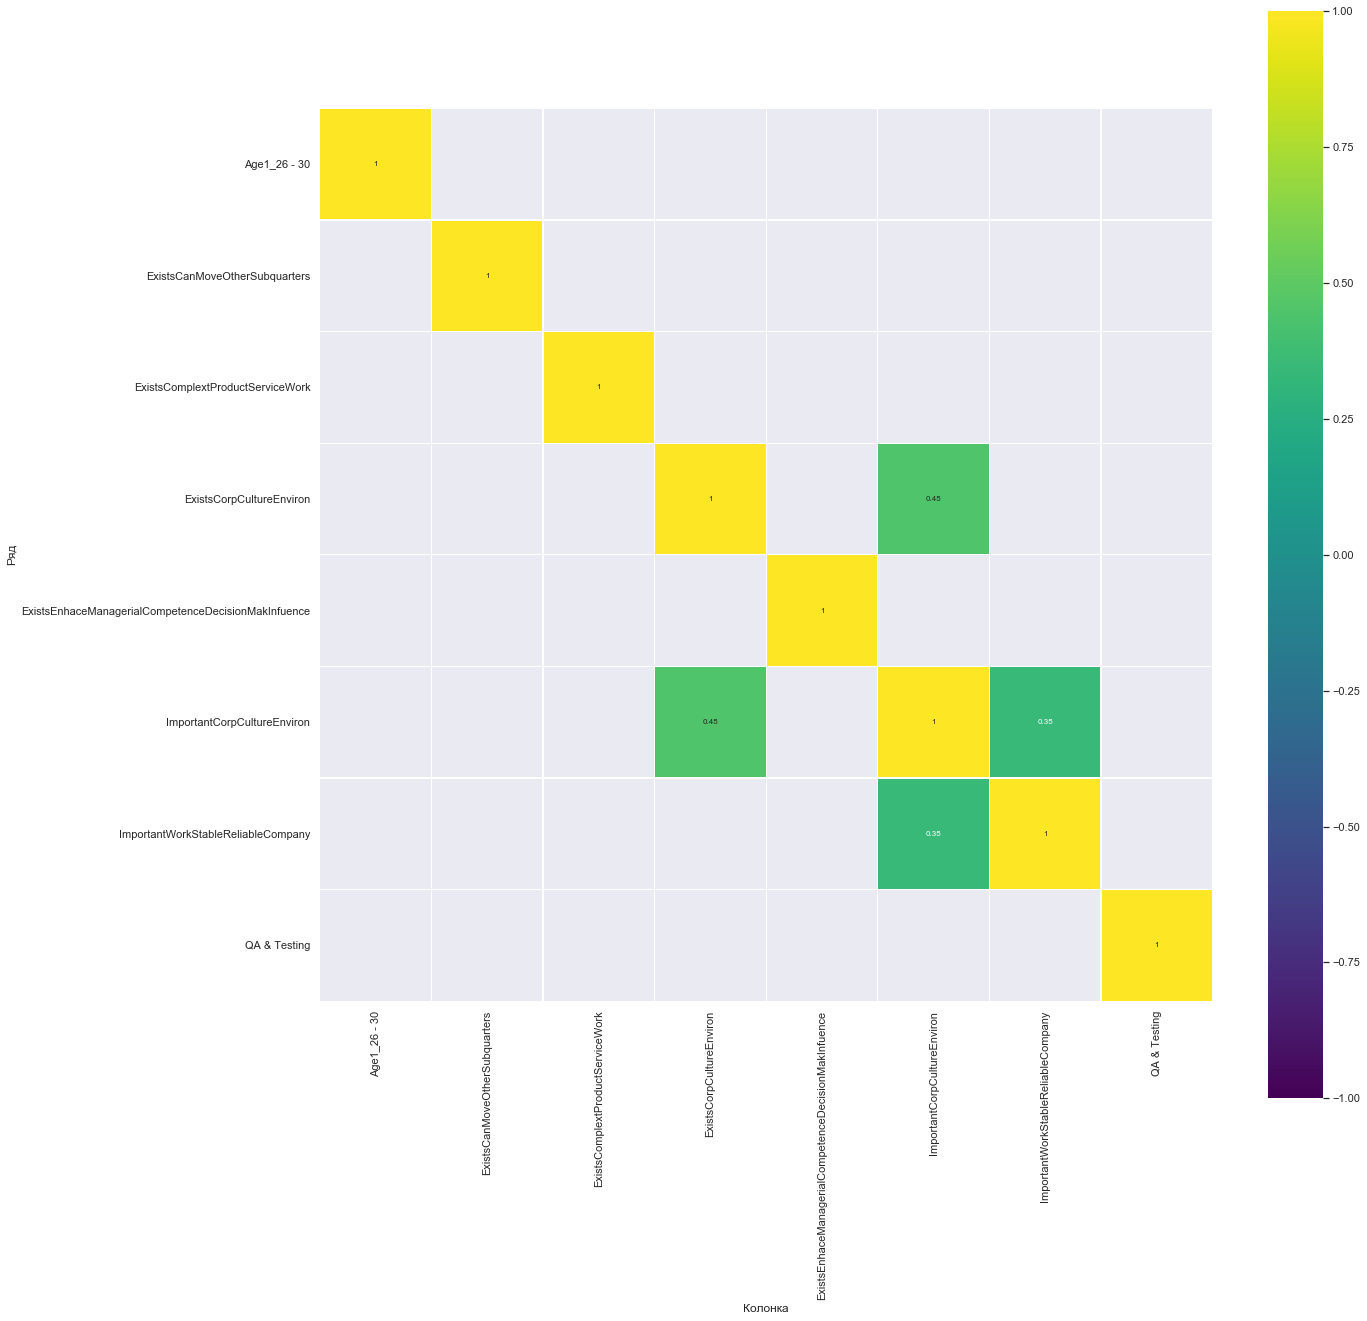

In [62]:
tab = pd.DataFrame()

for i in Talents[list(multi.index)]:
    for j in Talents[list(multi.index)]:
        tabb = Talents[[i,j]].dropna()
        N = matthews_corrcoef(tabb.iloc[:,0], tabb.iloc[:,1])
        Se_new = i
        Sp_new = j
        tab = tab.append({'Ряд': Se_new, 'Колонка': Sp_new, 'Коэфф. Мэтью' : N}, ignore_index=True)

tab = tab.pivot(index='Ряд', columns='Колонка', values='Коэфф. Мэтью')

sns.set(style = 'darkgrid')
plt.figure(figsize=(20, 20))
sns.heatmap(tab[(tab >= 0.3) | (tab <= -0.29)].round(2), cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True)
plt.show()

## IAmPartOrganisation_targ

In [63]:
reg_data = Talents.drop(columns=['IAmPartOrganisation_targ', 'IAmPartOrganisation']).dropna()
y = Talents.drop(columns=[]).dropna()[['IAmPartOrganisation_targ']]
logregr = pd.DataFrame()

for col in reg_data.columns:
    v = reg_data[col].name
    logit_model=sma.GLM(y, sma.add_constant(reg_data[[col]]), family = sma.families.Binomial())
    result=logit_model.fit()
    params = np.exp(result.params)[1]
    conf0 = np.exp(result.conf_int())[0][1]
    conf1 = np.exp(result.conf_int())[1][1]
    p = result.pvalues[1]
    logregr = logregr.append({'Names': v, 'OR': '{0:.2f}'.format(params), 'lower': '{0:.2f}'.format(conf0), 'upper': '{0:.2f}'.format(conf1),'p_val': p}, ignore_index=True)
            
logregr = logregr.reindex(columns=['Names', 'OR', 'lower', 'upper', 'p_val']) 
logregr = logregr[logregr['p_val'] < 0.05]
logregr

C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
C:\Users\lizag\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\lizag\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\lizag\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\lizag\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Names    OR lower  upper  \
13                                   ExistsTaskVariety  1.83  1.33   2.53   
14                       ImportantProfExperiseIncrease  2.69  1.19   6.12   
15                          ExistsProfExperiseIncrease  1.68  1.24   2.29   
16                         ImportantCareerLadderPromot  1.75  1.17   2.63   
17                            ExistsCareerLadderPromot  2.04  1.39   2.99   
18                      ImportantFullCycleDevInfluence  1.56  1.11   2.20   
19                         ExistsFullCycleDevInfluence  1.73  1.29   2.33   
21                           ExistsModernTechnologyUse  1.82  1.34   2.47   
22                 ImportantComplextProductServiceWork  1.57  1.08   2.27   
26                    ImportantCanMoveOtherSubquarters  1.33  1.01   1.74   
33                      ExistsOptionsProjectTeamChange  1.54  1.03   2.28   
35                   ExistsShareExperANDEducColleagues  1.77  1.21   2.58   
36   ImportantEnhaceManagerialCompetenceDecisionMak...  1.44  1.05   1.97   
37   ExistsEnhaceManagerialCompetenceDecisionMakInf...  1.78  1.24   2.55   
39                   ExistsEnhanceMyJobMarketRelevance  1.61  1.20   2.16   
42                           ImportantWorkInUnitedTeam  1.69  1.02   2.79   
43                              ExistsWorkInUnitedTeam  1.69  1.22   2.33   
45               ExistsWorkWithExperiencedPofessionals  2.17  1.43   3.28   
47                   ExistsInnovProjectParticipOptions  1.88  1.33   2.66   
48                          ImportantDynamicEvironment  1.61  1.10   2.34   
49                             ExitstDynamicEvironment  1.62  1.12   2.35   
51                            ExistsRoleModelManagemer  1.94  1.38   2.72   
53                          ExistsInspirationalManager  2.00  1.43   2.80   
55            ExistsTimlyUnderstandableFeedBackManager  1.55  1.13   2.13   
57                ExistsOpportinityToOfferAndRealIdeas  1.71  1.17   2.49   
59                  ExistsJobImportanceBusiGoalConnect  2.17  1.54   3.05   
60        ImportantJobImportanceColleaguesManagerAppec  1.67  1.07   2.61   
61           ExistsJobImportanceColleaguesManagerAppec  2.25  1.52   3.34   
62                    ImportantTimelyRelevanCommuniOrg  1.48  1.05   2.09   
63                       ExistsTimelyRelevanCommuniOrg  2.35  1.54   3.56   
65                         ExistsDiversityAndInclusion  1.55  1.02   2.36   
66                        ImportantFamousEmployerBrand  1.41  1.07   1.85   
67                           ExistsFamousEmployerBrand  1.69  1.04   2.75   
68                                 ImportantCSRCharity  1.50  1.15   1.97   
71                            ExistsCorpCultureEnviron  1.53  1.07   2.18   
73                     ExistsWorkStableReliableCompany  1.68  1.13   2.49   
76                              ImportantSocialPackage  1.99  1.08   3.65   
87                   EsistsComfWorkPlaceAndNesSoftware  1.54  1.18   2.01   
91                     FullNegativeInformationJobOffer  1.39  1.01   1.90   
92                       RealityBetterThanExpectations  1.71  1.23   2.39   
93                        RealityWorseThanExpectations  0.47  0.33   0.66   
94              ICanActualiseMyselfProfessionallyHere   3.85  2.43   6.11   
95               IworkherebeacauseIWantRhatherthanMust  3.25  2.10   5.03   
113                 RealityBetterThanExpectations_targ  2.58  1.34   4.94   
114                  RealityWorseThanExpectations_targ  0.25  0.11   0.56   
115         ICanActualiseMyselfProfessionallyHere_targ  9.36  4.46  19.67   
116         IworkherebeacauseIWantRhatherthanMust_targ  6.67  3.26  13.62   

            p_val  
13   2.389049e-04  
14   1.787700e-02  
15   9.534093e-04  
16   6.653055e-03  
17   2.426823e-04  
18   1.041718e-02  
19   2.939974e-04  
21   1.169575e-04  
22   1.692908e-02  
26   3.905573e-02  
33   3.331478e-02  
35   3.009140e-03  
36   2.341837e-02  
37   1.849992e-03  
39   1.339850e-03  
42   4.136499e-02  
43   1.49269

In [64]:
multi = regr_multi(Talents.dropna(), group = 'IAmPartOrganisation_targ', lst = list(logregr['Names']), save_tab = False)
multi = multi[multi['p_val'] < 0.05].drop(columns = 'Names').sort_values('OR', ascending = False)
multi 

OR  lower  upper  p_val
IworkherebeacauseIWantRhatherthanMust  5.52   1.14  26.78  0.034
ExistsModernTechnologyUse              2.49   1.18   5.28  0.017
ImportantFullCycleDevInfluence         2.45   1.10   5.44  0.028
ImportantCanMoveOtherSubquarters       1.77   1.01   3.09  0.046
ExistsProfExperiseIncrease             0.39   0.17   0.90  0.027
ExistsOpportinityToOfferAndRealIdeas   0.28   0.11   0.70  0.006

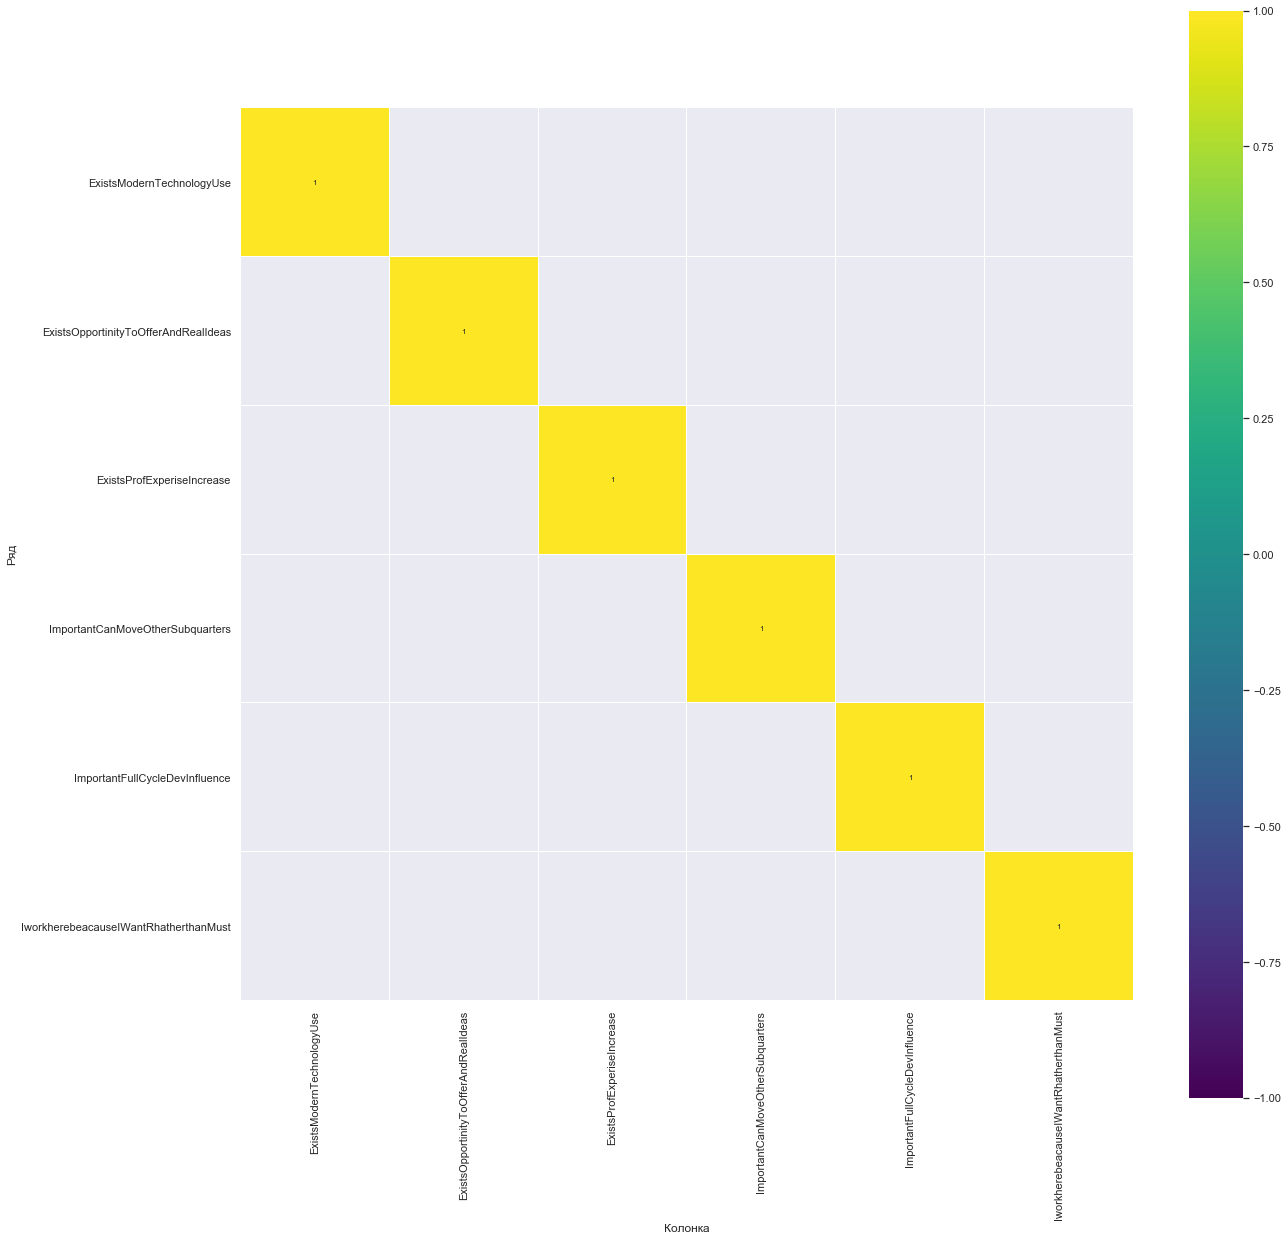

In [65]:
tab = pd.DataFrame()

for i in Talents[list(multi.index)]:
    for j in Talents[list(multi.index)]:
        tabb = Talents[[i,j]].dropna()
        N = matthews_corrcoef(tabb.iloc[:,0], tabb.iloc[:,1])
        Se_new = i
        Sp_new = j
        tab = tab.append({'Ряд': Se_new, 'Колонка': Sp_new, 'Коэфф. Мэтью' : N}, ignore_index=True)

tab = tab.pivot(index='Ряд', columns='Колонка', values='Коэфф. Мэтью')

sns.set(style = 'darkgrid')
plt.figure(figsize=(20, 20))
sns.heatmap(tab[(tab >= 0.3) | (tab <= -0.29)].round(2), cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True)
plt.show()

## ICanActualiseMyselfProfessionallyHere_targ

In [66]:
reg_data = Talents.drop(columns=['ICanActualiseMyselfProfessionallyHere_targ', 'ICanActualiseMyselfProfessionallyHere ']).dropna()
y = Talents.drop(columns=[]).dropna()[['ICanActualiseMyselfProfessionallyHere_targ']]
logregr = pd.DataFrame()

for col in reg_data.columns:
    v = reg_data[col].name
    logit_model=sma.GLM(y, sma.add_constant(reg_data[[col]]), family = sma.families.Binomial())
    result=logit_model.fit()
    params = np.exp(result.params)[1]
    conf0 = np.exp(result.conf_int())[0][1]
    conf1 = np.exp(result.conf_int())[1][1]
    p = result.pvalues[1]
    logregr = logregr.append({'Names': v, 'OR': '{0:.2f}'.format(params), 'lower': '{0:.2f}'.format(conf0), 'upper': '{0:.2f}'.format(conf1),'p_val': p}, ignore_index=True)
            
logregr = logregr.reindex(columns=['Names', 'OR', 'lower', 'upper', 'p_val']) 
logregr = logregr[logregr['p_val'] < 0.05]
logregr

C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
C:\Users\lizag\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\lizag\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\lizag\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\lizag\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Names    OR lower  upper  \
13                                   ExistsTaskVariety  2.28  1.61   3.24   
14                       ImportantProfExperiseIncrease  2.19  1.01   4.73   
15                          ExistsProfExperiseIncrease  2.89  1.97   4.26   
17                            ExistsCareerLadderPromot  2.31  1.54   3.46   
19                         ExistsFullCycleDevInfluence  1.86  1.36   2.53   
21                           ExistsModernTechnologyUse  1.91  1.40   2.62   
23                    ExistsComplextProductServiceWork  2.20  1.49   3.24   
29                           ExistsProfessTrainingsDev  2.10  1.46   3.03   
30                     ImportantProfConferenceParticip  1.36  1.00   1.84   
34                ImportantShareExperANDEducColleagues  1.45  1.02   2.08   
35                   ExistsShareExperANDEducColleagues  1.95  1.32   2.89   
37   ExistsEnhaceManagerialCompetenceDecisionMakInf...  1.70  1.18   2.45   
39                   ExistsEnhanceMyJobMarketRelevance  2.18  1.57   3.03   
43                              ExistsWorkInUnitedTeam  1.46  1.06   2.01   
45               ExistsWorkWithExperiencedPofessionals  2.88  1.82   4.55   
47                   ExistsInnovProjectParticipOptions  1.97  1.38   2.83   
49                             ExitstDynamicEvironment  1.57  1.08   2.29   
51                            ExistsRoleModelManagemer  1.97  1.40   2.79   
53                          ExistsInspirationalManager  1.93  1.38   2.71   
55            ExistsTimlyUnderstandableFeedBackManager  1.64  1.18   2.27   
57                ExistsOpportinityToOfferAndRealIdeas  1.95  1.31   2.90   
59                  ExistsJobImportanceBusiGoalConnect  2.22  1.56   3.14   
60        ImportantJobImportanceColleaguesManagerAppec  1.58  1.01   2.47   
61           ExistsJobImportanceColleaguesManagerAppec  2.39  1.59   3.59   
63                       ExistsTimelyRelevanCommuniOrg  2.35  1.54   3.60   
65                         ExistsDiversityAndInclusion  2.25  1.40   3.62   
66                        ImportantFamousEmployerBrand  1.65  1.24   2.21   
67                           ExistsFamousEmployerBrand  1.65  1.00   2.69   
71                            ExistsCorpCultureEnviron  1.58  1.10   2.27   
72                  ImportantWorkStableReliableCompany  1.69  1.01   2.82   
73                     ExistsWorkStableReliableCompany  2.25  1.46   3.47   
75                             ExistsCompetitiveSalary  1.62  1.04   2.52   
87                   EsistsComfWorkPlaceAndNesSoftware  1.78  1.34   2.36   
91                     FullNegativeInformationJobOffer  1.72  1.22   2.41   
92                       RealityBetterThanExpectations  2.69  1.82   3.99   
93                        RealityWorseThanExpectations  0.36  0.25   0.53   
94                                 IAmPartOrganisation  4.15  2.51   6.87   
95               IworkherebeacauseIWantRhatherthanMust  2.79  1.84   4.22   
96                                            City_2.0  2.24  1.07   4.69   
97                                            City_1.0  0.45  0.21   0.93   
113                 RealityBetterThanExpectations_targ  5.99  2.88  12.45   
114                  RealityWorseThanExpectations_targ  0.21  0.09   0.50   
115                           IAmPartOrganisation_targ  9.36  4.46  19.67   
116         IworkherebeacauseIWantRhatherthanMust_targ  5.85  2.86  11.95   

            p_val  
13   3.661220e-06  
14   4.657867e-02  
15   6.694099e-08  
17   5.236865e-05  
19   9.138443e-05  
21   5.082876e-05  
23   7.025747e-05  
29   6.825873e-05  
30   4.642069e-02  
34   4.109284e-02  
35   8.027661e-04  
37   4.383022e-03  
39   3.134047e-06  
43   2.156452e-02  
45   6.459328e-06  
47   2.148570e-04  
49   1.934380e-02  
51   1.178732e-04  
53   1.415100e-04  
55   3.104094e-03  
57   9.483908e-04  
59   7.759667e-06  
60   4.745516e-02  
61   3.082803e-05  
63   7.698208e-05  
65   7.878227e-04  
66   6.425912e-04  
67   4.779678e-02  
71 

In [67]:
multi = regr_multi(Talents.dropna(), group = 'ICanActualiseMyselfProfessionallyHere_targ', lst = list(logregr['Names']), save_tab = False)
multi = multi[multi['p_val'] < 0.05].drop(columns = 'Names').sort_values('OR', ascending = False)
multi

OR  lower  upper  p_val
ExistsComplextProductServiceWork    7.76   1.62  37.12  0.010
ExistsProfessTrainingsDev           4.97   1.20  20.61  0.027
ExistsDiversityAndInclusion         4.93   1.36  17.91  0.015
ImportantFamousEmployerBrand        4.33   1.30  14.41  0.017
ExistsJobImportanceBusiGoalConnect  4.18   1.33  13.13  0.014
ExistsWorkInUnitedTeam              0.23   0.06   0.92  0.037
ExistsCorpCultureEnviron            0.15   0.03   0.71  0.017
RealityWorseThanExpectations        0.04   0.00   0.71  0.028
City_1.0                            0.00   0.00   0.46  0.023

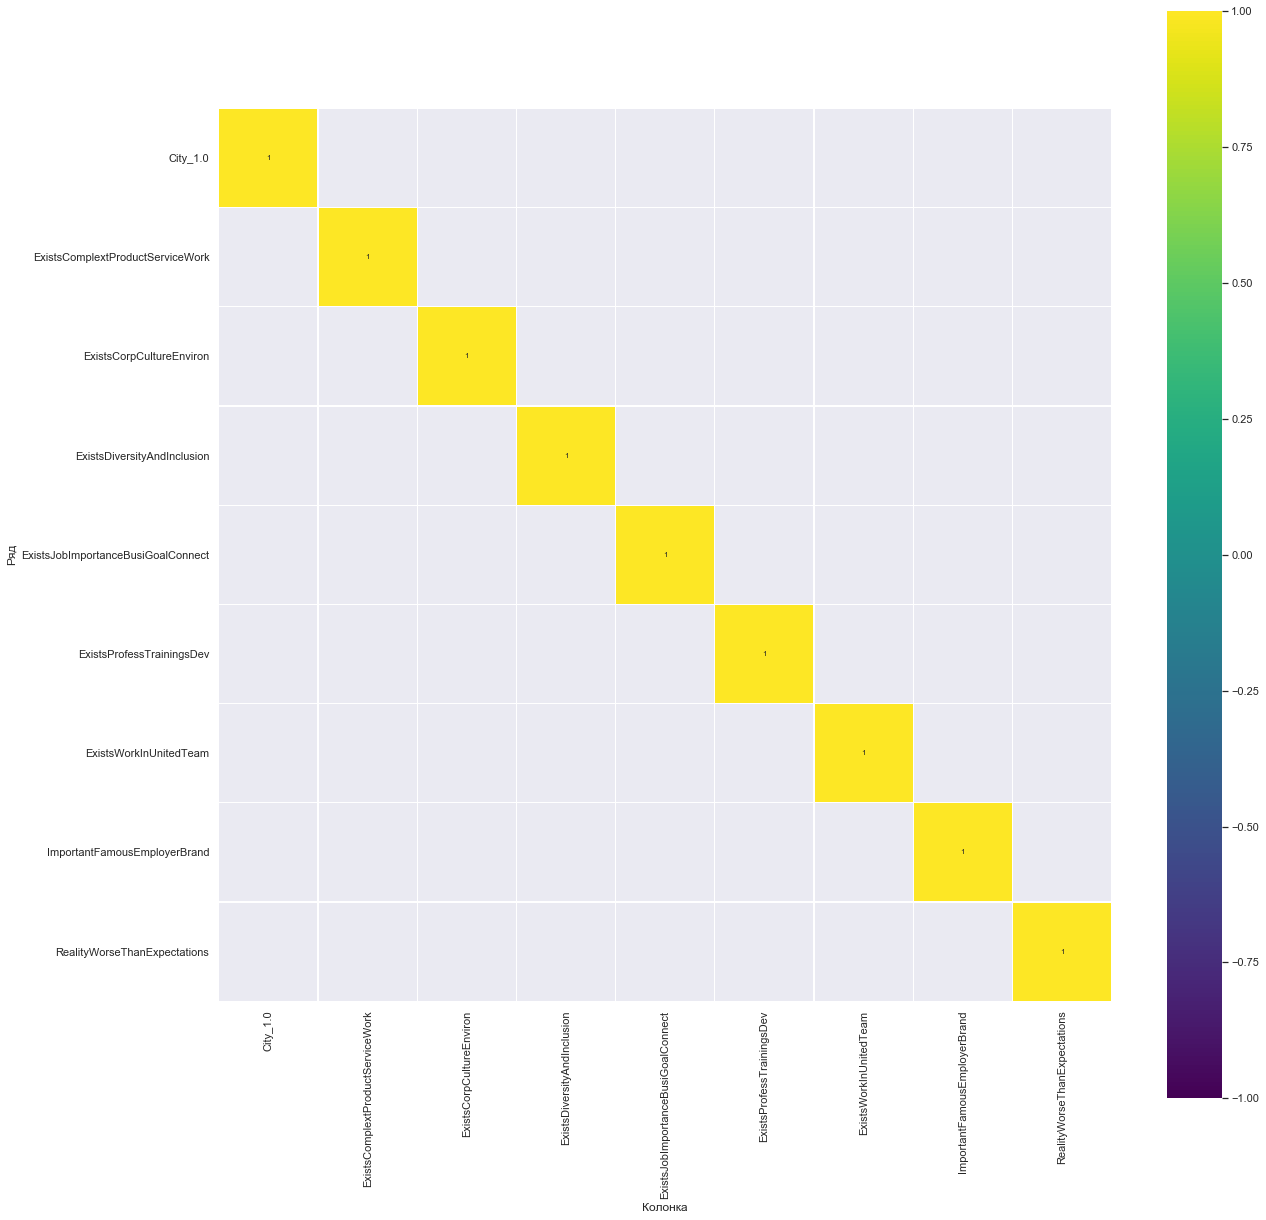

In [68]:
tab = pd.DataFrame()

for i in Talents[list(multi.index)]:
    for j in Talents[list(multi.index)]:
        tabb = Talents[[i,j]].dropna()
        N = matthews_corrcoef(tabb.iloc[:,0], tabb.iloc[:,1])
        Se_new = i
        Sp_new = j
        tab = tab.append({'Ряд': Se_new, 'Колонка': Sp_new, 'Коэфф. Мэтью' : N}, ignore_index=True)

tab = tab.pivot(index='Ряд', columns='Колонка', values='Коэфф. Мэтью')

sns.set(style = 'darkgrid')
plt.figure(figsize=(20, 20))
sns.heatmap(tab[(tab >= 0.3) | (tab <= -0.29)].round(2), cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True)
plt.show()

## IworkherebeacauseIWantRhatherthanMust_targ

In [69]:
reg_data = Talents.drop(columns=['IworkherebeacauseIWantRhatherthanMust_targ', 'IworkherebeacauseIWantRhatherthanMust']).dropna()
y = Talents.drop(columns=[]).dropna()[['IworkherebeacauseIWantRhatherthanMust_targ']]
logregr = pd.DataFrame()

for col in reg_data.columns:
    v = reg_data[col].name
    logit_model=sma.GLM(y, sma.add_constant(reg_data[[col]]), family = sma.families.Binomial())
    result=logit_model.fit()
    params = np.exp(result.params)[1]
    conf0 = np.exp(result.conf_int())[0][1]
    conf1 = np.exp(result.conf_int())[1][1]
    p = result.pvalues[1]
    logregr = logregr.append({'Names': v, 'OR': '{0:.2f}'.format(params), 'lower': '{0:.2f}'.format(conf0), 'upper': '{0:.2f}'.format(conf1),'p_val': p}, ignore_index=True)
            
logregr = logregr.reindex(columns=['Names', 'OR', 'lower', 'upper', 'p_val']) 
logregr = logregr[logregr['p_val'] < 0.05]
logregr

C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()
C:\Users\lizag\anaconda3\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\lizag\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\lizag\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\lizag\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Names    OR lower  upper  \
13                                   ExistsTaskVariety  1.68  1.22   2.32   
15                          ExistsProfExperiseIncrease  1.59  1.17   2.16   
17                            ExistsCareerLadderPromot  1.58  1.10   2.27   
19                         ExistsFullCycleDevInfluence  1.78  1.31   2.41   
21                           ExistsModernTechnologyUse  1.41  1.05   1.89   
23                    ExistsComplextProductServiceWork  1.89  1.30   2.75   
25                     ExistsBusinessTripANDNetworking  1.33  1.00   1.77   
28                        ImportantProfessTrainingsDev  1.46  1.03   2.05   
33                      ExistsOptionsProjectTeamChange  1.79  1.18   2.72   
35                   ExistsShareExperANDEducColleagues  1.73  1.18   2.53   
37   ExistsEnhaceManagerialCompetenceDecisionMakInf...  1.78  1.23   2.57   
39                   ExistsEnhanceMyJobMarketRelevance  1.53  1.14   2.05   
41                  ExistsFriendlyResponsiveColleagues  1.61  1.14   2.28   
43                              ExistsWorkInUnitedTeam  1.98  1.41   2.77   
45               ExistsWorkWithExperiencedPofessionals  2.17  1.43   3.28   
47                   ExistsInnovProjectParticipOptions  1.72  1.22   2.42   
48                          ImportantDynamicEvironment  1.48  1.01   2.16   
49                             ExitstDynamicEvironment  1.48  1.02   2.14   
51                            ExistsRoleModelManagemer  2.00  1.42   2.83   
53                          ExistsInspirationalManager  1.84  1.32   2.57   
55            ExistsTimlyUnderstandableFeedBackManager  1.66  1.20   2.31   
56             ImportantOpportinityToOfferAndRealIdeas  2.02  1.27   3.22   
57                ExistsOpportinityToOfferAndRealIdeas  2.62  1.70   4.04   
59                  ExistsJobImportanceBusiGoalConnect  1.83  1.32   2.53   
61           ExistsJobImportanceColleaguesManagerAppec  1.92  1.31   2.80   
63                       ExistsTimelyRelevanCommuniOrg  1.95  1.30   2.92   
66                        ImportantFamousEmployerBrand  1.56  1.18   2.08   
68                                 ImportantCSRCharity  1.37  1.04   1.79   
71                            ExistsCorpCultureEnviron  1.82  1.25   2.64   
73                     ExistsWorkStableReliableCompany  1.82  1.21   2.73   
81                               ExistsWorkLifeBalance  1.37  1.01   1.84   
83                                   ExistsNoDressCode  1.75  1.15   2.67   
85                                ExistsOfficeLocation  1.68  1.19   2.38   
87                   EsistsComfWorkPlaceAndNesSoftware  1.32  1.01   1.72   
91                     FullNegativeInformationJobOffer  1.78  1.26   2.51   
92                       RealityBetterThanExpectations  2.26  1.56   3.25   
93                        RealityWorseThanExpectations  0.44  0.31   0.62   
94                                 IAmPartOrganisation  3.56  2.22   5.72   
95              ICanActualiseMyselfProfessionallyHere   2.59  1.75   3.83   
103                                       Age1_31 - 35  2.11  1.01   4.41   
104                                       Age1_26 - 30  0.39  0.20   0.76   
113                 RealityBetterThanExpectations_targ  4.24  2.11   8.50   
114                  RealityWorseThanExpectations_targ  0.24  0.11   0.56   
115                           IAmPartOrganisation_targ  6.67  3.26  13.62   
116         ICanActualiseMyselfProfessionallyHere_targ  5.85  2.86  11.95   

            p_val  
13   1.467418e-03  
15   3.049655e-03  
17   1.348050e-02  
19   2.153969e-04  
21   2.159382e-02  
23   7.942307e-04  
25   4.686253e-02  
28   3.112324e-02  
33   5.860039e-03  
35   4.826872e-03  
37   2.207591e-03  
39   4.306833e-03  
41   7.521258e-03  
43   8.386905e-05  
45   2.541856e-04  
47   1.983782e-03  
48   4.276923e-02  
49   3.834483e-02  
51   8.695398e-05  
53   3.149828e-04  
55   2.252639e-03  
56   2.999661e-03  
57   1.265808e-05  
59   3.116933e-04  
61   7

In [70]:
multi = regr_multi(Talents.dropna(), group = 'IworkherebeacauseIWantRhatherthanMust_targ', lst = list(logregr['Names']), save_tab = False)
multi[multi['p_val'] < 0.05].drop(columns = 'Names').sort_values('OR', ascending = False)

OR  lower  upper  p_val
ExistsOfficeLocation  2.03   1.04   3.94  0.037

### Создание New talents

Люди - новая нефть!

In [72]:
df['FullPositiveInformationJobOffer_targ'] = (df['FullPositiveInformationJobOffer'] >= np.median(df['FullPositiveInformationJobOffer'])).astype(int)
df['FullNegativeInformationJobOffer_targ'] = (df['FullNegativeInformationJobOffer'] >= np.median(df['FullNegativeInformationJobOffer'])).astype(int)

## Создание New Talents по пересечению нескольких переменных

1 = выше медианы, 0 = ниже медианы

все переменные снизу в 1 и 0

In [73]:
lst = ['Talents',
'FullPositiveInformationJobOffer_targ', 
'FullNegativeInformationJobOffer_targ', 
'IAmPartOrganisation_targ', 
'ICanActualiseMyselfProfessionallyHere_targ',
'IworkherebeacauseIWantRhatherthanMust_targ']

df['New_talents'] = df[lst].sum(axis = 1)

df['New_talents'] = (df['New_talents'] > 5).astype(int)

## Таблица для Сони!!!

In [127]:
df.to_excel('for_Sonya_with_love.xlsx')

In [74]:
summary(df[['New_talents']]).iloc[:,:5]

Фактор             Тип       N Количество Доля, %
0  New_talents  Категориальная     559         70   12.5%

In [76]:
reg_data = df.dropna().drop(columns = ['New_talents', 'Talents'])
y = df.dropna()[['New_talents']]
logregr = pd.DataFrame()

for col in reg_data.columns:
    v = reg_data[col].name
    logit_model=sma.GLM(y, sma.add_constant(reg_data[[col]]), family = sma.families.Binomial())
    result=logit_model.fit()
    params = np.exp(result.params)[1]
    conf0 = np.exp(result.conf_int())[0][1]
    conf1 = np.exp(result.conf_int())[1][1]
    p = result.pvalues[1]
    logregr = logregr.append({'Names': v, 'OR': '{0:.2f}'.format(params), 'lower': '{0:.2f}'.format(conf0), 'upper': '{0:.2f}'.format(conf1),'p_val': p}, ignore_index=True)
            
logregr = logregr.reindex(columns=['Names', 'OR', 'lower', 'upper', 'p_val']) 
logregr[logregr['p_val'] < 0.05].sort_values('OR', ascending = False)

C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


Names    OR lower  upper  \
106                                       Age1_21 - 25  6.69  3.63  12.32   
110                               Experience1_< 1 года  6.51  3.73  11.36   
113                             Experience1_1 - 2 года  6.00  3.54  10.16   
14                       ImportantProfExperiseIncrease  3.80  1.38  10.44   
90                     FullPositiveInformationJobOffer  3.50  2.22   5.51   
96               IworkherebeacauseIWantRhatherthanMust  3.37  2.30   4.94   
95              ICanActualiseMyselfProfessionallyHere   3.30  2.21   4.93   
94                                 IAmPartOrganisation  3.27  2.21   4.84   
91                     FullNegativeInformationJobOffer  2.53  1.92   3.34   
42                           ImportantWorkInUnitedTeam  2.40  1.36   4.24   
67                           ExistsFamousEmployerBrand  2.33  1.43   3.80   
15                          ExistsProfExperiseIncrease  2.13  1.52   2.99   
71                            ExistsCorpCultureEnviron  2.08  1.45   2.98   
63                       ExistsTimelyRelevanCommuniOrg  2.07  1.48   2.89   
23                    ExistsComplextProductServiceWork  2.02  1.40   2.92   
61           ExistsJobImportanceColleaguesManagerAppec  2.00  1.46   2.73   
44            ImportantWorkWithExperiencedPofessionals  2.00  1.03   3.90   
45               ExistsWorkWithExperiencedPofessionals  1.98  1.29   3.04   
80                            ImportantWorkLifeBalance  1.96  1.10   3.48   
59                  ExistsJobImportanceBusiGoalConnect  1.94  1.45   2.61   
75                             ExistsCompetitiveSalary  1.92  1.25   2.94   
40               ImportantFriendlyResponsiveColleagues  1.91  1.09   3.35   
70                         ImportantCorpCultureEnviron  1.87  1.22   2.86   
97                                            City_2.0  1.85  1.08   3.14   
73                     ExistsWorkStableReliableCompany  1.83  1.21   2.77   
53                          ExistsInspirationalManager  1.82  1.38   2.41   
58               ImportantJobImportanceBusiGoalConnect  1.78  1.15   2.75   
39                   ExistsEnhanceMyJobMarketRelevance  1.72  1.30   2.27   
72                  ImportantWorkStableReliableCompany  1.68  1.04   2.73   
55            ExistsTimlyUnderstandableFeedBackManager  1.64  1.26   2.14   
51                            ExistsRoleModelManagemer  1.64  1.26   2.15   
43                              ExistsWorkInUnitedTeam  1.63  1.18   2.25   
29                           ExistsProfessTrainingsDev  1.61  1.15   2.26   
41                  ExistsFriendlyResponsiveColleagues  1.56  1.07   2.27   
28                        ImportantProfessTrainingsDev  1.50  1.07   2.11   
57                ExistsOpportinityToOfferAndRealIdeas  1.46  1.08   1.97   
66                        ImportantFamousEmployerBrand  1.45  1.13   1.86   
37   ExistsEnhaceManagerialCompetenceDecisionMakInf...  1.44  1.10   1.90   
52                       ImportantInspirationalManager  1.44  1.01   2.06   
22                 ImportantComplextProductServiceWork  1.43  1.03   1.99   
47                   ExistsInnovProjectParticipOptions  1.38  1.07   1.77   
21                           ExistsModernTechnologyUse  1.35  1.06   1.73   
17                            ExistsCareerLadderPromot  1.33  1.04   1.70   
92                       RealityBetterThanExpectations  1.32  1.01   1.73   
30                     ImportantProfConferenceParticip  1.31  1.04   1.66   
68                                 ImportantCSRCharity  1.29  1.03   1.60   
25                     ExistsBusinessTripANDNetworking  1.29  1.05   1.58   
87                   EsistsComfWorkPlaceAndNesSoftware  1.28  1.01   1.62   
93                        RealityWorseThanExpectations  0.62  0.47   0.83   
98                                            City_1.0  0.54  0.32   0.92   
115                  RealityWorseThanExpectations_targ  0.50  0.30   0.83   
3                                            

In [77]:
reg_data = df.dropna().drop(columns = ['New_talents', 'Talents'])
y = df.dropna()[['New_talents']]
logregr = pd.DataFrame()

for col in reg_data.columns:
    v = reg_data[col].name
    logit_model=sma.GLM(y, sma.add_constant(reg_data[[col]]), family = sma.families.Binomial())
    result=logit_model.fit()
    params = np.exp(result.params)[1]
    conf0 = np.exp(result.conf_int())[0][1]
    conf1 = np.exp(result.conf_int())[1][1]
    p = result.pvalues[1]
    logregr = logregr.append({'Names': v, 'OR': '{0:.2f}'.format(params), 'lower': '{0:.2f}'.format(conf0), 'upper': '{0:.2f}'.format(conf1),'p_val': p}, ignore_index=True)
            
logregr = logregr.reindex(columns=['Names', 'OR', 'lower', 'upper', 'p_val']) 
logregr = logregr[logregr['p_val'] < 0.05]

lst = list(logregr['Names'])

regr_multi(df.dropna(), group = 'New_talents', lst = lst[:-3], save_tab = False)
multi[multi['p_val'] < 0.05].drop(columns = 'Names').sort_values('OR', ascending = False)


C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
C:\Users\lizag\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in exp
  # This is added back by InteractiveShellApp.init_path()


OR  lower  upper  p_val
ExistsOfficeLocation  2.03   1.04   3.94  0.037

## Описательные статистики по новым талантам и новым неталантам

In [ ]:
## Новые таланты

summary(df[df['New_talents'] == 1])

In [ ]:
## Новые НЕталанты

summary(df[df['New_talents'] == 0])

In [79]:
## Сранвительные статистики по новым талантам и новым неталантам - только значимые различия

In [78]:
tab = compare(df, group = 'New_talents')
tab[tab['p_val'] < 0.05]

Фактор  N 0 N 1  \
0                                                  Age  489  70   
1                                           Experience  489  70   
2                                              Talents  489  70   
3                                                Grade  489  70   
4                                               RolesN  489  70   
10                                  Technology Manager  489  70   
12                                         Team leader  489  70   
15                       ImportantProfExperiseIncrease  489  70   
16                          ExistsProfExperiseIncrease  489  70   
18                            ExistsCareerLadderPromot  489  70   
22                           ExistsModernTechnologyUse  489  70   
23                 ImportantComplextProductServiceWork  489  70   
24                    ExistsComplextProductServiceWork  489  70   
26                     ExistsBusinessTripANDNetworking  489  70   
29                        ImportantProfessTrainingsDev  489  70   
30                           ExistsProfessTrainingsDev  489  70   
31                     ImportantProfConferenceParticip  489  70   
38   ExistsEnhaceManagerialCompetenceDecisionMakInf...  489  70   
40                   ExistsEnhanceMyJobMarketRelevance  489  70   
41               ImportantFriendlyResponsiveColleagues  489  70   
42                  ExistsFriendlyResponsiveColleagues  489  70   
43                           ImportantWorkInUnitedTeam  489  70   
44                              ExistsWorkInUnitedTeam  488  70   
45            ImportantWorkWithExperiencedPofessionals  489  70   
46               ExistsWorkWithExperiencedPofessionals  489  70   
48                   ExistsInnovProjectParticipOptions  489  70   
52                            ExistsRoleModelManagemer  489  70   
53                       ImportantInspirationalManager  489  70   
54                          ExistsInspirationalManager  489  70   
56            ExistsTimlyUnderstandableFeedBackManager  489  70   
58                ExistsOpportinityToOfferAndRealIdeas  489  70   
59               ImportantJobImportanceBusiGoalConnect  489  70   
60                  ExistsJobImportanceBusiGoalConnect  489  70   
61        ImportantJobImportanceColleaguesManagerAppec  489  70   
62           ExistsJobImportanceColleaguesManagerAppec  489  70   
64                       ExistsTimelyRelevanCommuniOrg  489  70   
67                        ImportantFamousEmployerBrand  489  70   
68                           ExistsFamousEmployerBrand  489  70   
69                                 ImportantCSRCharity  489  70   
71                         ImportantCorpCultureEnviron  489  70   
72                            ExistsCorpCultureEnviron  489  70   
73                  ImportantWorkStableReliableCompany  489  70   
74                     ExistsWorkStableReliableCompany  489  70   
75                          ImportantCompetitiveSalary  489  70   
76                             ExistsCompetitiveSalary  489  70   
81                            ImportantWorkLifeBalance  489  70   
87                ImportantComfWorkPlaceAndNesSoftware  489  70   
88                   EsistsComfWorkPlaceAndNesSoftware  489  70   
90                                  ExistsDistanceWork  489  70   
91                     FullPositiveInformationJobOffer  489  70   
92                     FullNegativeInformationJobOffer  489  70   
93                       RealityBetterThanExpectations  489  70   
94                        RealityWorseThanExpectations  489  70   
95                                 IAmPartOrganisation  489  70   
96              ICanActualiseMyselfProfessionallyHere   489  70   
97               IworkherebeacauseIWantRhatherthanMust  489  70   
98                                            City_2.0  485  70   
99                                            City_1.0  485  70   
104                                       Age1_36 - 40  489  70   
107                         

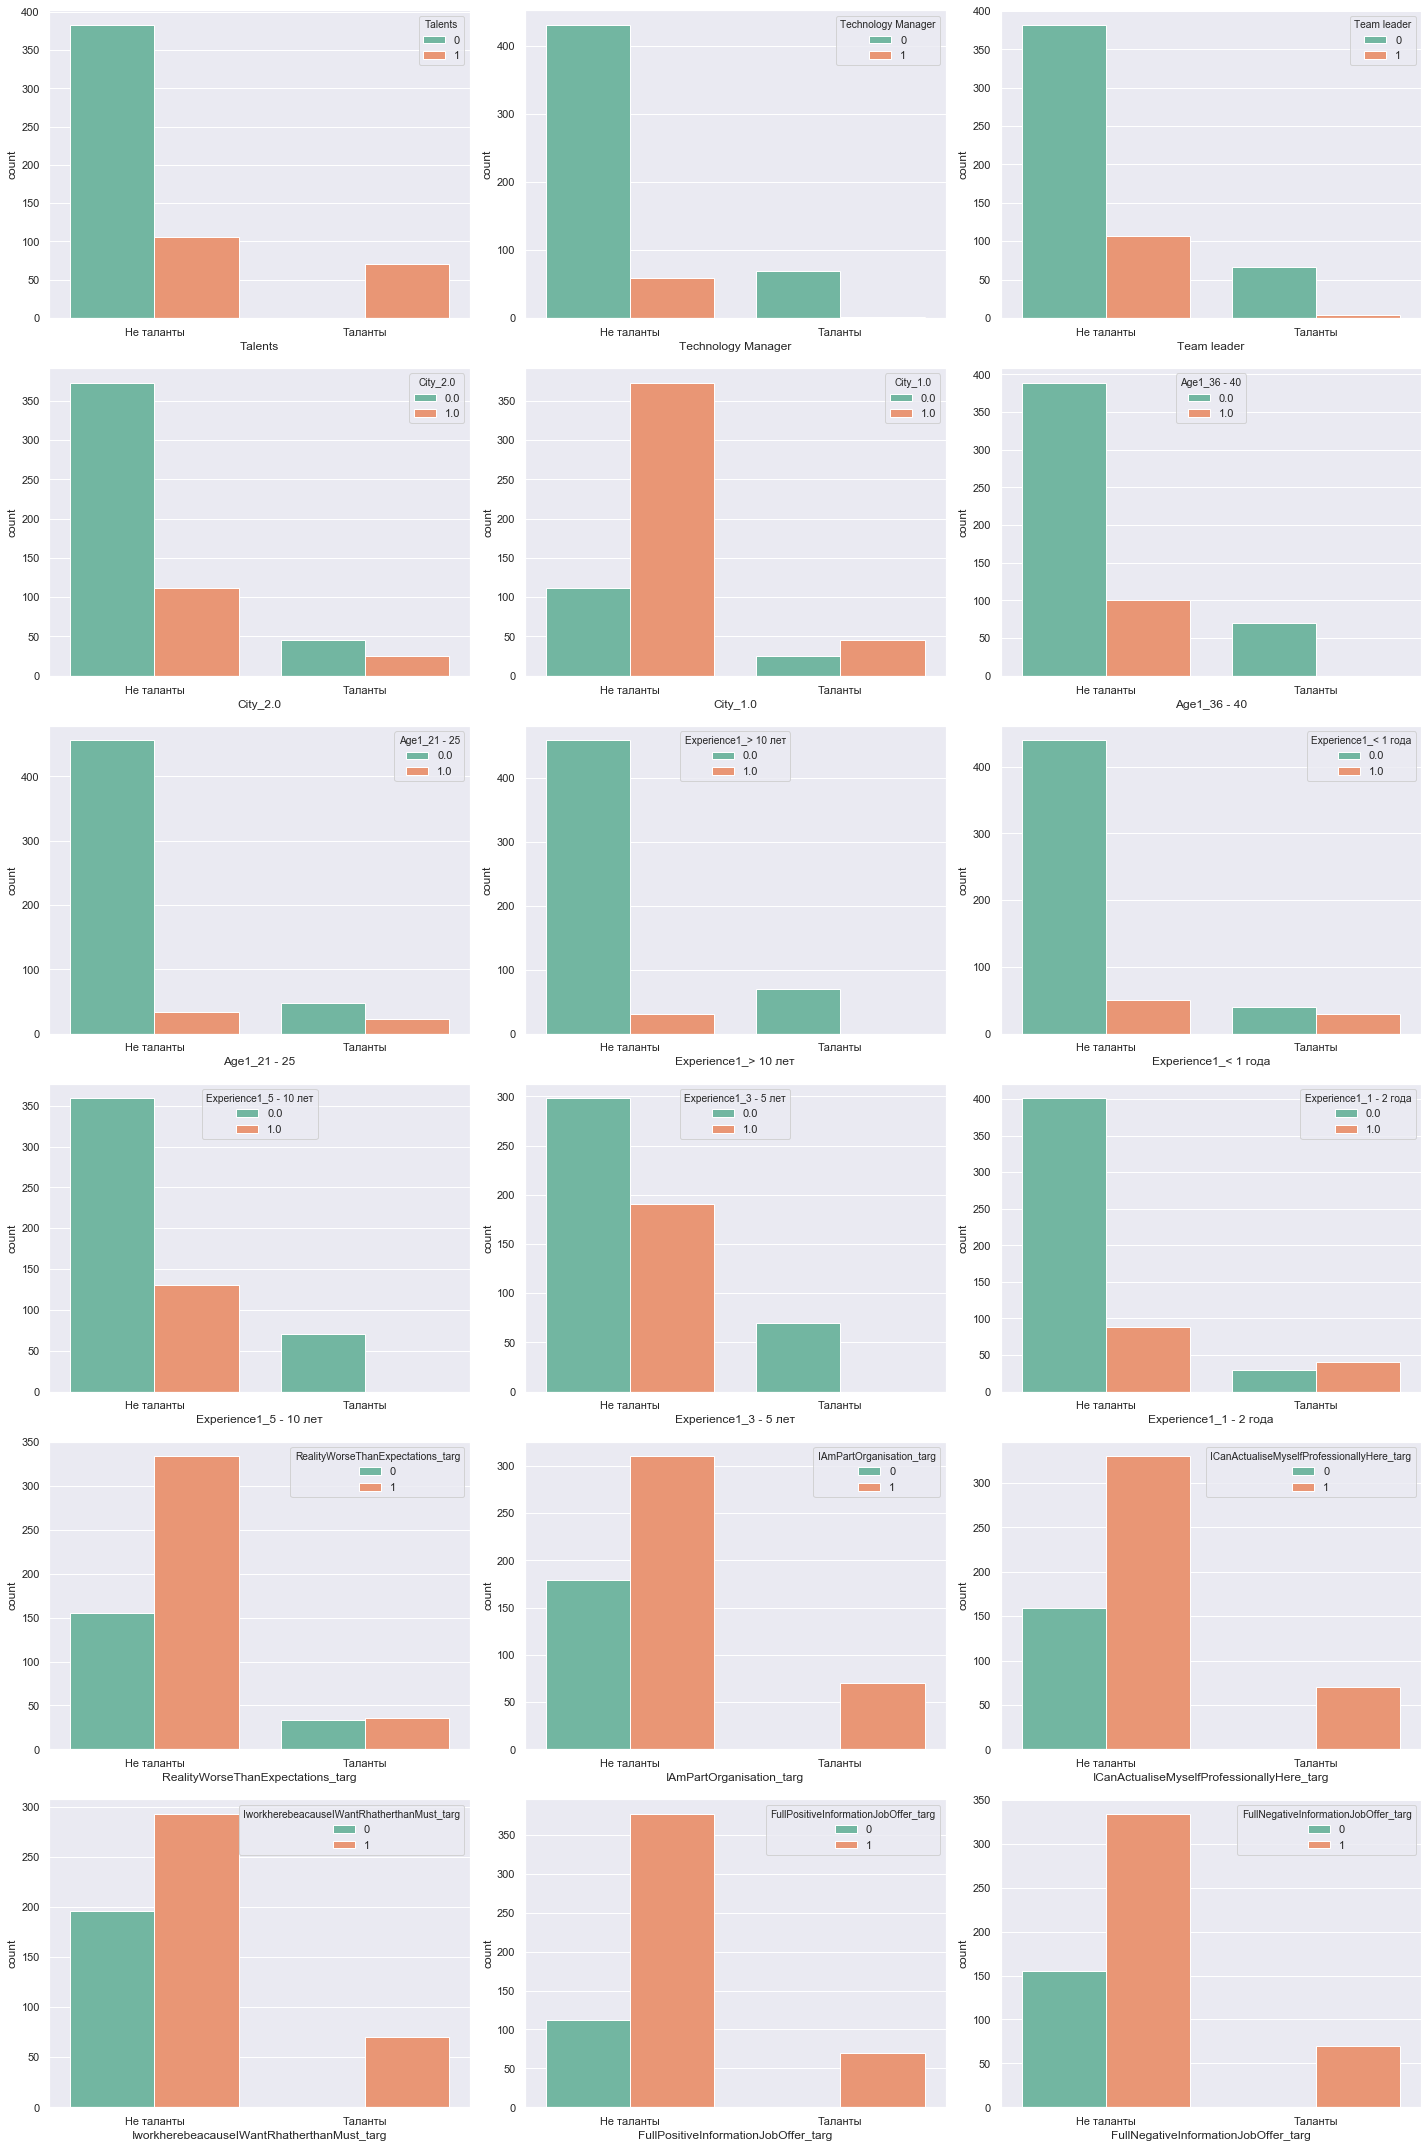

In [80]:
lst = list(tab[tab['p_val'] < 0.05]['Фактор'])

cat_list = [x for x in lst if len(pd.unique(df[lst][x].dropna())) < 3]

fig, axes = plt.subplots(round(len(df[cat_list].columns) / 3), 3, figsize=(20, 30))

for i, ax in enumerate(fig.axes):
    if i < len(df[cat_list].columns):
        sns.countplot(x = 'New_talents', hue = df[cat_list].iloc[:, i].name, data = df, ax = ax, palette= 'Set2')
        ax.set_xlabel(df[cat_list].iloc[:, i].name)
        ax.set_xticklabels(labels = ['Не таланты', 'Таланты'])

fig.tight_layout()

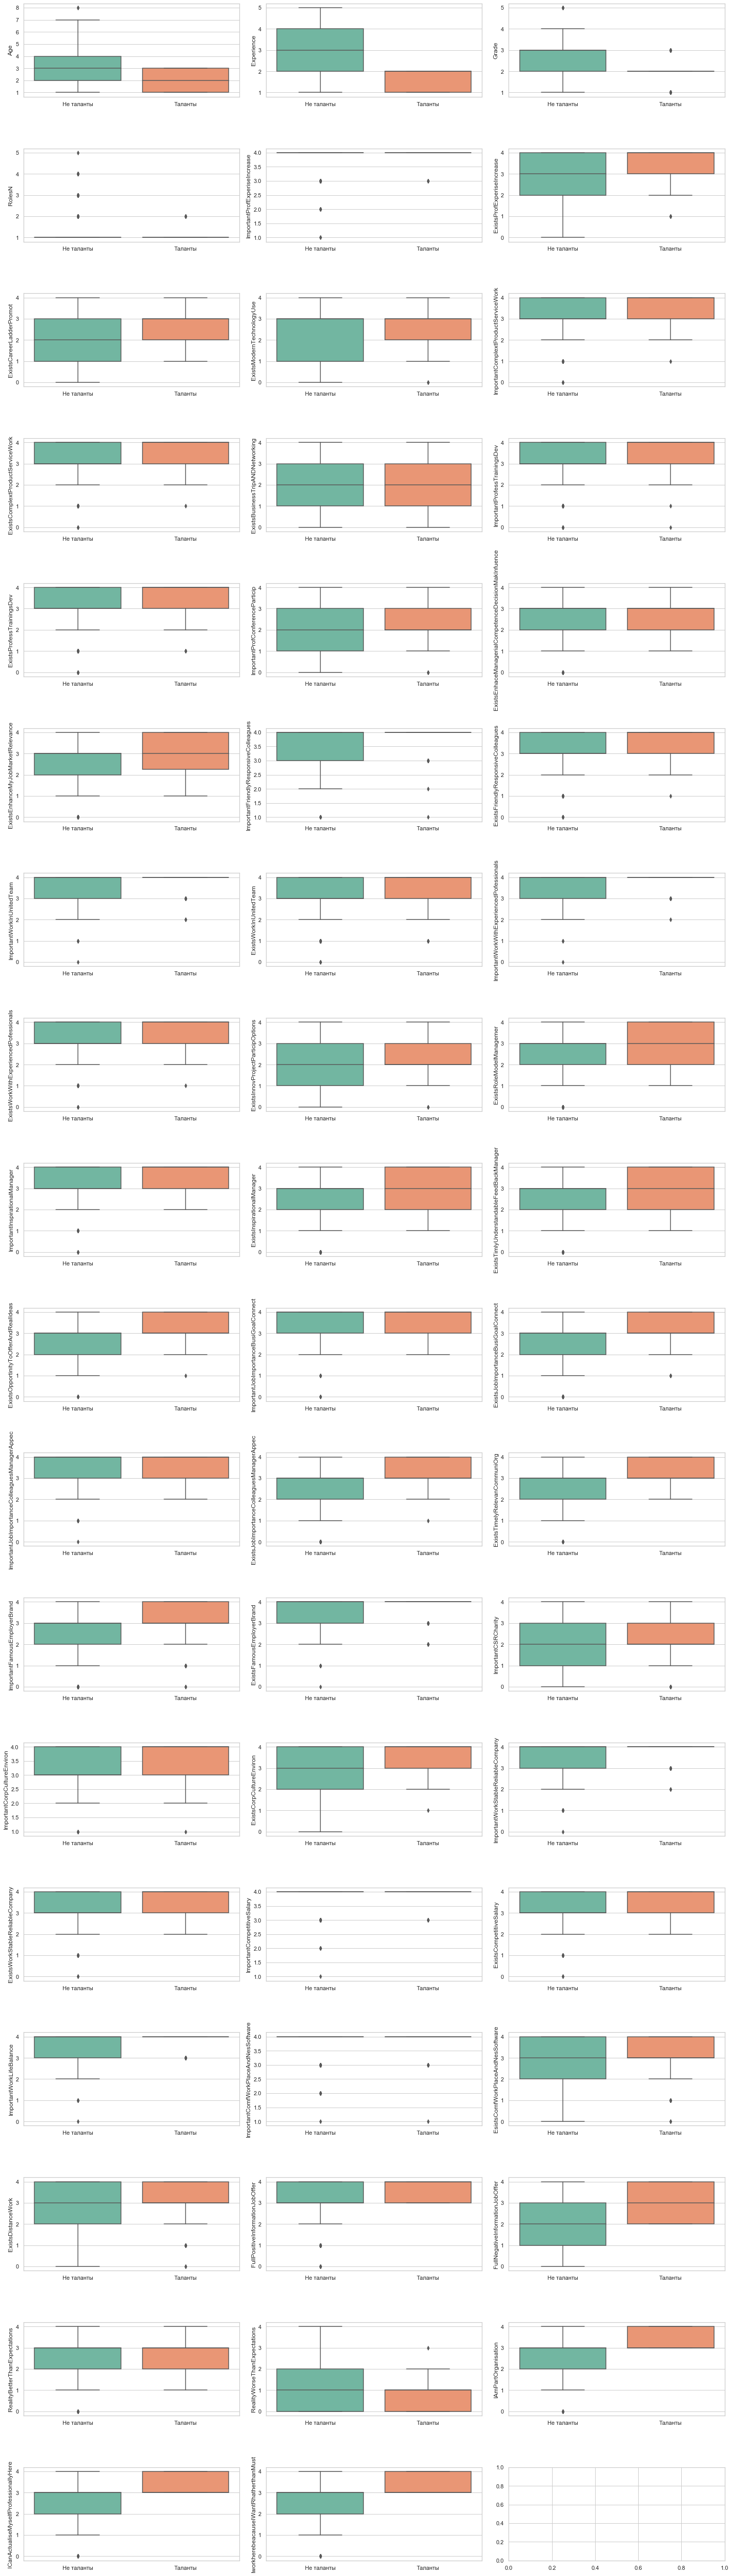

In [81]:
lst = list(tab[tab['p_val'] < 0.05]['Фактор'])

num_sign_list = [x for x in lst if len(pd.unique(df[lst][x].dropna())) > 2]

sns.set(style = 'whitegrid')
fig, axes = plt.subplots(round(len(df[num_sign_list].columns) / 3), 3, figsize=(20, 70))

for i, ax in enumerate(fig.axes):
    if i < len(df[num_sign_list].columns):
        sns.boxplot(x=df['New_talents'], y=df[num_sign_list].iloc[:, i], ax = ax, palette='Set2')
        ax.set_xlabel('')
        ax.set_xticklabels(labels = ['Не таланты', 'Таланты'])

fig.tight_layout()